# Mount and PIP install

In [1]:
cd 'C:/Users/dlsxjs/Downloads/GATNE_revision1_server용'

[WinError 123] 파일 이름, 디렉터리 이름 또는 볼륨 레이블 구문이 잘못되었습니다: "'C:/Users/dlsxjs/Downloads/GATNE_revision1_server용'"
c:\Users\dlsxjs\Downloads\GATNE_revision1_server용


C:\Users\dlsxjs\AppData\Roaming\Python\Python39\site-packages\IPython\core\magics\osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [2]:
pip install -Uqq ipdb

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\dlsxjs\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [4]:
import ipdb
%pdb on

Automatic pdb calling has been turned ON


# Run the Model


In [5]:
import os
os.chdir("C:/Users/dlsxjs/Downloads/GATNE_revision1_server용")
import sys
sys.path.append('C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/src')

In [6]:
import math
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from utils import *
from numpy import random
from torch.nn.parameter import Parameter

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)

In [7]:
def get_batches(pairs, neighbors, batch_size):
    n_batches = (len(pairs) + (batch_size - 1)) // batch_size

    for idx in range(n_batches):
        x, y, t, neigh = [], [], [], []
        for i in range(batch_size):
            index = idx * batch_size + i
            if index >= len(pairs):
                break
            x.append(pairs[index][0])
            y.append(pairs[index][1])
            t.append(pairs[index][2])
            neigh.append(neighbors[pairs[index][0]])
        yield torch.tensor(x), torch.tensor(y), torch.tensor(t), torch.tensor(neigh)


class GATNEModel(nn.Module):
    def __init__(
        self, num_nodes, embedding_size, embedding_u_size, edge_type_count, dim_a, features
    ):
        super(GATNEModel, self).__init__()
        self.num_nodes = num_nodes
        self.embedding_size = embedding_size
        self.embedding_u_size = embedding_u_size
        self.edge_type_count = edge_type_count
        self.dim_a = dim_a

        self.features = None
        if features is not None:
            self.features = features
            feature_dim = self.features.shape[-1]
            self.embed_trans = Parameter(torch.FloatTensor(feature_dim, embedding_size))
            self.u_embed_trans = Parameter(torch.FloatTensor(edge_type_count, feature_dim, embedding_u_size))
        else:
            self.node_embeddings = Parameter(torch.FloatTensor(num_nodes, embedding_size))
            self.node_type_embeddings = Parameter(
                torch.FloatTensor(num_nodes, edge_type_count, embedding_u_size)
            )
        self.trans_weights = Parameter(
            torch.FloatTensor(edge_type_count, embedding_u_size, embedding_size)
        )
        self.trans_weights_s1 = Parameter(
            torch.FloatTensor(edge_type_count, embedding_u_size, dim_a)
        )
        self.trans_weights_s2 = Parameter(torch.FloatTensor(edge_type_count, dim_a, 1))

        self.reset_parameters()

    def reset_parameters(self):
        if self.features is not None:
            self.embed_trans.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
            self.u_embed_trans.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
        else:
            self.node_embeddings.data.uniform_(-1.0, 1.0)
            self.node_type_embeddings.data.uniform_(-1.0, 1.0)
        self.trans_weights.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
        self.trans_weights_s1.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
        self.trans_weights_s2.data.normal_(std=1.0 / math.sqrt(self.embedding_size))

    def forward(self, train_inputs, train_types, node_neigh):
        if self.features is None:
            node_embed = self.node_embeddings[train_inputs]
            with open('C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/data/base_emb.pickle_{epoch}', 'wb') as base_emb:
              pickle.dump(node_embed.detach().cpu().numpy(), base_emb)
            node_embed_neighbors = self.node_type_embeddings[node_neigh]
        else:
            node_embed = torch.mm(self.features[train_inputs], self.embed_trans)
            node_embed_neighbors = torch.einsum('bijk,akm->bijam', self.features[node_neigh], self.u_embed_trans)
        node_embed_tmp = torch.diagonal(node_embed_neighbors, dim1=1, dim2=3).permute(0, 3, 1, 2)
        node_type_embed = torch.sum(node_embed_tmp, dim=2)

        trans_w = self.trans_weights[train_types]
        trans_w_s1 = self.trans_weights_s1[train_types]
        trans_w_s2 = self.trans_weights_s2[train_types]

        attention = F.softmax(
            torch.matmul(
                torch.tanh(torch.matmul(node_type_embed, trans_w_s1)), trans_w_s2
            ).squeeze(2),
            dim=1,
        ).unsqueeze(1)
        node_type_embed = torch.matmul(attention, node_type_embed)
        node_embed = node_embed + torch.matmul(node_type_embed, trans_w).squeeze(1)

        last_node_embed = F.normalize(node_embed, dim=1)

        return last_node_embed


class NSLoss(nn.Module):
    def __init__(self, num_nodes, num_sampled, embedding_size):
        super(NSLoss, self).__init__()
        self.num_nodes = num_nodes
        self.num_sampled = num_sampled
        self.embedding_size = embedding_size
        self.weights = Parameter(torch.FloatTensor(num_nodes, embedding_size))
        self.sample_weights = F.normalize(
            torch.Tensor(
                [
                    (math.log(k + 2) - math.log(k + 1)) / math.log(num_nodes + 1)
                    for k in range(num_nodes)
                ]
            ),
            dim=0,
        )

        self.reset_parameters()

    def reset_parameters(self):
        self.weights.data.normal_(std=1.0 / math.sqrt(self.embedding_size))

    def forward(self, input, embs, label):
        n = input.shape[0]
        log_target = torch.log(
            torch.sigmoid(torch.sum(torch.mul(embs, self.weights[label]), 1))
        )
        negs = torch.multinomial(
            self.sample_weights, self.num_sampled * n, replacement=True
        ).view(n, self.num_sampled)
        noise = torch.neg(self.weights[negs])
        sum_log_sampled = torch.sum(
            torch.log(torch.sigmoid(torch.bmm(noise, embs.unsqueeze(2)))), 1
        ).squeeze()

        loss = log_target + sum_log_sampled
        return -loss.sum() / n


def train_model(network_data, feature_dic):
    vocab, index2word, train_pairs = generate(network_data, args.num_walks, args.walk_length, args.schema, file_name, args.window_size, args.num_workers, args.walk_file)

    edge_types = list(network_data.keys())
    num_nodes = len(index2word)
    edge_type_count = len(edge_types)
    #epochs = 1
    epochs = args.epoch
    batch_size = args.batch_size
    embedding_size = args.dimensions
    embedding_u_size = args.edge_dim
    u_num = edge_type_count
    num_sampled = args.negative_samples
    dim_a = args.att_dim
    att_head = 1
    neighbor_samples = args.neighbor_samples

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    neighbors = generate_neighbors(network_data, vocab, num_nodes, edge_types, neighbor_samples)

    features = None
    if feature_dic is not None:
        feature_dim = len(list(feature_dic.values())[0])
        print('feature dimension: ' + str(feature_dim))
        features = np.zeros((num_nodes, feature_dim), dtype=np.float32)
        for key, value in feature_dic.items():
            if key in vocab:
                features[vocab[key].index, :] = np.array(value)
        features = torch.FloatTensor(features).to(device)

    model = GATNEModel(
        num_nodes, embedding_size, embedding_u_size, edge_type_count, dim_a, features
    )
    nsloss = NSLoss(num_nodes, num_sampled, embedding_size)

    model.to(device)
    nsloss.to(device)

    optimizer = torch.optim.Adam(
        [{"params": model.parameters()}, {"params": nsloss.parameters()}], lr=1e-2
    )

    best_score = 0
    test_score = (0.0, 0.0, 0.0)
    patience = 0
    best_model_state = None ###

    for epoch in range(epochs):
        random.shuffle(train_pairs)
        batches = get_batches(train_pairs, neighbors, batch_size)

        data_iter = tqdm(
            batches,
            desc="epoch %d" % (epoch),
            total=(len(train_pairs) + (batch_size - 1)) // batch_size,
            bar_format="{l_bar}{r_bar}",
        )
        avg_loss = 0.0

        for i, data in enumerate(data_iter):
            optimizer.zero_grad()
            embs = model(data[0].to(device), data[2].to(device), data[3].to(device),)
            loss = nsloss(data[0].to(device), embs, data[1].to(device))
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()

            if i % 5000 == 0:
                post_fix = {
                    "epoch": epoch,
                    "iter": i,
                    "avg_loss": avg_loss / (i + 1),
                    "loss": loss.item(),
                }
                data_iter.write(str(post_fix))

        final_model = dict(zip(edge_types, [dict() for _ in range(edge_type_count)]))

        for i in range(num_nodes):
            train_inputs = torch.tensor([i for _ in range(edge_type_count)]).to(device)
            train_types = torch.tensor(list(range(edge_type_count))).to(device)
            node_neigh = torch.tensor(
                [neighbors[i] for _ in range(edge_type_count)]
            ).to(device)
            node_emb = model(train_inputs, train_types, node_neigh)
            for j in range(edge_type_count):
                final_model[edge_types[j]][index2word[i]] = (
                    node_emb[j].cpu().detach().numpy()
                )

        pickle.dump(final_model, open(
            f'C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/data/emb_{cross_num}_{epoch}.pickle', 'wb'))

        #with open('/content/drive/MyDrive/병찬/GATNE/GATNE-master/data/emb.pickle_{epoch}', 'wb') as emb:
       #   pickle.dump(final_model, emb)
        valid_aucs, valid_f1s, valid_prs = [], [], []
        test_aucs, test_f1s, test_prs = [], [], []
        for i in range(edge_type_count):
            if args.eval_type == "all" or edge_types[i] in args.eval_type.split(","):
                tmp_auc, tmp_f1, tmp_pr = evaluate(
                    final_model[edge_types[i]],
                    valid_true_data_by_edge[edge_types[i]],
                    valid_false_data_by_edge[edge_types[i]],
                )
                valid_aucs.append(tmp_auc)
                valid_f1s.append(tmp_f1)
                valid_prs.append(tmp_pr)

                tmp_auc, tmp_f1, tmp_pr = evaluate(
                    final_model[edge_types[i]],
                    testing_true_data_by_edge[edge_types[i]],
                    testing_false_data_by_edge[edge_types[i]],
                )
                test_aucs.append(tmp_auc)
                test_f1s.append(tmp_f1)
                test_prs.append(tmp_pr)
        print("valid auc:", np.mean(valid_aucs))
        print("valid pr:", np.mean(valid_prs))
        print("valid f1:", np.mean(valid_f1s))

        average_auc = np.mean(test_aucs)
        average_f1 = np.mean(test_f1s)
        average_pr = np.mean(test_prs)

        cur_score = np.mean(valid_aucs)
        if cur_score > best_score:
            best_score = cur_score
            best_model_state = model.state_dict() ###
            torch.save(best_model_state, f'C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/model_best_{epoch}.pth') ###
            test_score = (average_auc, average_f1, average_pr)
            patience = 0
        else:
            patience += 1
            if patience > args.patience:
                print("Early Stopping")
                break
    return test_score


In [8]:
import random
args = parse_args()
file_name = args.input

## Input Data

In [9]:
#full_name = './data/df2001_2005_revised.csv'
full_name = 'C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/data/df2006_2010_revised.csv'
edge_data_by_type = load_training_data(full_name)

We are loading data from: C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/data/df2006_2010_revised.csv
Total training nodes: 1116


## Train, Test, Valid Splitting

In [10]:
def divide_data(input_list, group_number):
  local_division = len(input_list) / float(group_number)
  random.Random(0).shuffle(input_list)
  return [input_list[int(round(local_division * i)): int(round(local_division * (i + 1)))] for i in range(group_number)]

In [11]:
number_of_groups = 5
edge_data_by_type_by_group = dict()
for edge_type in edge_data_by_type:
    all_data = edge_data_by_type[edge_type]
    separated_data = divide_data(all_data, number_of_groups)
    edge_data_by_type_by_group[edge_type] = separated_data
#edge_data_by_type_by_group은 각 레이어의 모든 노드 페어들에 대하여 5개의 list로 나눈 후 5개를 하나의 리스트로 하는 것을 원소로 함
#edge_data_by_type={'1':[(A,B),(C,D), '2':[(E,F)...]]}
#edge_data_by_type_by_grop=['1':[[(A,B)],[(B,C),(C,D)],[(C,D),(D,E)],[(E,F),(F,G)],[(G,H),(H,I)]], '2':[..]..]

In [12]:
def randomly_choose_false_edges(nodes, true_edges):
    tmp_list = list()
    all_edges = list()
    # Create a list of all possible edges between nodes
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            all_edges.append((i, j))

    # Shuffle the list of all edges randomly
    random.shuffle(all_edges)
    # Count the number of true edges
    num_true_edges = len(true_edges)
    num_false_edges = 0
    # Select a random subset of false edges equal to the number of true edges
    for edge in all_edges:
        if num_false_edges == num_true_edges:
            break
        if edge[0] == edge[1]:
            continue
        if (nodes[edge[0]], nodes[edge[1]]) not in true_edges and (nodes[edge[1]], nodes[edge[0]]) not in true_edges:
            tmp_list.append((nodes[edge[0]], nodes[edge[1]]))
            num_false_edges += 1
    return tmp_list

## Model Training

In [13]:
if __name__ == "__main__":
    args = parse_args()
    file_name = args.input
    print(args)
    if args.features is not None:
        feature_dic = load_feature_data(args.features)
    else:
        feature_dic = None

    overall_ROC_AUC_Fold = []
    overall_PR_AUC_Fold = []
    overall_F1_Fold = []

    cross_num = 0
    for i in range(number_of_groups):
      training_data_by_type = dict()
      evaluation_data_by_type = dict()

      for edge_type in edge_data_by_type_by_group:
        training_data_by_type[edge_type] = list()
        evaluation_data_by_type[edge_type] = list()
        for j in range(number_of_groups):
          if j == i:
            for tmp_edge in edge_data_by_type_by_group[edge_type][j]:
              evaluation_data_by_type[edge_type].append((tmp_edge[0], tmp_edge[1]))
          else:
            for tmp_edge in edge_data_by_type_by_group[edge_type][j]:
              training_data_by_type[edge_type].append((tmp_edge[0], tmp_edge[1]))
      #edge_data_by_type_by_group은 각 edge_type에 대하여 5개의 list가 있다.
      #이 중 하나를 evaluation으로 두고 나머지를 training으로 둔다. 이걸 계속 반복
      training_nodes = list()
      for edge_type in training_data_by_type:
        for edge in training_data_by_type[edge_type]:
          training_nodes.append(edge[0])
          training_nodes.append(edge[1])
      training_nodes = list(set(training_nodes))


      number_of_valid_groups = 2
      valid_data_by_type_by_group = dict()

      for edge_type in evaluation_data_by_type:
        valid_all_data = evaluation_data_by_type[edge_type]
        valid_separated_data = divide_data(valid_all_data, number_of_valid_groups)
        valid_data_by_type_by_group[edge_type] = valid_separated_data
      #evaluation을 다시 각 edge type마다 두개의 list로 나눈다. 이둘은 각각 valid, test로 나뉜다.

      i = random.randrange(0, 1)
      valid_true_data_by_edge = dict()
      testing_true_data_by_edge = dict()

      for edge_type in valid_data_by_type_by_group:
        valid_true_data_by_edge[edge_type] = list()
        testing_true_data_by_edge[edge_type] = list()
        for j in range(number_of_valid_groups):
          if j == i:
            for tmp_edge in valid_data_by_type_by_group[edge_type][j]:
              valid_true_data_by_edge[edge_type].append((tmp_edge[0], tmp_edge[1]))
          else:
            for tmp_edge in valid_data_by_type_by_group[edge_type][j]:
              testing_true_data_by_edge[edge_type].append((tmp_edge[0], tmp_edge[1]))

      valid_selected_false_edges1 = randomly_choose_false_edges(training_nodes, valid_true_data_by_edge['1'])
      valid_selected_false_edges2 = randomly_choose_false_edges(training_nodes, valid_true_data_by_edge['2'])
      valid_selected_false_edges3 = randomly_choose_false_edges(training_nodes, valid_true_data_by_edge['3'])
      print(len(valid_selected_false_edges1),len(valid_selected_false_edges2),len(valid_selected_false_edges3))

      test_selected_false_edges1 = randomly_choose_false_edges(training_nodes, testing_true_data_by_edge['1'])
      test_selected_false_edges2 = randomly_choose_false_edges(training_nodes, testing_true_data_by_edge['2'])
      test_selected_false_edges3 = randomly_choose_false_edges(training_nodes, testing_true_data_by_edge['3'])
      print(len(test_selected_false_edges1),len(test_selected_false_edges2),len(test_selected_false_edges3))

      valid_list = [valid_selected_false_edges1, valid_selected_false_edges2, valid_selected_false_edges3]
      testing_list = [test_selected_false_edges1, test_selected_false_edges2, test_selected_false_edges3]
      string_list = ['1','2','3']
      valid_false_data_by_edge = dict(zip(string_list, valid_list))
      testing_false_data_by_edge = dict(zip(string_list, testing_list))

      average_auc, average_f1, average_pr = train_model(training_data_by_type, feature_dic)

      cross_num += 1

      print("\n","="*20, "\n", cross_num, "fold over","\n","="*20)

      overall_ROC_AUC_Fold.append(average_auc)
      overall_PR_AUC_Fold.append(average_pr)
      overall_F1_Fold.append(average_f1)

    print("Overall ROC-AUC:", average_auc)
    print("Overall PR-AUC", average_pr)
    print("Overall F1:", average_f1)


Namespace(input='C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/data', features=None, walk_file=None, epoch=100, batch_size=128, eval_type='all', schema=None, dimensions=50, edge_dim=5, att_dim=20, walk_length=30, num_walks=20, window_size=10, negative_samples=15, neighbor_samples=15, patience=5, num_workers=16)
240 61 652
240 61 653
Generating random walks for layer 0


8440it [00:00, 58768.13it/s]


Generating random walks for layer 1


2040it [00:00, 255704.39it/s]


Generating random walks for layer 2


16980it [00:00, 26073.73it/s]


Finish generating the walks
Saving walks for layer 0


100%|██████████| 8440/8440 [00:00<00:00, 86329.70it/s]


Saving walks for layer 1


100%|██████████| 2040/2040 [00:00<00:00, 145811.76it/s]


Saving walks for layer 2


100%|██████████| 16980/16980 [00:00<00:00, 156153.19it/s]


Counting vocab for layer 0


100%|██████████| 8440/8440 [00:00<00:00, 301954.40it/s]


Counting vocab for layer 1


100%|██████████| 2040/2040 [00:00<00:00, 340878.06it/s]


Counting vocab for layer 2


100%|██████████| 16980/16980 [00:00<00:00, 246644.30it/s]


Generating training pairs for layer 0


100%|██████████| 8440/8440 [00:00<00:00, 11019.74it/s]


Generating training pairs for layer 1


100%|██████████| 2040/2040 [00:00<00:00, 10764.08it/s]


Generating training pairs for layer 2


100%|██████████| 16980/16980 [00:01<00:00, 10406.54it/s]


Generating neighbors for layer 0


100%|██████████| 1922/1922 [00:00<00:00, 962676.41it/s]


Generating neighbors for layer 1


100%|██████████| 486/486 [00:00<00:00, 487196.88it/s]


Generating neighbors for layer 2


epoch 0:   0%|| 20/57924 [00:00<09:42, 99.32it/s]

{'epoch': 0, 'iter': 0, 'avg_loss': 11.113868713378906, 'loss': 11.113868713378906}


epoch 0:   9%|| 5009/57924 [00:43<07:51, 112.28it/s]

{'epoch': 0, 'iter': 5000, 'avg_loss': 2.8599490945850747, 'loss': 2.6235978603363037}


epoch 0:  17%|| 10013/57924 [01:24<06:06, 130.60it/s]

{'epoch': 0, 'iter': 10000, 'avg_loss': 2.7205380328046527, 'loss': 2.4519920349121094}


epoch 0:  26%|| 15017/57924 [02:05<05:40, 126.20it/s]

{'epoch': 0, 'iter': 15000, 'avg_loss': 2.660466965766964, 'loss': 2.580002546310425}


epoch 0:  35%|| 20016/57924 [02:45<05:13, 121.08it/s]

{'epoch': 0, 'iter': 20000, 'avg_loss': 2.627205498188378, 'loss': 2.579955577850342}


epoch 0:  43%|| 25013/57924 [03:26<04:23, 124.68it/s]

{'epoch': 0, 'iter': 25000, 'avg_loss': 2.6050541850930333, 'loss': 2.5069327354431152}


epoch 0:  52%|| 30021/57924 [04:07<04:09, 112.05it/s]

{'epoch': 0, 'iter': 30000, 'avg_loss': 2.5894903397664226, 'loss': 2.44502592086792}


epoch 0:  60%|| 35010/57924 [04:48<03:33, 107.51it/s]

{'epoch': 0, 'iter': 35000, 'avg_loss': 2.577447716860985, 'loss': 2.336677312850952}


epoch 0:  69%|| 40020/57924 [05:28<02:24, 123.94it/s]

{'epoch': 0, 'iter': 40000, 'avg_loss': 2.5682971281771785, 'loss': 2.401379346847534}


epoch 0:  78%|| 45016/57924 [06:09<01:44, 123.52it/s]

{'epoch': 0, 'iter': 45000, 'avg_loss': 2.5609288907035723, 'loss': 2.5070149898529053}


epoch 0:  86%|| 50022/57924 [06:49<01:05, 121.41it/s]

{'epoch': 0, 'iter': 50000, 'avg_loss': 2.5549236372641015, 'loss': 2.321671962738037}


epoch 0:  95%|| 55023/57924 [07:29<00:23, 122.93it/s]

{'epoch': 0, 'iter': 55000, 'avg_loss': 2.549630012653695, 'loss': 2.4109082221984863}


epoch 0: 100%|| 57924/57924 [07:52<00:00, 122.65it/s]


valid auc: 0.9527577514596589
valid pr: 0.9459422962991594
valid f1: 0.8893580193476792


epoch 1:   0%|| 11/57924 [00:00<08:50, 109.21it/s]

{'epoch': 1, 'iter': 0, 'avg_loss': 2.460036039352417, 'loss': 2.460036039352417}


epoch 1:   9%|| 5017/57924 [00:40<07:15, 121.55it/s]

{'epoch': 1, 'iter': 5000, 'avg_loss': 2.4868396524190186, 'loss': 2.671435594558716}


epoch 1:  17%|| 10019/57924 [01:21<06:15, 127.44it/s]

{'epoch': 1, 'iter': 10000, 'avg_loss': 2.4897238680177085, 'loss': 2.4913835525512695}


epoch 1:  26%|| 15025/57924 [02:02<05:31, 129.51it/s]

{'epoch': 1, 'iter': 15000, 'avg_loss': 2.489482097852692, 'loss': 2.7216084003448486}


epoch 1:  35%|| 20023/57924 [02:42<05:06, 123.81it/s]

{'epoch': 1, 'iter': 20000, 'avg_loss': 2.4883484076657334, 'loss': 2.583977460861206}


epoch 1:  43%|| 25025/57924 [03:22<04:13, 129.60it/s]

{'epoch': 1, 'iter': 25000, 'avg_loss': 2.4884003335240124, 'loss': 2.5097055435180664}


epoch 1:  52%|| 30023/57924 [04:03<03:43, 124.78it/s]

{'epoch': 1, 'iter': 30000, 'avg_loss': 2.4886469228526504, 'loss': 2.451861619949341}


epoch 1:  60%|| 35019/57924 [04:44<02:48, 136.29it/s]

{'epoch': 1, 'iter': 35000, 'avg_loss': 2.4888568123266808, 'loss': 2.487649440765381}


epoch 1:  69%|| 40024/57924 [05:24<02:17, 130.38it/s]

{'epoch': 1, 'iter': 40000, 'avg_loss': 2.4884666924488426, 'loss': 2.3749165534973145}


epoch 1:  78%|| 45011/57924 [06:04<02:05, 102.85it/s]

{'epoch': 1, 'iter': 45000, 'avg_loss': 2.4882934584686174, 'loss': 2.5637869834899902}


epoch 1:  86%|| 50030/57924 [06:44<00:59, 133.12it/s]

{'epoch': 1, 'iter': 50000, 'avg_loss': 2.488127961704434, 'loss': 2.307966709136963}


epoch 1:  95%|| 55010/57924 [07:25<00:26, 110.45it/s]

{'epoch': 1, 'iter': 55000, 'avg_loss': 2.48770671116348, 'loss': 2.414231538772583}


epoch 1: 100%|| 57924/57924 [07:48<00:00, 123.57it/s]


valid auc: 0.9571242254878313
valid pr: 0.9522520153684001
valid f1: 0.9045417854893


epoch 2:   0%|| 13/57924 [00:00<07:42, 125.34it/s]

{'epoch': 2, 'iter': 0, 'avg_loss': 2.436312675476074, 'loss': 2.436312675476074}


epoch 2:   9%|| 5015/57924 [00:40<07:03, 125.06it/s]

{'epoch': 2, 'iter': 5000, 'avg_loss': 2.4790203831143867, 'loss': 2.6002402305603027}


epoch 2:  17%|| 10012/57924 [01:20<06:27, 123.49it/s]

{'epoch': 2, 'iter': 10000, 'avg_loss': 2.479341059920192, 'loss': 2.3628530502319336}


epoch 2:  26%|| 15018/57924 [02:00<05:46, 123.99it/s]

{'epoch': 2, 'iter': 15000, 'avg_loss': 2.480276130579383, 'loss': 2.434946060180664}


epoch 2:  35%|| 20021/57924 [02:40<04:49, 130.99it/s]

{'epoch': 2, 'iter': 20000, 'avg_loss': 2.4798708881093803, 'loss': 2.2858965396881104}


epoch 2:  43%|| 25018/57924 [03:21<04:16, 128.35it/s]

{'epoch': 2, 'iter': 25000, 'avg_loss': 2.480169823625451, 'loss': 2.569504976272583}


epoch 2:  52%|| 30015/57924 [04:01<03:43, 125.14it/s]

{'epoch': 2, 'iter': 30000, 'avg_loss': 2.4800366792856527, 'loss': 2.4436089992523193}


epoch 2:  60%|| 35020/57924 [04:41<03:05, 123.27it/s]

{'epoch': 2, 'iter': 35000, 'avg_loss': 2.479997415610175, 'loss': 2.6016483306884766}


epoch 2:  69%|| 40018/57924 [05:22<02:34, 116.07it/s]

{'epoch': 2, 'iter': 40000, 'avg_loss': 2.479917840282219, 'loss': 2.361410140991211}


epoch 2:  78%|| 45018/57924 [06:02<01:47, 120.35it/s]

{'epoch': 2, 'iter': 45000, 'avg_loss': 2.479627933510886, 'loss': 2.558382034301758}


epoch 2:  86%|| 50015/57924 [06:43<01:03, 123.91it/s]

{'epoch': 2, 'iter': 50000, 'avg_loss': 2.4795652885694115, 'loss': 2.4596164226531982}


epoch 2:  95%|| 55013/57924 [07:23<00:23, 121.38it/s]

{'epoch': 2, 'iter': 55000, 'avg_loss': 2.4795441976974377, 'loss': 2.6954891681671143}


epoch 2: 100%|| 57924/57924 [07:47<00:00, 124.03it/s]


valid auc: 0.9550177873144241
valid pr: 0.9432964562296281
valid f1: 0.9073910052825233


epoch 3:   0%|| 13/57924 [00:00<07:33, 127.79it/s]

{'epoch': 3, 'iter': 0, 'avg_loss': 2.244046211242676, 'loss': 2.244046211242676}


epoch 3:   9%|| 5015/57924 [00:41<07:08, 123.46it/s]

{'epoch': 3, 'iter': 5000, 'avg_loss': 2.473362502229855, 'loss': 2.4323549270629883}


epoch 3:  17%|| 10017/57924 [01:22<06:47, 117.51it/s]

{'epoch': 3, 'iter': 10000, 'avg_loss': 2.4728454649776186, 'loss': 2.527691125869751}


epoch 3:  26%|| 15017/57924 [02:03<05:54, 121.05it/s]

{'epoch': 3, 'iter': 15000, 'avg_loss': 2.4729684932924383, 'loss': 2.5790047645568848}


epoch 3:  35%|| 20018/57924 [02:44<05:11, 121.64it/s]

{'epoch': 3, 'iter': 20000, 'avg_loss': 2.473067668645205, 'loss': 2.6015784740448}


epoch 3:  43%|| 25016/57924 [03:25<04:32, 120.92it/s]

{'epoch': 3, 'iter': 25000, 'avg_loss': 2.4737596078794635, 'loss': 2.708207607269287}


epoch 3:  52%|| 30022/57924 [04:07<03:58, 116.75it/s]

{'epoch': 3, 'iter': 30000, 'avg_loss': 2.4740773741036532, 'loss': 2.353593587875366}


epoch 3:  60%|| 35021/57924 [04:48<03:08, 121.54it/s]

{'epoch': 3, 'iter': 35000, 'avg_loss': 2.4745720601934, 'loss': 2.496821880340576}


epoch 3:  69%|| 40017/57924 [05:29<02:26, 122.60it/s]

{'epoch': 3, 'iter': 40000, 'avg_loss': 2.4741728868410826, 'loss': 2.390491008758545}


epoch 3:  78%|| 45013/57924 [06:10<01:58, 108.62it/s]

{'epoch': 3, 'iter': 45000, 'avg_loss': 2.4744421169732993, 'loss': 2.65525484085083}


epoch 3:  86%|| 50027/57924 [06:52<01:04, 122.41it/s]

{'epoch': 3, 'iter': 50000, 'avg_loss': 2.4744037233761094, 'loss': 2.3462564945220947}


epoch 3:  95%|| 55018/57924 [07:33<00:24, 121.01it/s]

{'epoch': 3, 'iter': 55000, 'avg_loss': 2.4746095812499953, 'loss': 2.4344656467437744}


epoch 3: 100%|| 57924/57924 [07:58<00:00, 121.07it/s]


valid auc: 0.9613708707409973
valid pr: 0.9568928231347765
valid f1: 0.9177079418346512


epoch 4:   0%|| 12/57924 [00:00<08:39, 111.40it/s]

{'epoch': 4, 'iter': 0, 'avg_loss': 2.4297432899475098, 'loss': 2.4297432899475098}


epoch 4:   9%|| 5014/57924 [00:41<06:56, 127.12it/s]

{'epoch': 4, 'iter': 5000, 'avg_loss': 2.4682070384667267, 'loss': 2.51298189163208}


epoch 4:  17%|| 10016/57924 [01:23<06:46, 117.97it/s]

{'epoch': 4, 'iter': 10000, 'avg_loss': 2.469750199719866, 'loss': 2.4169576168060303}


epoch 4:  26%|| 15022/57924 [02:04<05:50, 122.57it/s]

{'epoch': 4, 'iter': 15000, 'avg_loss': 2.4700068437642284, 'loss': 2.469041109085083}


epoch 4:  35%|| 20020/57924 [02:46<04:59, 126.47it/s]

{'epoch': 4, 'iter': 20000, 'avg_loss': 2.4703962207108723, 'loss': 2.4979283809661865}


epoch 4:  43%|| 25013/57924 [03:27<04:18, 127.52it/s]

{'epoch': 4, 'iter': 25000, 'avg_loss': 2.470606390359254, 'loss': 2.573458194732666}


epoch 4:  52%|| 30012/57924 [04:09<04:18, 108.16it/s]

{'epoch': 4, 'iter': 30000, 'avg_loss': 2.4706325197548855, 'loss': 2.403993606567383}


epoch 4:  60%|| 35016/57924 [04:51<03:12, 119.08it/s]

{'epoch': 4, 'iter': 35000, 'avg_loss': 2.4708507729715588, 'loss': 2.67047381401062}


epoch 4:  69%|| 40013/57924 [05:37<02:24, 124.10it/s]

{'epoch': 4, 'iter': 40000, 'avg_loss': 2.4714634952531815, 'loss': 2.2936811447143555}


epoch 4:  78%|| 45012/57924 [06:18<01:41, 126.74it/s]

{'epoch': 4, 'iter': 45000, 'avg_loss': 2.4715559513409247, 'loss': 2.158337116241455}


epoch 4:  86%|| 50016/57924 [06:59<01:02, 127.46it/s]

{'epoch': 4, 'iter': 50000, 'avg_loss': 2.4718541091891404, 'loss': 2.671278238296509}


epoch 4:  95%|| 55020/57924 [07:41<00:22, 131.20it/s]

{'epoch': 4, 'iter': 55000, 'avg_loss': 2.4722113096549947, 'loss': 2.2829437255859375}


epoch 4: 100%|| 57924/57924 [08:05<00:00, 119.28it/s]


valid auc: 0.9599612824026833
valid pr: 0.9569586877410369
valid f1: 0.898923352647763


epoch 5:   0%|| 9/57924 [00:00<15:17, 63.12it/s]

{'epoch': 5, 'iter': 0, 'avg_loss': 2.442812204360962, 'loss': 2.442812204360962}


epoch 5:   9%|| 5022/57924 [00:41<07:43, 114.14it/s]

{'epoch': 5, 'iter': 5000, 'avg_loss': 2.466108950203215, 'loss': 2.38616943359375}


epoch 5:  17%|| 10020/57924 [01:23<06:24, 124.72it/s]

{'epoch': 5, 'iter': 10000, 'avg_loss': 2.468112728283675, 'loss': 2.4899892807006836}


epoch 5:  26%|| 15022/57924 [02:04<06:12, 115.26it/s]

{'epoch': 5, 'iter': 15000, 'avg_loss': 2.468528651228015, 'loss': 2.5092244148254395}


epoch 5:  35%|| 20016/57924 [02:46<05:00, 126.04it/s]

{'epoch': 5, 'iter': 20000, 'avg_loss': 2.4690628335700144, 'loss': 2.4171042442321777}


epoch 5:  43%|| 25016/57924 [03:28<04:33, 120.11it/s]

{'epoch': 5, 'iter': 25000, 'avg_loss': 2.4693217485991723, 'loss': 2.706735134124756}


epoch 5:  52%|| 30020/57924 [04:10<03:38, 127.63it/s]

{'epoch': 5, 'iter': 30000, 'avg_loss': 2.4694088926267943, 'loss': 2.4639651775360107}


epoch 5:  60%|| 35021/57924 [04:52<03:18, 115.32it/s]

{'epoch': 5, 'iter': 35000, 'avg_loss': 2.4696451352291837, 'loss': 2.392179250717163}


epoch 5:  69%|| 40020/57924 [05:34<02:27, 121.66it/s]

{'epoch': 5, 'iter': 40000, 'avg_loss': 2.4696940763429214, 'loss': 2.4841253757476807}


epoch 5:  78%|| 45009/57924 [06:16<01:44, 123.25it/s]

{'epoch': 5, 'iter': 45000, 'avg_loss': 2.469857027720288, 'loss': 2.3969035148620605}


epoch 5:  86%|| 50026/57924 [06:58<00:59, 132.03it/s]

{'epoch': 5, 'iter': 50000, 'avg_loss': 2.4700635377389117, 'loss': 2.440556526184082}


epoch 5:  95%|| 55014/57924 [07:40<00:23, 124.91it/s]

{'epoch': 5, 'iter': 55000, 'avg_loss': 2.470127038206981, 'loss': 2.5854523181915283}


epoch 5: 100%|| 57924/57924 [08:05<00:00, 119.38it/s]


valid auc: 0.9654220084041903
valid pr: 0.9626364581597251
valid f1: 0.9129896219822317


epoch 6:   0%|| 12/57924 [00:00<08:35, 112.45it/s]

{'epoch': 6, 'iter': 0, 'avg_loss': 2.422344923019409, 'loss': 2.422344923019409}


epoch 6:   9%|| 5022/57924 [00:41<07:38, 115.43it/s]

{'epoch': 6, 'iter': 5000, 'avg_loss': 2.462453821329469, 'loss': 2.3054280281066895}


epoch 6:  17%|| 10020/57924 [01:23<06:36, 120.78it/s]

{'epoch': 6, 'iter': 10000, 'avg_loss': 2.4652612715193705, 'loss': 2.510324001312256}


epoch 6:  26%|| 15012/57924 [02:05<05:48, 123.23it/s]

{'epoch': 6, 'iter': 15000, 'avg_loss': 2.466398448103643, 'loss': 2.7945468425750732}


epoch 6:  35%|| 20018/57924 [02:47<04:57, 127.23it/s]

{'epoch': 6, 'iter': 20000, 'avg_loss': 2.4669808376479714, 'loss': 2.4513332843780518}


epoch 6:  43%|| 25015/57924 [03:29<04:20, 126.29it/s]

{'epoch': 6, 'iter': 25000, 'avg_loss': 2.4677221764946387, 'loss': 2.4834375381469727}


epoch 6:  52%|| 30015/57924 [04:11<04:00, 116.08it/s]

{'epoch': 6, 'iter': 30000, 'avg_loss': 2.4682465237437285, 'loss': 2.4441585540771484}


epoch 6:  60%|| 35009/57924 [04:53<03:21, 113.71it/s]

{'epoch': 6, 'iter': 35000, 'avg_loss': 2.4679962190088998, 'loss': 2.6040072441101074}


epoch 6:  69%|| 40019/57924 [05:35<02:51, 104.67it/s]

{'epoch': 6, 'iter': 40000, 'avg_loss': 2.46801127281157, 'loss': 2.3724873065948486}


epoch 6:  78%|| 45015/57924 [06:16<01:41, 127.21it/s]

{'epoch': 6, 'iter': 45000, 'avg_loss': 2.468122608682685, 'loss': 2.4751834869384766}


epoch 6:  86%|| 50015/57924 [06:58<01:06, 119.29it/s]

{'epoch': 6, 'iter': 50000, 'avg_loss': 2.4683933505172555, 'loss': 2.4504172801971436}


epoch 6:  95%|| 55019/57924 [07:41<00:22, 128.73it/s]

{'epoch': 6, 'iter': 55000, 'avg_loss': 2.4684296358160744, 'loss': 2.512312412261963}


epoch 6: 100%|| 57924/57924 [08:05<00:00, 119.29it/s]


valid auc: 0.9595031885362246
valid pr: 0.9533637863827759
valid f1: 0.903938691974329


epoch 7:   0%|| 12/57924 [00:00<08:30, 113.51it/s]

{'epoch': 7, 'iter': 0, 'avg_loss': 2.406801462173462, 'loss': 2.406801462173462}


epoch 7:   9%|| 5023/57924 [00:42<08:21, 105.47it/s]

{'epoch': 7, 'iter': 5000, 'avg_loss': 2.4615469703529387, 'loss': 2.4637510776519775}


epoch 7:  17%|| 10015/57924 [01:24<06:44, 118.31it/s]

{'epoch': 7, 'iter': 10000, 'avg_loss': 2.463524788930981, 'loss': 2.568239688873291}


epoch 7:  26%|| 15012/57924 [02:05<06:00, 119.09it/s]

{'epoch': 7, 'iter': 15000, 'avg_loss': 2.4646884316039492, 'loss': 2.686967372894287}


epoch 7:  35%|| 20022/57924 [02:47<04:56, 127.66it/s]

{'epoch': 7, 'iter': 20000, 'avg_loss': 2.4650388240313554, 'loss': 2.374673366546631}


epoch 7:  43%|| 25013/57924 [03:28<04:24, 124.31it/s]

{'epoch': 7, 'iter': 25000, 'avg_loss': 2.4655166563093793, 'loss': 2.3231990337371826}


epoch 7:  52%|| 30020/57924 [04:09<04:01, 115.63it/s]

{'epoch': 7, 'iter': 30000, 'avg_loss': 2.466231542882719, 'loss': 2.3989405632019043}


epoch 7:  60%|| 35024/57924 [04:50<03:00, 126.91it/s]

{'epoch': 7, 'iter': 35000, 'avg_loss': 2.4669057628651427, 'loss': 2.5183188915252686}


epoch 7:  69%|| 40010/57924 [05:31<02:26, 122.06it/s]

{'epoch': 7, 'iter': 40000, 'avg_loss': 2.467392230879643, 'loss': 2.456761121749878}


epoch 7:  78%|| 45025/57924 [06:13<01:44, 123.12it/s]

{'epoch': 7, 'iter': 45000, 'avg_loss': 2.4677190851474884, 'loss': 2.445932149887085}


epoch 7:  86%|| 50018/57924 [06:53<01:01, 127.67it/s]

{'epoch': 7, 'iter': 50000, 'avg_loss': 2.4673864794541345, 'loss': 2.695375680923462}


epoch 7:  95%|| 55012/57924 [07:35<00:23, 125.18it/s]

{'epoch': 7, 'iter': 55000, 'avg_loss': 2.4677660179446823, 'loss': 2.583052158355713}


epoch 7: 100%|| 57924/57924 [07:59<00:00, 120.90it/s]


valid auc: 0.9606520912273213
valid pr: 0.9575080335062024
valid f1: 0.9040673855695739


epoch 8:   0%|| 26/57924 [00:00<07:34, 127.34it/s]

{'epoch': 8, 'iter': 0, 'avg_loss': 2.3364830017089844, 'loss': 2.3364830017089844}


epoch 8:   9%|| 5024/57924 [00:41<07:00, 125.92it/s]

{'epoch': 8, 'iter': 5000, 'avg_loss': 2.463282988896682, 'loss': 2.1901206970214844}


epoch 8:  17%|| 10019/57924 [01:22<06:07, 130.25it/s]

{'epoch': 8, 'iter': 10000, 'avg_loss': 2.464103158611427, 'loss': 2.341230869293213}


epoch 8:  26%|| 15013/57924 [02:04<06:21, 112.46it/s]

{'epoch': 8, 'iter': 15000, 'avg_loss': 2.464292650508544, 'loss': 2.319728374481201}


epoch 8:  35%|| 20015/57924 [02:45<05:17, 119.33it/s]

{'epoch': 8, 'iter': 20000, 'avg_loss': 2.464831307383634, 'loss': 2.3295304775238037}


epoch 8:  43%|| 25019/57924 [03:26<04:16, 128.52it/s]

{'epoch': 8, 'iter': 25000, 'avg_loss': 2.4650892620253364, 'loss': 2.4676547050476074}


epoch 8:  52%|| 30013/57924 [04:07<03:50, 121.14it/s]

{'epoch': 8, 'iter': 30000, 'avg_loss': 2.465743363072469, 'loss': 2.5082061290740967}


epoch 8:  60%|| 35019/57924 [04:48<03:15, 117.29it/s]

{'epoch': 8, 'iter': 35000, 'avg_loss': 2.4665175450672057, 'loss': 2.5319228172302246}


epoch 8:  69%|| 40012/57924 [05:29<02:34, 115.58it/s]

{'epoch': 8, 'iter': 40000, 'avg_loss': 2.466727252325527, 'loss': 2.4081645011901855}


epoch 8:  78%|| 45022/57924 [06:11<01:45, 122.09it/s]

{'epoch': 8, 'iter': 45000, 'avg_loss': 2.4664797414655393, 'loss': 2.3996646404266357}


epoch 8:  86%|| 50014/57924 [06:52<01:04, 122.18it/s]

{'epoch': 8, 'iter': 50000, 'avg_loss': 2.466668326762535, 'loss': 2.3808364868164062}


epoch 8:  95%|| 55014/57924 [07:33<00:25, 114.99it/s]

{'epoch': 8, 'iter': 55000, 'avg_loss': 2.466580348438255, 'loss': 2.5791215896606445}


epoch 8: 100%|| 57924/57924 [07:58<00:00, 121.17it/s]


valid auc: 0.9643733416549178
valid pr: 0.9608955454491533
valid f1: 0.9021582821379227


epoch 9:   0%|| 12/57924 [00:00<08:20, 115.69it/s]

{'epoch': 9, 'iter': 0, 'avg_loss': 2.5091779232025146, 'loss': 2.5091779232025146}


epoch 9:   9%|| 5023/57924 [00:41<07:25, 118.73it/s]

{'epoch': 9, 'iter': 5000, 'avg_loss': 2.4637921419984647, 'loss': 2.6215922832489014}


epoch 9:  17%|| 10028/57924 [01:23<06:12, 128.41it/s]

{'epoch': 9, 'iter': 10000, 'avg_loss': 2.46371232119933, 'loss': 2.5409116744995117}


epoch 9:  26%|| 15016/57924 [02:04<05:50, 122.57it/s]

{'epoch': 9, 'iter': 15000, 'avg_loss': 2.4636356450106236, 'loss': 2.3356590270996094}


epoch 9:  35%|| 20016/57924 [02:46<05:11, 121.89it/s]

{'epoch': 9, 'iter': 20000, 'avg_loss': 2.464677698105241, 'loss': 2.413179874420166}


epoch 9:  43%|| 25020/57924 [03:29<04:29, 121.96it/s]

{'epoch': 9, 'iter': 25000, 'avg_loss': 2.4648359436868863, 'loss': 2.676980495452881}


epoch 9:  52%|| 30023/57924 [04:10<03:58, 116.74it/s]

{'epoch': 9, 'iter': 30000, 'avg_loss': 2.4649477845561303, 'loss': 2.665881395339966}


epoch 9:  60%|| 35014/57924 [04:52<03:53, 98.01it/s] 

{'epoch': 9, 'iter': 35000, 'avg_loss': 2.4653862152967156, 'loss': 2.42997670173645}


epoch 9:  69%|| 40022/57924 [05:35<02:33, 116.78it/s]

{'epoch': 9, 'iter': 40000, 'avg_loss': 2.4653299389021153, 'loss': 2.4995498657226562}


epoch 9:  78%|| 45017/57924 [06:16<02:01, 106.54it/s]

{'epoch': 9, 'iter': 45000, 'avg_loss': 2.4654660565501167, 'loss': 2.6421399116516113}


epoch 9:  86%|| 50008/57924 [06:58<01:14, 106.31it/s]

{'epoch': 9, 'iter': 50000, 'avg_loss': 2.465665025981993, 'loss': 2.413048028945923}


epoch 9:  95%|| 55018/57924 [07:40<00:24, 119.47it/s]

{'epoch': 9, 'iter': 55000, 'avg_loss': 2.4658104631849245, 'loss': 2.4894652366638184}


epoch 9: 100%|| 57924/57924 [08:04<00:00, 119.50it/s]


valid auc: 0.9662582103382066
valid pr: 0.9627833589670409
valid f1: 0.913652535011486


epoch 10:   0%|| 12/57924 [00:00<08:30, 113.48it/s]

{'epoch': 10, 'iter': 0, 'avg_loss': 2.590738534927368, 'loss': 2.590738534927368}


epoch 10:   9%|| 5022/57924 [00:42<07:30, 117.37it/s]

{'epoch': 10, 'iter': 5000, 'avg_loss': 2.460008335599802, 'loss': 2.278268575668335}


epoch 10:  17%|| 10018/57924 [01:23<06:29, 122.88it/s]

{'epoch': 10, 'iter': 10000, 'avg_loss': 2.4625107186899795, 'loss': 2.5019454956054688}


epoch 10:  26%|| 15016/57924 [02:06<05:56, 120.50it/s]

{'epoch': 10, 'iter': 15000, 'avg_loss': 2.4621359769220903, 'loss': 2.516054630279541}


epoch 10:  35%|| 20011/57924 [02:47<05:16, 119.89it/s]

{'epoch': 10, 'iter': 20000, 'avg_loss': 2.4629171706039865, 'loss': 2.382568836212158}


epoch 10:  43%|| 25012/57924 [03:29<04:39, 117.56it/s]

{'epoch': 10, 'iter': 25000, 'avg_loss': 2.4637498453347084, 'loss': 2.5597410202026367}


epoch 10:  52%|| 30021/57924 [04:10<03:49, 121.62it/s]

{'epoch': 10, 'iter': 30000, 'avg_loss': 2.464333098648604, 'loss': 2.5026683807373047}


epoch 10:  60%|| 35018/57924 [04:52<03:29, 109.49it/s]

{'epoch': 10, 'iter': 35000, 'avg_loss': 2.464811818136024, 'loss': 2.3265388011932373}


epoch 10:  69%|| 40022/57924 [05:33<02:43, 109.26it/s]

{'epoch': 10, 'iter': 40000, 'avg_loss': 2.46506786562795, 'loss': 2.632532835006714}


epoch 10:  78%|| 45018/57924 [06:15<01:42, 125.52it/s]

{'epoch': 10, 'iter': 45000, 'avg_loss': 2.465421567113979, 'loss': 2.597285747528076}


epoch 10:  86%|| 50022/57924 [06:57<01:03, 124.37it/s]

{'epoch': 10, 'iter': 50000, 'avg_loss': 2.4655318323825517, 'loss': 2.608856678009033}


epoch 10:  95%|| 55019/57924 [07:38<00:24, 118.33it/s]

{'epoch': 10, 'iter': 55000, 'avg_loss': 2.465533332114579, 'loss': 2.477384090423584}


epoch 10: 100%|| 57924/57924 [08:02<00:00, 119.94it/s]


valid auc: 0.9623151811968352
valid pr: 0.958404678421937
valid f1: 0.9068766019903421


epoch 11:   0%|| 13/57924 [00:00<07:46, 124.11it/s]

{'epoch': 11, 'iter': 0, 'avg_loss': 2.3275325298309326, 'loss': 2.3275325298309326}


epoch 11:   9%|| 5014/57924 [00:42<07:04, 124.68it/s]

{'epoch': 11, 'iter': 5000, 'avg_loss': 2.464656385796663, 'loss': 2.4748802185058594}


epoch 11:  17%|| 10015/57924 [01:23<06:51, 116.50it/s]

{'epoch': 11, 'iter': 10000, 'avg_loss': 2.463857806869631, 'loss': 2.4595444202423096}


epoch 11:  26%|| 15023/57924 [02:05<05:57, 120.10it/s]

{'epoch': 11, 'iter': 15000, 'avg_loss': 2.4638015924553165, 'loss': 2.479569435119629}


epoch 11:  35%|| 20024/57924 [02:47<05:06, 123.55it/s]

{'epoch': 11, 'iter': 20000, 'avg_loss': 2.464324095047603, 'loss': 2.3172683715820312}


epoch 11:  43%|| 25013/57924 [03:29<04:40, 117.17it/s]

{'epoch': 11, 'iter': 25000, 'avg_loss': 2.46456710878198, 'loss': 2.4848928451538086}


epoch 11:  52%|| 30018/57924 [04:11<03:53, 119.42it/s]

{'epoch': 11, 'iter': 30000, 'avg_loss': 2.4647076063277558, 'loss': 2.469684600830078}


epoch 11:  60%|| 35018/57924 [04:53<03:55, 97.17it/s] 

{'epoch': 11, 'iter': 35000, 'avg_loss': 2.4649709711340217, 'loss': 2.4414432048797607}


epoch 11:  69%|| 40020/57924 [05:35<02:40, 111.23it/s]

{'epoch': 11, 'iter': 40000, 'avg_loss': 2.464713695019425, 'loss': 2.4354538917541504}


epoch 11:  78%|| 45021/57924 [06:17<01:47, 120.47it/s]

{'epoch': 11, 'iter': 45000, 'avg_loss': 2.464613839842548, 'loss': 2.348850965499878}


epoch 11:  86%|| 50016/57924 [06:59<01:05, 120.37it/s]

{'epoch': 11, 'iter': 50000, 'avg_loss': 2.464637186414673, 'loss': 2.430530309677124}


epoch 11:  95%|| 55010/57924 [07:41<00:24, 118.76it/s]

{'epoch': 11, 'iter': 55000, 'avg_loss': 2.464504445494939, 'loss': 2.3538761138916016}


epoch 11: 100%|| 57924/57924 [08:06<00:00, 119.17it/s]


valid auc: 0.9564999252432193
valid pr: 0.9508142077900521
valid f1: 0.8933445520898831


epoch 12:   0%|| 25/57924 [00:00<07:47, 123.84it/s]

{'epoch': 12, 'iter': 0, 'avg_loss': 2.6353418827056885, 'loss': 2.6353418827056885}


epoch 12:   9%|| 5015/57924 [00:42<07:40, 114.79it/s]

{'epoch': 12, 'iter': 5000, 'avg_loss': 2.4613868982833376, 'loss': 2.51265549659729}


epoch 12:  17%|| 10019/57924 [01:23<06:23, 125.03it/s]

{'epoch': 12, 'iter': 10000, 'avg_loss': 2.4632431255461107, 'loss': 2.4443037509918213}


epoch 12:  26%|| 15026/57924 [02:06<05:29, 130.01it/s]

{'epoch': 12, 'iter': 15000, 'avg_loss': 2.4642391226608096, 'loss': 2.50217342376709}


epoch 12:  35%|| 20011/57924 [02:47<05:27, 115.87it/s]

{'epoch': 12, 'iter': 20000, 'avg_loss': 2.4644018223831505, 'loss': 2.502182960510254}


epoch 12:  43%|| 25024/57924 [03:29<04:19, 126.95it/s]

{'epoch': 12, 'iter': 25000, 'avg_loss': 2.46430635270126, 'loss': 2.4385268688201904}


epoch 12:  52%|| 30004/57924 [04:10<03:51, 120.63it/s]

{'epoch': 12, 'iter': 30000, 'avg_loss': 2.464177781846308, 'loss': 2.6579692363739014}


epoch 12:  60%|| 35022/57924 [04:52<03:10, 120.24it/s]

{'epoch': 12, 'iter': 35000, 'avg_loss': 2.464342541079675, 'loss': 2.346372604370117}


epoch 12:  69%|| 40017/57924 [05:34<02:31, 118.14it/s]

{'epoch': 12, 'iter': 40000, 'avg_loss': 2.464420991895652, 'loss': 2.6356041431427}


epoch 12:  78%|| 45019/57924 [06:16<01:49, 118.32it/s]

{'epoch': 12, 'iter': 45000, 'avg_loss': 2.4647098469953, 'loss': 2.4640543460845947}


epoch 12:  86%|| 50021/57924 [06:57<01:02, 126.37it/s]

{'epoch': 12, 'iter': 50000, 'avg_loss': 2.4648042541940565, 'loss': 2.339884042739868}


epoch 12:  95%|| 55016/57924 [07:39<00:22, 127.55it/s]

{'epoch': 12, 'iter': 55000, 'avg_loss': 2.4648691051359735, 'loss': 2.403435230255127}


epoch 12: 100%|| 57924/57924 [08:03<00:00, 119.92it/s]


valid auc: 0.9634756530096705
valid pr: 0.9609697237675247
valid f1: 0.911743431579835


epoch 13:   0%|| 24/57924 [00:00<08:21, 115.50it/s]

{'epoch': 13, 'iter': 0, 'avg_loss': 2.499307870864868, 'loss': 2.499307870864868}


epoch 13:   9%|| 5012/57924 [00:41<07:20, 120.07it/s]

{'epoch': 13, 'iter': 5000, 'avg_loss': 2.463955257397083, 'loss': 2.501729965209961}


epoch 13:  17%|| 10012/57924 [01:22<06:22, 125.26it/s]

{'epoch': 13, 'iter': 10000, 'avg_loss': 2.461824854926197, 'loss': 2.6129560470581055}


epoch 13:  26%|| 15020/57924 [02:04<05:44, 124.62it/s]

{'epoch': 13, 'iter': 15000, 'avg_loss': 2.4625299922085375, 'loss': 2.50079083442688}


epoch 13:  35%|| 20019/57924 [02:45<05:20, 118.17it/s]

{'epoch': 13, 'iter': 20000, 'avg_loss': 2.4630139651378866, 'loss': 2.523918628692627}


epoch 13:  43%|| 25018/57924 [03:29<04:38, 118.18it/s]

{'epoch': 13, 'iter': 25000, 'avg_loss': 2.463058130459129, 'loss': 2.4841418266296387}


epoch 13:  52%|| 30026/57924 [04:10<03:48, 121.96it/s]

{'epoch': 13, 'iter': 30000, 'avg_loss': 2.463068818812378, 'loss': 2.570805788040161}


epoch 13:  60%|| 35017/57924 [04:51<03:01, 126.50it/s]

{'epoch': 13, 'iter': 35000, 'avg_loss': 2.463102407358172, 'loss': 2.423691749572754}


epoch 13:  69%|| 40022/57924 [05:33<02:36, 114.75it/s]

{'epoch': 13, 'iter': 40000, 'avg_loss': 2.4634993774038993, 'loss': 2.37001371383667}


epoch 13:  78%|| 45021/57924 [06:14<01:45, 122.35it/s]

{'epoch': 13, 'iter': 45000, 'avg_loss': 2.4636214147771494, 'loss': 2.7268686294555664}


epoch 13:  86%|| 50011/57924 [06:56<01:02, 127.19it/s]

{'epoch': 13, 'iter': 50000, 'avg_loss': 2.463760889171827, 'loss': 2.323902130126953}


epoch 13:  95%|| 55018/57924 [07:38<00:25, 115.83it/s]

{'epoch': 13, 'iter': 55000, 'avg_loss': 2.4637037351416193, 'loss': 2.6838574409484863}


epoch 13: 100%|| 57924/57924 [08:02<00:00, 120.09it/s]


valid auc: 0.9597590860384493
valid pr: 0.9587171304651867
valid f1: 0.9038099983790842


epoch 14:   0%|| 12/57924 [00:00<08:34, 112.48it/s]

{'epoch': 14, 'iter': 0, 'avg_loss': 2.3323912620544434, 'loss': 2.3323912620544434}


epoch 14:   9%|| 5012/57924 [00:41<07:39, 115.14it/s]

{'epoch': 14, 'iter': 5000, 'avg_loss': 2.459263375081484, 'loss': 2.377683639526367}


epoch 14:  17%|| 10006/57924 [01:23<06:55, 115.19it/s]

{'epoch': 14, 'iter': 10000, 'avg_loss': 2.4613583755664807, 'loss': 2.3867485523223877}


epoch 14:  26%|| 15020/57924 [02:05<05:36, 127.56it/s]

{'epoch': 14, 'iter': 15000, 'avg_loss': 2.4617255353727354, 'loss': 2.579625129699707}


epoch 14:  35%|| 20018/57924 [02:46<05:00, 126.33it/s]

{'epoch': 14, 'iter': 20000, 'avg_loss': 2.4627143194732546, 'loss': 2.6421988010406494}


epoch 14:  43%|| 25018/57924 [03:28<04:32, 120.85it/s]

{'epoch': 14, 'iter': 25000, 'avg_loss': 2.46289113378397, 'loss': 2.390448808670044}


epoch 14:  52%|| 30020/57924 [04:10<04:04, 114.10it/s]

{'epoch': 14, 'iter': 30000, 'avg_loss': 2.4627418560185617, 'loss': 2.5483522415161133}


epoch 14:  60%|| 35018/57924 [04:52<03:05, 123.68it/s]

{'epoch': 14, 'iter': 35000, 'avg_loss': 2.4629183935746477, 'loss': 2.503997802734375}


epoch 14:  69%|| 40015/57924 [05:34<02:39, 112.27it/s]

{'epoch': 14, 'iter': 40000, 'avg_loss': 2.4633516471465406, 'loss': 2.5743985176086426}


epoch 14:  78%|| 45019/57924 [06:16<01:54, 112.65it/s]

{'epoch': 14, 'iter': 45000, 'avg_loss': 2.46374200686373, 'loss': 2.6901721954345703}


epoch 14:  86%|| 50007/57924 [06:58<01:01, 129.40it/s]

{'epoch': 14, 'iter': 50000, 'avg_loss': 2.463863056232108, 'loss': 2.5450937747955322}


epoch 14:  95%|| 55017/57924 [07:40<00:23, 122.35it/s]

{'epoch': 14, 'iter': 55000, 'avg_loss': 2.4640147998413995, 'loss': 2.5307745933532715}


epoch 14: 100%|| 57924/57924 [08:05<00:00, 119.37it/s]


valid auc: 0.9651124209175389
valid pr: 0.962953607263886
valid f1: 0.9107146249954727


epoch 15:   0%|| 11/57924 [00:00<09:16, 104.05it/s]

{'epoch': 15, 'iter': 0, 'avg_loss': 2.531257152557373, 'loss': 2.531257152557373}


epoch 15:   9%|| 5020/57924 [00:42<09:25, 93.62it/s] 

{'epoch': 15, 'iter': 5000, 'avg_loss': 2.4618268442544857, 'loss': 2.5535242557525635}


epoch 15:  17%|| 10016/57924 [01:24<06:54, 115.48it/s]

{'epoch': 15, 'iter': 10000, 'avg_loss': 2.4617440705537295, 'loss': 2.217851400375366}


epoch 15:  26%|| 15013/57924 [02:07<06:03, 118.06it/s]

{'epoch': 15, 'iter': 15000, 'avg_loss': 2.462603921485292, 'loss': 2.6038308143615723}


epoch 15:  35%|| 20012/57924 [02:49<05:35, 113.06it/s]

{'epoch': 15, 'iter': 20000, 'avg_loss': 2.463251821709051, 'loss': 2.3896334171295166}


epoch 15:  43%|| 25022/57924 [03:32<04:27, 123.08it/s]

{'epoch': 15, 'iter': 25000, 'avg_loss': 2.4631554581662103, 'loss': 2.309267282485962}


epoch 15:  52%|| 30015/57924 [04:13<03:52, 120.11it/s]

{'epoch': 15, 'iter': 30000, 'avg_loss': 2.4630893625691272, 'loss': 2.6528773307800293}


epoch 15:  60%|| 35017/57924 [04:54<03:06, 122.64it/s]

{'epoch': 15, 'iter': 35000, 'avg_loss': 2.462928093023625, 'loss': 2.4882445335388184}


epoch 15:  69%|| 40010/57924 [05:36<02:40, 111.84it/s]

{'epoch': 15, 'iter': 40000, 'avg_loss': 2.463211822085391, 'loss': 2.2782812118530273}


epoch 15:  78%|| 45022/57924 [06:17<01:47, 120.01it/s]

{'epoch': 15, 'iter': 45000, 'avg_loss': 2.463365671425453, 'loss': 2.53096604347229}


epoch 15:  86%|| 50012/57924 [06:59<01:03, 123.65it/s]

{'epoch': 15, 'iter': 50000, 'avg_loss': 2.463239983299661, 'loss': 2.3724284172058105}


epoch 15:  95%|| 55020/57924 [07:40<00:23, 123.02it/s]

{'epoch': 15, 'iter': 55000, 'avg_loss': 2.463356189018089, 'loss': 2.4858999252319336}


epoch 15: 100%|| 57924/57924 [08:05<00:00, 119.38it/s]


valid auc: 0.954549152998894
valid pr: 0.9501592275254985
valid f1: 0.8995862656770174
Early Stopping

 1 fold over 
240 60 653
241 61 653
Generating random walks for layer 0


8400it [00:00, 49544.46it/s]


Generating random walks for layer 1


2120it [00:00, 531686.47it/s]


Generating random walks for layer 2


17040it [00:00, 25693.79it/s]


Finish generating the walks
Saving walks for layer 0


100%|██████████| 8400/8400 [00:00<00:00, 155891.73it/s]


Saving walks for layer 1


100%|██████████| 2120/2120 [00:00<00:00, 151842.97it/s]


Saving walks for layer 2


100%|██████████| 17040/17040 [00:00<00:00, 152511.68it/s]


Counting vocab for layer 0


100%|██████████| 8400/8400 [00:00<00:00, 247501.97it/s]


Counting vocab for layer 1


100%|██████████| 2120/2120 [00:00<00:00, 303706.69it/s]


Counting vocab for layer 2


100%|██████████| 17040/17040 [00:00<00:00, 266849.89it/s]


Generating training pairs for layer 0


100%|██████████| 8400/8400 [00:00<00:00, 11126.09it/s]


Generating training pairs for layer 1


100%|██████████| 2120/2120 [00:00<00:00, 10418.58it/s]


Generating training pairs for layer 2


100%|██████████| 17040/17040 [00:01<00:00, 10752.37it/s]


Generating neighbors for layer 0


100%|██████████| 1921/1921 [00:00<00:00, 1875089.13it/s]


Generating neighbors for layer 1


100%|██████████| 487/487 [00:00<00:00, 487383.93it/s]


Generating neighbors for layer 2


epoch 0:   0%|| 12/58135 [00:00<08:17, 116.82it/s]

{'epoch': 0, 'iter': 0, 'avg_loss': 11.161955833435059, 'loss': 11.161955833435059}


epoch 0:   9%|| 5018/58135 [00:42<07:12, 122.67it/s]

{'epoch': 0, 'iter': 5000, 'avg_loss': 2.854943634676614, 'loss': 2.5815677642822266}


epoch 0:  17%|| 10021/58135 [01:23<06:33, 122.12it/s]

{'epoch': 0, 'iter': 10000, 'avg_loss': 2.71509424072184, 'loss': 2.5517141819000244}


epoch 0:  26%|| 15010/58135 [02:03<05:50, 122.98it/s]

{'epoch': 0, 'iter': 15000, 'avg_loss': 2.654864093389728, 'loss': 2.3549439907073975}


epoch 0:  34%|| 20013/58135 [02:43<05:39, 112.30it/s]

{'epoch': 0, 'iter': 20000, 'avg_loss': 2.622456532222951, 'loss': 2.6321427822113037}


epoch 0:  43%|| 25014/58135 [03:23<04:18, 128.05it/s]

{'epoch': 0, 'iter': 25000, 'avg_loss': 2.600932231207265, 'loss': 2.732839345932007}


epoch 0:  52%|| 30013/58135 [04:04<03:36, 129.70it/s]

{'epoch': 0, 'iter': 30000, 'avg_loss': 2.585575231694884, 'loss': 2.364450693130493}


epoch 0:  60%|| 35016/58135 [04:45<03:02, 126.52it/s]

{'epoch': 0, 'iter': 35000, 'avg_loss': 2.5739825302892227, 'loss': 2.4473628997802734}


epoch 0:  69%|| 40025/58135 [05:26<02:20, 129.33it/s]

{'epoch': 0, 'iter': 40000, 'avg_loss': 2.5646547008992995, 'loss': 2.4102394580841064}


epoch 0:  77%|| 45014/58135 [06:06<01:42, 127.90it/s]

{'epoch': 0, 'iter': 45000, 'avg_loss': 2.5570927942962887, 'loss': 2.4255130290985107}


epoch 0:  86%|| 50012/58135 [06:48<01:23, 97.46it/s] 

{'epoch': 0, 'iter': 50000, 'avg_loss': 2.550768306111291, 'loss': 2.679405450820923}


epoch 0:  95%|| 55018/58135 [07:28<00:26, 116.56it/s]

{'epoch': 0, 'iter': 55000, 'avg_loss': 2.5457148744948084, 'loss': 2.6977601051330566}


epoch 0: 100%|| 58135/58135 [07:54<00:00, 122.61it/s]


valid auc: 0.9532503289990227
valid pr: 0.9432637027698787
valid f1: 0.899364361129067


epoch 1:   0%|| 25/58135 [00:00<07:52, 123.04it/s]

{'epoch': 1, 'iter': 0, 'avg_loss': 2.280529022216797, 'loss': 2.280529022216797}


epoch 1:   9%|| 5018/58135 [00:41<08:07, 108.93it/s]

{'epoch': 1, 'iter': 5000, 'avg_loss': 2.4849530286584893, 'loss': 2.584195852279663}


epoch 1:  17%|| 10028/58135 [01:22<06:26, 124.50it/s]

{'epoch': 1, 'iter': 10000, 'avg_loss': 2.4850264941319358, 'loss': 2.48221492767334}


epoch 1:  26%|| 15016/58135 [02:03<06:34, 109.34it/s]

{'epoch': 1, 'iter': 15000, 'avg_loss': 2.48490012598772, 'loss': 2.4163801670074463}


epoch 1:  34%|| 20013/58135 [02:44<05:16, 120.32it/s]

{'epoch': 1, 'iter': 20000, 'avg_loss': 2.484729381950073, 'loss': 2.749915599822998}


epoch 1:  43%|| 25017/58135 [03:25<04:19, 127.44it/s]

{'epoch': 1, 'iter': 25000, 'avg_loss': 2.484504044425473, 'loss': 2.4070935249328613}


epoch 1:  52%|| 30016/58135 [04:05<03:36, 129.62it/s]

{'epoch': 1, 'iter': 30000, 'avg_loss': 2.484724738654214, 'loss': 2.38393497467041}


epoch 1:  60%|| 35018/58135 [04:46<03:00, 127.89it/s]

{'epoch': 1, 'iter': 35000, 'avg_loss': 2.4843460366758685, 'loss': 2.3115227222442627}


epoch 1:  69%|| 40013/58135 [05:26<02:30, 120.81it/s]

{'epoch': 1, 'iter': 40000, 'avg_loss': 2.484299574675302, 'loss': 2.5457370281219482}


epoch 1:  77%|| 45017/58135 [06:07<01:49, 119.27it/s]

{'epoch': 1, 'iter': 45000, 'avg_loss': 2.4838714944037097, 'loss': 2.4052999019622803}


epoch 1:  86%|| 50026/58135 [06:48<01:04, 125.35it/s]

{'epoch': 1, 'iter': 50000, 'avg_loss': 2.483496994474516, 'loss': 2.626483917236328}


epoch 1:  95%|| 55012/58135 [07:29<00:24, 129.20it/s]

{'epoch': 1, 'iter': 55000, 'avg_loss': 2.483105068876428, 'loss': 2.4435906410217285}


epoch 1: 100%|| 58135/58135 [07:54<00:00, 122.48it/s]


valid auc: 0.957317533039315
valid pr: 0.9513398698865491
valid f1: 0.8976355670473318


epoch 2:   0%|| 13/58135 [00:00<07:39, 126.60it/s]

{'epoch': 2, 'iter': 0, 'avg_loss': 2.510012626647949, 'loss': 2.510012626647949}


epoch 2:   9%|| 5022/58135 [00:41<07:00, 126.42it/s]

{'epoch': 2, 'iter': 5000, 'avg_loss': 2.4743313464229764, 'loss': 2.615800619125366}


epoch 2:  17%|| 10013/58135 [01:21<06:29, 123.58it/s]

{'epoch': 2, 'iter': 10000, 'avg_loss': 2.47519466517246, 'loss': 2.434516429901123}


epoch 2:  26%|| 15010/58135 [02:01<06:07, 117.33it/s]

{'epoch': 2, 'iter': 15000, 'avg_loss': 2.4754434650194312, 'loss': 2.60896635055542}


epoch 2:  34%|| 20018/58135 [02:42<04:57, 128.06it/s]

{'epoch': 2, 'iter': 20000, 'avg_loss': 2.4755508754856677, 'loss': 2.496762275695801}


epoch 2:  43%|| 25014/58135 [03:23<04:28, 123.58it/s]

{'epoch': 2, 'iter': 25000, 'avg_loss': 2.475697093646787, 'loss': 2.5480074882507324}


epoch 2:  52%|| 30010/58135 [04:04<04:11, 111.99it/s]

{'epoch': 2, 'iter': 30000, 'avg_loss': 2.4757256636217924, 'loss': 2.6836793422698975}


epoch 2:  60%|| 35025/58135 [04:45<03:05, 124.48it/s]

{'epoch': 2, 'iter': 35000, 'avg_loss': 2.4753711986588067, 'loss': 2.544588804244995}


epoch 2:  69%|| 40013/58135 [05:26<02:38, 114.04it/s]

{'epoch': 2, 'iter': 40000, 'avg_loss': 2.4752453570693604, 'loss': 2.4052419662475586}


epoch 2:  77%|| 45016/58135 [06:07<01:43, 126.80it/s]

{'epoch': 2, 'iter': 45000, 'avg_loss': 2.475039405013844, 'loss': 2.52417254447937}


epoch 2:  86%|| 50016/58135 [06:47<01:02, 129.90it/s]

{'epoch': 2, 'iter': 50000, 'avg_loss': 2.475005144343486, 'loss': 2.3555288314819336}


epoch 2:  95%|| 55012/58135 [07:28<00:25, 121.00it/s]

{'epoch': 2, 'iter': 55000, 'avg_loss': 2.4746790078073797, 'loss': 2.6553406715393066}


epoch 2: 100%|| 58135/58135 [07:53<00:00, 122.67it/s]


valid auc: 0.9578774858656175
valid pr: 0.951937825353081
valid f1: 0.8978258995906053


epoch 3:   0%|| 22/58135 [00:00<09:12, 105.10it/s]

{'epoch': 3, 'iter': 0, 'avg_loss': 2.517479419708252, 'loss': 2.517479419708252}


epoch 3:   9%|| 5021/58135 [00:41<07:18, 121.04it/s]

{'epoch': 3, 'iter': 5000, 'avg_loss': 2.470284765564282, 'loss': 2.409130096435547}


epoch 3:  17%|| 10015/58135 [01:22<06:33, 122.28it/s]

{'epoch': 3, 'iter': 10000, 'avg_loss': 2.4698104671735357, 'loss': 2.4323463439941406}


epoch 3:  26%|| 15021/58135 [02:03<05:33, 129.18it/s]

{'epoch': 3, 'iter': 15000, 'avg_loss': 2.4698679435095, 'loss': 2.3166284561157227}


epoch 3:  34%|| 20015/58135 [02:44<05:10, 122.85it/s]

{'epoch': 3, 'iter': 20000, 'avg_loss': 2.4702092973144465, 'loss': 2.5192370414733887}


epoch 3:  43%|| 25022/58135 [03:25<04:20, 127.25it/s]

{'epoch': 3, 'iter': 25000, 'avg_loss': 2.470432722321997, 'loss': 2.6147007942199707}


epoch 3:  52%|| 30025/58135 [04:06<03:40, 127.61it/s]

{'epoch': 3, 'iter': 30000, 'avg_loss': 2.4704291541824093, 'loss': 2.568187952041626}


epoch 3:  60%|| 35018/58135 [04:46<03:11, 120.86it/s]

{'epoch': 3, 'iter': 35000, 'avg_loss': 2.470544610690098, 'loss': 2.4184184074401855}


epoch 3:  69%|| 40012/58135 [05:28<02:30, 120.80it/s]

{'epoch': 3, 'iter': 40000, 'avg_loss': 2.470584703494285, 'loss': 2.6357979774475098}


epoch 3:  77%|| 45026/58135 [06:09<01:46, 122.86it/s]

{'epoch': 3, 'iter': 45000, 'avg_loss': 2.470265076058761, 'loss': 2.6222729682922363}


epoch 3:  86%|| 50023/58135 [06:51<01:08, 118.69it/s]

{'epoch': 3, 'iter': 50000, 'avg_loss': 2.4702475791606795, 'loss': 2.5559451580047607}


epoch 3:  95%|| 55017/58135 [07:32<00:27, 113.60it/s]

{'epoch': 3, 'iter': 55000, 'avg_loss': 2.470320497037532, 'loss': 2.4292120933532715}


epoch 3: 100%|| 58135/58135 [07:58<00:00, 121.48it/s]


valid auc: 0.9577768191215178
valid pr: 0.9533749466510552
valid f1: 0.8905415499533147


epoch 4:   0%|| 11/58135 [00:00<08:57, 108.13it/s]

{'epoch': 4, 'iter': 0, 'avg_loss': 2.4520506858825684, 'loss': 2.4520506858825684}


epoch 4:   9%|| 5010/58135 [00:41<07:26, 118.99it/s]

{'epoch': 4, 'iter': 5000, 'avg_loss': 2.4633000579220705, 'loss': 2.4725966453552246}


epoch 4:  17%|| 10021/58135 [01:22<06:37, 120.95it/s]

{'epoch': 4, 'iter': 10000, 'avg_loss': 2.464148940354416, 'loss': 2.3985118865966797}


epoch 4:  26%|| 15023/58135 [02:04<05:46, 124.28it/s]

{'epoch': 4, 'iter': 15000, 'avg_loss': 2.4659521071706307, 'loss': 2.5810749530792236}


epoch 4:  34%|| 20018/58135 [02:45<05:21, 118.59it/s]

{'epoch': 4, 'iter': 20000, 'avg_loss': 2.466397118523123, 'loss': 2.637080192565918}


epoch 4:  43%|| 25009/58135 [03:27<05:04, 108.91it/s]

{'epoch': 4, 'iter': 25000, 'avg_loss': 2.46615728004604, 'loss': 2.5618293285369873}


epoch 4:  52%|| 30012/58135 [04:08<03:54, 120.09it/s]

{'epoch': 4, 'iter': 30000, 'avg_loss': 2.466883490432966, 'loss': 2.409289836883545}


epoch 4:  60%|| 35019/58135 [04:50<03:16, 117.86it/s]

{'epoch': 4, 'iter': 35000, 'avg_loss': 2.4670841540954056, 'loss': 2.2381467819213867}


epoch 4:  69%|| 40018/58135 [05:31<02:38, 114.36it/s]

{'epoch': 4, 'iter': 40000, 'avg_loss': 2.4671736814651437, 'loss': 2.573376417160034}


epoch 4:  77%|| 45014/58135 [06:14<01:45, 123.98it/s]

{'epoch': 4, 'iter': 45000, 'avg_loss': 2.4674211171295313, 'loss': 2.5574817657470703}


epoch 4:  86%|| 50018/58135 [06:55<01:06, 121.59it/s]

{'epoch': 4, 'iter': 50000, 'avg_loss': 2.4673453854292893, 'loss': 2.2691383361816406}


epoch 4:  95%|| 55019/58135 [07:37<00:25, 122.06it/s]

{'epoch': 4, 'iter': 55000, 'avg_loss': 2.4673063767021133, 'loss': 2.517401695251465}


epoch 4: 100%|| 58135/58135 [08:03<00:00, 120.15it/s]


valid auc: 0.9543740715223015
valid pr: 0.9471056290910108
valid f1: 0.887175177763413


epoch 5:   0%|| 12/58135 [00:00<08:32, 113.51it/s]

{'epoch': 5, 'iter': 0, 'avg_loss': 2.5728516578674316, 'loss': 2.5728516578674316}


epoch 5:   9%|| 5017/58135 [00:41<07:31, 117.67it/s]

{'epoch': 5, 'iter': 5000, 'avg_loss': 2.4626208006727817, 'loss': 2.3245303630828857}


epoch 5:  17%|| 10015/58135 [01:24<06:49, 117.61it/s]

{'epoch': 5, 'iter': 10000, 'avg_loss': 2.464135714142743, 'loss': 2.5840020179748535}


epoch 5:  26%|| 15015/58135 [02:06<06:24, 112.28it/s]

{'epoch': 5, 'iter': 15000, 'avg_loss': 2.464328878736919, 'loss': 2.3884482383728027}


epoch 5:  34%|| 20020/58135 [02:48<05:17, 119.95it/s]

{'epoch': 5, 'iter': 20000, 'avg_loss': 2.464144258813604, 'loss': 2.536646604537964}


epoch 5:  43%|| 25016/58135 [03:30<05:03, 109.25it/s]

{'epoch': 5, 'iter': 25000, 'avg_loss': 2.4645435135534566, 'loss': 2.1611557006835938}


epoch 5:  52%|| 30021/58135 [04:13<04:20, 108.09it/s]

{'epoch': 5, 'iter': 30000, 'avg_loss': 2.464807620136258, 'loss': 2.382293701171875}


epoch 5:  60%|| 35021/58135 [04:55<02:58, 129.27it/s]

{'epoch': 5, 'iter': 35000, 'avg_loss': 2.464832203598902, 'loss': 2.4805924892425537}


epoch 5:  69%|| 40011/58135 [05:37<02:32, 118.96it/s]

{'epoch': 5, 'iter': 40000, 'avg_loss': 2.464777573061384, 'loss': 2.3420934677124023}


epoch 5:  77%|| 45014/58135 [06:20<01:48, 121.35it/s]

{'epoch': 5, 'iter': 45000, 'avg_loss': 2.4650302662700763, 'loss': 2.450855255126953}


epoch 5:  86%|| 50019/58135 [07:02<01:12, 112.21it/s]

{'epoch': 5, 'iter': 50000, 'avg_loss': 2.4651135892615894, 'loss': 2.758701801300049}


epoch 5:  95%|| 55010/58135 [07:45<00:28, 109.61it/s]

{'epoch': 5, 'iter': 55000, 'avg_loss': 2.4649067172804577, 'loss': 2.4776101112365723}


epoch 5: 100%|| 58135/58135 [08:12<00:00, 118.14it/s]


valid auc: 0.9575414618145003
valid pr: 0.9546706298630486
valid f1: 0.8930065359477123


epoch 6:   0%|| 12/58135 [00:00<08:46, 110.41it/s]

{'epoch': 6, 'iter': 0, 'avg_loss': 2.537569284439087, 'loss': 2.537569284439087}


epoch 6:   9%|| 5020/58135 [00:43<07:04, 125.10it/s]

{'epoch': 6, 'iter': 5000, 'avg_loss': 2.4614568055331576, 'loss': 2.4895195960998535}


epoch 6:  17%|| 10013/58135 [01:25<06:28, 124.00it/s]

{'epoch': 6, 'iter': 10000, 'avg_loss': 2.4610708632262726, 'loss': 2.5429301261901855}


epoch 6:  26%|| 15011/58135 [02:08<06:26, 111.44it/s]

{'epoch': 6, 'iter': 15000, 'avg_loss': 2.4611229795701073, 'loss': 2.5517735481262207}


epoch 6:  34%|| 20010/58135 [02:51<05:33, 114.19it/s]

{'epoch': 6, 'iter': 20000, 'avg_loss': 2.4617518374672067, 'loss': 2.585338592529297}


epoch 6:  43%|| 25021/58135 [03:34<04:38, 118.72it/s]

{'epoch': 6, 'iter': 25000, 'avg_loss': 2.4622654510943356, 'loss': 2.5966672897338867}


epoch 6:  52%|| 30021/58135 [04:17<03:58, 117.66it/s]

{'epoch': 6, 'iter': 30000, 'avg_loss': 2.4626760947728554, 'loss': 2.380307197570801}


epoch 6:  60%|| 35019/58135 [05:00<03:35, 107.23it/s]

{'epoch': 6, 'iter': 35000, 'avg_loss': 2.462657307925243, 'loss': 2.36081600189209}


epoch 6:  69%|| 40014/58135 [05:42<02:33, 118.10it/s]

{'epoch': 6, 'iter': 40000, 'avg_loss': 2.463007447162344, 'loss': 2.4769585132598877}


epoch 6:  77%|| 45017/58135 [06:25<01:47, 122.59it/s]

{'epoch': 6, 'iter': 45000, 'avg_loss': 2.4629951589481185, 'loss': 2.5642001628875732}


epoch 6:  86%|| 50027/58135 [07:06<01:05, 123.89it/s]

{'epoch': 6, 'iter': 50000, 'avg_loss': 2.4633319355369063, 'loss': 2.379446506500244}


epoch 6:  95%|| 55013/58135 [07:48<00:24, 125.48it/s]

{'epoch': 6, 'iter': 55000, 'avg_loss': 2.463415084096558, 'loss': 2.5889503955841064}


epoch 6: 100%|| 58135/58135 [08:14<00:00, 117.47it/s]


valid auc: 0.9639170253447121
valid pr: 0.9589372381576945
valid f1: 0.8946441140558788


epoch 7:   0%|| 11/58135 [00:00<09:13, 105.04it/s]

{'epoch': 7, 'iter': 0, 'avg_loss': 2.559431552886963, 'loss': 2.559431552886963}


epoch 7:   9%|| 5011/58135 [00:41<07:08, 124.01it/s]

{'epoch': 7, 'iter': 5000, 'avg_loss': 2.4618661742381063, 'loss': 2.5208964347839355}


epoch 7:  17%|| 10023/58135 [01:23<07:03, 113.64it/s]

{'epoch': 7, 'iter': 10000, 'avg_loss': 2.461178816159884, 'loss': 2.360013008117676}


epoch 7:  26%|| 15020/58135 [02:05<06:38, 108.17it/s]

{'epoch': 7, 'iter': 15000, 'avg_loss': 2.4610435658872514, 'loss': 2.392524003982544}


epoch 7:  34%|| 20016/58135 [02:47<05:19, 119.14it/s]

{'epoch': 7, 'iter': 20000, 'avg_loss': 2.460648490461038, 'loss': 2.32409405708313}


epoch 7:  43%|| 25028/58135 [03:28<04:24, 125.30it/s]

{'epoch': 7, 'iter': 25000, 'avg_loss': 2.4612969698121483, 'loss': 2.419766902923584}


epoch 7:  52%|| 30017/58135 [04:10<03:50, 122.02it/s]

{'epoch': 7, 'iter': 30000, 'avg_loss': 2.461709857042629, 'loss': 2.442702531814575}


epoch 7:  60%|| 35023/58135 [04:52<03:12, 120.35it/s]

{'epoch': 7, 'iter': 35000, 'avg_loss': 2.4618418217454616, 'loss': 2.378596067428589}


epoch 7:  69%|| 40010/58135 [05:34<02:20, 129.10it/s]

{'epoch': 7, 'iter': 40000, 'avg_loss': 2.462094284898594, 'loss': 2.316704511642456}


epoch 7:  77%|| 45021/58135 [06:17<01:48, 120.97it/s]

{'epoch': 7, 'iter': 45000, 'avg_loss': 2.4621227203889706, 'loss': 2.3609237670898438}


epoch 7:  86%|| 50021/58135 [06:59<01:12, 112.42it/s]

{'epoch': 7, 'iter': 50000, 'avg_loss': 2.4624050503237145, 'loss': 2.3657655715942383}


epoch 7:  95%|| 55012/58135 [07:41<00:26, 116.77it/s]

{'epoch': 7, 'iter': 55000, 'avg_loss': 2.4624273593472434, 'loss': 2.549232244491577}


epoch 7: 100%|| 58135/58135 [08:07<00:00, 119.24it/s]


valid auc: 0.9580556140336789
valid pr: 0.952292024854485
valid f1: 0.8939933922286863


epoch 8:   0%|| 12/58135 [00:00<08:17, 116.82it/s]

{'epoch': 8, 'iter': 0, 'avg_loss': 2.374523878097534, 'loss': 2.374523878097534}


epoch 8:   9%|| 5015/58135 [00:42<08:15, 107.25it/s]

{'epoch': 8, 'iter': 5000, 'avg_loss': 2.460237179296395, 'loss': 2.4770636558532715}


epoch 8:  17%|| 10026/58135 [01:24<06:53, 116.39it/s]

{'epoch': 8, 'iter': 10000, 'avg_loss': 2.461209403313514, 'loss': 2.4571099281311035}


epoch 8:  26%|| 15016/58135 [02:06<06:06, 117.57it/s]

{'epoch': 8, 'iter': 15000, 'avg_loss': 2.4613816094918217, 'loss': 2.3766613006591797}


epoch 8:  34%|| 20017/58135 [02:48<04:56, 128.65it/s]

{'epoch': 8, 'iter': 20000, 'avg_loss': 2.461530887009555, 'loss': 2.3632051944732666}


epoch 8:  43%|| 25010/58135 [03:30<04:42, 117.36it/s]

{'epoch': 8, 'iter': 25000, 'avg_loss': 2.4614752794875083, 'loss': 2.462728261947632}


epoch 8:  52%|| 30020/58135 [04:13<04:11, 111.86it/s]

{'epoch': 8, 'iter': 30000, 'avg_loss': 2.4616248085913566, 'loss': 2.6126768589019775}


epoch 8:  60%|| 35017/58135 [04:55<03:48, 101.32it/s]

{'epoch': 8, 'iter': 35000, 'avg_loss': 2.46189455890522, 'loss': 2.469142198562622}


epoch 8:  69%|| 40004/58135 [05:37<02:27, 123.10it/s]

{'epoch': 8, 'iter': 40000, 'avg_loss': 2.462004807462621, 'loss': 2.3702964782714844}


epoch 8:  77%|| 45011/58135 [06:19<01:55, 113.77it/s]

{'epoch': 8, 'iter': 45000, 'avg_loss': 2.4615806955138444, 'loss': 2.486096143722534}


epoch 8:  86%|| 50013/58135 [07:02<01:16, 106.07it/s]

{'epoch': 8, 'iter': 50000, 'avg_loss': 2.4618669079150233, 'loss': 2.6121017932891846}


epoch 8:  95%|| 55022/58135 [07:45<00:25, 121.07it/s]

{'epoch': 8, 'iter': 55000, 'avg_loss': 2.4618033505455346, 'loss': 2.3366634845733643}


epoch 8: 100%|| 58135/58135 [08:12<00:00, 118.10it/s]


valid auc: 0.9638344004307656
valid pr: 0.9604094321356592
valid f1: 0.9037894132011779


epoch 9:   0%|| 24/58135 [00:00<08:09, 118.65it/s]

{'epoch': 9, 'iter': 0, 'avg_loss': 2.459376335144043, 'loss': 2.459376335144043}


epoch 9:   9%|| 5008/58135 [00:43<07:50, 112.91it/s]

{'epoch': 9, 'iter': 5000, 'avg_loss': 2.456653766168687, 'loss': 2.3788466453552246}


epoch 9:  17%|| 10016/58135 [01:26<07:26, 107.68it/s]

{'epoch': 9, 'iter': 10000, 'avg_loss': 2.457749954951595, 'loss': 2.5075674057006836}


epoch 9:  26%|| 15021/58135 [02:08<06:20, 113.21it/s]

{'epoch': 9, 'iter': 15000, 'avg_loss': 2.4588974614229513, 'loss': 2.3791682720184326}


epoch 9:  34%|| 20009/58135 [02:51<05:42, 111.44it/s]

{'epoch': 9, 'iter': 20000, 'avg_loss': 2.459283558036511, 'loss': 2.7288787364959717}


epoch 9:  43%|| 25021/58135 [03:33<04:41, 117.44it/s]

{'epoch': 9, 'iter': 25000, 'avg_loss': 2.459368532073292, 'loss': 2.513671875}


epoch 9:  52%|| 30015/58135 [04:15<03:49, 122.51it/s]

{'epoch': 9, 'iter': 30000, 'avg_loss': 2.459825371596055, 'loss': 2.5390214920043945}


epoch 9:  60%|| 35014/58135 [04:58<03:16, 117.55it/s]

{'epoch': 9, 'iter': 35000, 'avg_loss': 2.460118167185994, 'loss': 2.5724399089813232}


epoch 9:  69%|| 40018/58135 [05:42<02:42, 111.77it/s]

{'epoch': 9, 'iter': 40000, 'avg_loss': 2.4599685037032666, 'loss': 2.6057112216949463}


epoch 9:  77%|| 45008/58135 [06:24<01:47, 122.42it/s]

{'epoch': 9, 'iter': 45000, 'avg_loss': 2.4603273489483675, 'loss': 2.373936414718628}


epoch 9:  86%|| 50011/58135 [07:06<01:05, 124.98it/s]

{'epoch': 9, 'iter': 50000, 'avg_loss': 2.4607330127772404, 'loss': 2.603843927383423}


epoch 9:  95%|| 55013/58135 [07:48<00:23, 131.43it/s]

{'epoch': 9, 'iter': 55000, 'avg_loss': 2.4608296428805505, 'loss': 2.5142054557800293}


epoch 9: 100%|| 58135/58135 [08:14<00:00, 117.49it/s]


valid auc: 0.9573820364260416
valid pr: 0.9509536352887916
valid f1: 0.887313079077785


epoch 10:   0%|| 11/58135 [00:00<09:18, 104.05it/s]

{'epoch': 10, 'iter': 0, 'avg_loss': 2.0908632278442383, 'loss': 2.0908632278442383}


epoch 10:   9%|| 5020/58135 [00:41<07:48, 113.27it/s]

{'epoch': 10, 'iter': 5000, 'avg_loss': 2.4558190843196566, 'loss': 2.6527013778686523}


epoch 10:  17%|| 10021/58135 [01:23<06:23, 125.47it/s]

{'epoch': 10, 'iter': 10000, 'avg_loss': 2.4575788356366006, 'loss': 2.607372999191284}


epoch 10:  26%|| 15009/58135 [02:05<06:00, 119.56it/s]

{'epoch': 10, 'iter': 15000, 'avg_loss': 2.4579009793772792, 'loss': 2.6159842014312744}


epoch 10:  34%|| 20015/58135 [02:46<05:13, 121.62it/s]

{'epoch': 10, 'iter': 20000, 'avg_loss': 2.4585751669328575, 'loss': 2.3821403980255127}


epoch 10:  43%|| 25014/58135 [03:28<04:44, 116.42it/s]

{'epoch': 10, 'iter': 25000, 'avg_loss': 2.458386037622536, 'loss': 2.559377431869507}


epoch 10:  52%|| 30020/58135 [04:10<03:50, 121.94it/s]

{'epoch': 10, 'iter': 30000, 'avg_loss': 2.4589455973199636, 'loss': 2.539426326751709}


epoch 10:  60%|| 35019/58135 [04:51<03:21, 114.58it/s]

{'epoch': 10, 'iter': 35000, 'avg_loss': 2.4592605858631655, 'loss': 2.5070738792419434}


epoch 10:  69%|| 40008/58135 [05:33<02:32, 118.56it/s]

{'epoch': 10, 'iter': 40000, 'avg_loss': 2.459546958174438, 'loss': 2.465033531188965}


epoch 10:  77%|| 45013/58135 [06:15<01:59, 109.44it/s]

{'epoch': 10, 'iter': 45000, 'avg_loss': 2.459758955638532, 'loss': 2.643007516860962}


epoch 10:  86%|| 50012/58135 [06:58<01:10, 115.18it/s]

{'epoch': 10, 'iter': 50000, 'avg_loss': 2.4600198672048137, 'loss': 2.4335544109344482}


epoch 10:  95%|| 55015/58135 [07:40<00:24, 128.44it/s]

{'epoch': 10, 'iter': 55000, 'avg_loss': 2.460039879631531, 'loss': 2.4881491661071777}


epoch 10: 100%|| 58135/58135 [08:07<00:00, 119.20it/s]


valid auc: 0.9630950339259275
valid pr: 0.9598253004418558
valid f1: 0.8999626517273577


epoch 11:   0%|| 24/58135 [00:00<08:06, 119.49it/s]

{'epoch': 11, 'iter': 0, 'avg_loss': 2.3148698806762695, 'loss': 2.3148698806762695}


epoch 11:   9%|| 5017/58135 [00:42<07:48, 113.39it/s]

{'epoch': 11, 'iter': 5000, 'avg_loss': 2.4570419089933844, 'loss': 2.5749239921569824}


epoch 11:  17%|| 10011/58135 [01:25<06:45, 118.70it/s]

{'epoch': 11, 'iter': 10000, 'avg_loss': 2.4564856859984703, 'loss': 2.4254813194274902}


epoch 11:  26%|| 15015/58135 [02:07<06:03, 118.53it/s]

{'epoch': 11, 'iter': 15000, 'avg_loss': 2.4572104065825595, 'loss': 2.298703193664551}


epoch 11:  34%|| 20012/58135 [02:49<05:25, 117.03it/s]

{'epoch': 11, 'iter': 20000, 'avg_loss': 2.4574846704508877, 'loss': 2.467849016189575}


epoch 11:  43%|| 25022/58135 [03:33<04:45, 116.12it/s]

{'epoch': 11, 'iter': 25000, 'avg_loss': 2.4578997499203425, 'loss': 2.3622078895568848}


epoch 11:  52%|| 30017/58135 [04:15<04:04, 115.23it/s]

{'epoch': 11, 'iter': 30000, 'avg_loss': 2.458222002074113, 'loss': 2.3574025630950928}


epoch 11:  60%|| 35013/58135 [04:57<03:04, 125.59it/s]

{'epoch': 11, 'iter': 35000, 'avg_loss': 2.4586260788291048, 'loss': 2.5147793292999268}


epoch 11:  69%|| 40016/58135 [05:40<02:34, 116.95it/s]

{'epoch': 11, 'iter': 40000, 'avg_loss': 2.4588063753282112, 'loss': 2.3032233715057373}


epoch 11:  77%|| 45024/58135 [06:22<01:45, 123.77it/s]

{'epoch': 11, 'iter': 45000, 'avg_loss': 2.458901577580121, 'loss': 2.5282909870147705}


epoch 11:  86%|| 50013/58135 [07:04<01:12, 111.84it/s]

{'epoch': 11, 'iter': 50000, 'avg_loss': 2.459349534961739, 'loss': 2.6574442386627197}


epoch 11:  95%|| 55023/58135 [07:45<00:26, 118.63it/s]

{'epoch': 11, 'iter': 55000, 'avg_loss': 2.4596207930420495, 'loss': 2.5802090167999268}


epoch 11: 100%|| 58135/58135 [08:12<00:00, 118.07it/s]


valid auc: 0.9603180909737752
valid pr: 0.9547599769518055
valid f1: 0.9024879695467932


epoch 12:   0%|| 25/58135 [00:00<08:00, 120.82it/s]

{'epoch': 12, 'iter': 0, 'avg_loss': 2.5657663345336914, 'loss': 2.5657663345336914}


epoch 12:   9%|| 5011/58135 [00:41<08:57, 98.88it/s] 

{'epoch': 12, 'iter': 5000, 'avg_loss': 2.4593805830565914, 'loss': 2.474170207977295}


epoch 12:  17%|| 10013/58135 [01:23<06:46, 118.29it/s]

{'epoch': 12, 'iter': 10000, 'avg_loss': 2.4595132881063853, 'loss': 2.2951626777648926}


epoch 12:  26%|| 15025/58135 [02:05<05:58, 120.22it/s]

{'epoch': 12, 'iter': 15000, 'avg_loss': 2.45911418794036, 'loss': 2.446857452392578}


epoch 12:  34%|| 20019/58135 [02:47<05:30, 115.21it/s]

{'epoch': 12, 'iter': 20000, 'avg_loss': 2.4594671472025706, 'loss': 2.440031051635742}


epoch 12:  43%|| 25017/58135 [03:29<04:41, 117.70it/s]

{'epoch': 12, 'iter': 25000, 'avg_loss': 2.459537612305208, 'loss': 2.3838679790496826}


epoch 12:  52%|| 30013/58135 [04:11<04:00, 116.90it/s]

{'epoch': 12, 'iter': 30000, 'avg_loss': 2.459165428392943, 'loss': 2.703673839569092}


epoch 12:  60%|| 35015/58135 [04:53<03:38, 105.64it/s]

{'epoch': 12, 'iter': 35000, 'avg_loss': 2.458767192250868, 'loss': 2.6469686031341553}


epoch 12:  69%|| 40012/58135 [05:37<02:37, 114.78it/s]

{'epoch': 12, 'iter': 40000, 'avg_loss': 2.458759372927112, 'loss': 2.348795175552368}


epoch 12:  77%|| 45019/58135 [06:19<01:48, 120.95it/s]

{'epoch': 12, 'iter': 45000, 'avg_loss': 2.4591353219423433, 'loss': 2.608592987060547}


epoch 12:  86%|| 50005/58135 [07:01<01:23, 96.84it/s] 

{'epoch': 12, 'iter': 50000, 'avg_loss': 2.4591881126592745, 'loss': 2.611259937286377}


epoch 12:  95%|| 55023/58135 [07:44<00:25, 123.23it/s]

{'epoch': 12, 'iter': 55000, 'avg_loss': 2.4592031570125137, 'loss': 2.4153220653533936}


epoch 12: 100%|| 58135/58135 [08:10<00:00, 118.55it/s]


valid auc: 0.9566923604234431
valid pr: 0.9523883493471774
valid f1: 0.8947820153702507
Early Stopping

 2 fold over 
240 61 652
240 61 653
Generating random walks for layer 0


8380it [00:00, 49426.29it/s]


Generating random walks for layer 1


2100it [00:00, 351071.72it/s]


Generating random walks for layer 2


17060it [00:00, 26155.39it/s]


Finish generating the walks
Saving walks for layer 0


100%|██████████| 8380/8380 [00:00<00:00, 135521.32it/s]


Saving walks for layer 1


100%|██████████| 2100/2100 [00:00<00:00, 161960.11it/s]


Saving walks for layer 2


100%|██████████| 17060/17060 [00:00<00:00, 156930.18it/s]


Counting vocab for layer 0


100%|██████████| 8380/8380 [00:00<00:00, 247126.22it/s]


Counting vocab for layer 1


100%|██████████| 2100/2100 [00:00<00:00, 349345.12it/s]


Counting vocab for layer 2


100%|██████████| 17060/17060 [00:00<00:00, 244367.88it/s]


Generating training pairs for layer 0


100%|██████████| 8380/8380 [00:00<00:00, 10863.98it/s]


Generating training pairs for layer 1


100%|██████████| 2100/2100 [00:00<00:00, 9484.71it/s] 


Generating training pairs for layer 2


100%|██████████| 17060/17060 [00:01<00:00, 10785.50it/s]


Generating neighbors for layer 0


100%|██████████| 1922/1922 [00:00<00:00, 963021.42it/s]


Generating neighbors for layer 1


100%|██████████| 486/486 [00:00<?, ?it/s]


Generating neighbors for layer 2


epoch 0:   0%|| 26/58093 [00:00<07:53, 122.63it/s]

{'epoch': 0, 'iter': 0, 'avg_loss': 11.128110885620117, 'loss': 11.128110885620117}


epoch 0:   9%|| 5015/58093 [00:42<07:44, 114.37it/s]

{'epoch': 0, 'iter': 5000, 'avg_loss': 2.855022888568801, 'loss': 2.6339969635009766}


epoch 0:  17%|| 10023/58093 [01:24<06:19, 126.67it/s]

{'epoch': 0, 'iter': 10000, 'avg_loss': 2.7055209655664454, 'loss': 2.470820903778076}


epoch 0:  26%|| 15016/58093 [02:04<05:41, 126.22it/s]

{'epoch': 0, 'iter': 15000, 'avg_loss': 2.6448279274883975, 'loss': 2.5746359825134277}


epoch 0:  34%|| 20018/58093 [02:45<05:15, 120.76it/s]

{'epoch': 0, 'iter': 20000, 'avg_loss': 2.6104678898583376, 'loss': 2.5534439086914062}


epoch 0:  43%|| 25016/58093 [03:26<04:27, 123.74it/s]

{'epoch': 0, 'iter': 25000, 'avg_loss': 2.588088174528286, 'loss': 2.331420660018921}


epoch 0:  52%|| 30010/58093 [04:06<03:50, 121.79it/s]

{'epoch': 0, 'iter': 30000, 'avg_loss': 2.572372141053194, 'loss': 2.5348823070526123}


epoch 0:  60%|| 35017/58093 [04:47<03:07, 123.19it/s]

{'epoch': 0, 'iter': 35000, 'avg_loss': 2.560233279639069, 'loss': 2.4347620010375977}


epoch 0:  69%|| 40017/58093 [05:27<02:30, 119.77it/s]

{'epoch': 0, 'iter': 40000, 'avg_loss': 2.5506981520088807, 'loss': 2.3600001335144043}


epoch 0:  77%|| 45010/58093 [06:08<01:45, 124.24it/s]

{'epoch': 0, 'iter': 45000, 'avg_loss': 2.5435428218956413, 'loss': 2.579209804534912}


epoch 0:  86%|| 50016/58093 [06:49<01:04, 125.70it/s]

{'epoch': 0, 'iter': 50000, 'avg_loss': 2.5373052765623534, 'loss': 2.433468818664551}


epoch 0:  95%|| 55031/58093 [07:29<00:22, 133.43it/s]

{'epoch': 0, 'iter': 55000, 'avg_loss': 2.5317899603940877, 'loss': 2.515338897705078}


epoch 0: 100%|| 58093/58093 [07:54<00:00, 122.37it/s]


valid auc: 0.9496914758197067
valid pr: 0.9448949166526228
valid f1: 0.8909855218127577


epoch 1:   0%|| 12/58093 [00:00<08:36, 112.45it/s]

{'epoch': 1, 'iter': 0, 'avg_loss': 2.4640369415283203, 'loss': 2.4640369415283203}


epoch 1:   9%|| 5012/58093 [00:41<07:54, 111.86it/s]

{'epoch': 1, 'iter': 5000, 'avg_loss': 2.4720493959584395, 'loss': 2.5084283351898193}


epoch 1:  17%|| 10011/58093 [01:21<06:40, 120.20it/s]

{'epoch': 1, 'iter': 10000, 'avg_loss': 2.470516193557913, 'loss': 2.3769795894622803}


epoch 1:  26%|| 15018/58093 [02:02<05:56, 120.86it/s]

{'epoch': 1, 'iter': 15000, 'avg_loss': 2.471656732603388, 'loss': 2.3600876331329346}


epoch 1:  34%|| 20011/58093 [02:43<05:47, 109.55it/s]

{'epoch': 1, 'iter': 20000, 'avg_loss': 2.471198615518357, 'loss': 2.58272647857666}


epoch 1:  43%|| 25019/58093 [03:24<04:23, 125.65it/s]

{'epoch': 1, 'iter': 25000, 'avg_loss': 2.4714885198813925, 'loss': 2.307494878768921}


epoch 1:  52%|| 30018/58093 [04:04<03:45, 124.74it/s]

{'epoch': 1, 'iter': 30000, 'avg_loss': 2.471182997892437, 'loss': 2.444565773010254}


epoch 1:  60%|| 35019/58093 [04:45<03:03, 125.84it/s]

{'epoch': 1, 'iter': 35000, 'avg_loss': 2.4708199680970364, 'loss': 2.5795538425445557}


epoch 1:  69%|| 40013/58093 [05:26<02:33, 118.02it/s]

{'epoch': 1, 'iter': 40000, 'avg_loss': 2.4703910698673375, 'loss': 2.4246582984924316}


epoch 1:  78%|| 45023/58093 [06:07<01:47, 121.53it/s]

{'epoch': 1, 'iter': 45000, 'avg_loss': 2.469784987255991, 'loss': 2.528503179550171}


epoch 1:  86%|| 50022/58093 [06:48<01:02, 129.78it/s]

{'epoch': 1, 'iter': 50000, 'avg_loss': 2.4696222873919558, 'loss': 2.3847076892852783}


epoch 1:  95%|| 55024/58093 [07:29<00:23, 131.93it/s]

{'epoch': 1, 'iter': 55000, 'avg_loss': 2.4694682885290473, 'loss': 2.413287878036499}


epoch 1: 100%|| 58093/58093 [07:54<00:00, 122.37it/s]


valid auc: 0.9508477247355275
valid pr: 0.9461376225017606
valid f1: 0.8887971281460213


epoch 2:   0%|| 11/58093 [00:00<09:02, 107.08it/s]

{'epoch': 2, 'iter': 0, 'avg_loss': 2.604588747024536, 'loss': 2.604588747024536}


epoch 2:   9%|| 5012/58093 [00:41<07:14, 122.18it/s]

{'epoch': 2, 'iter': 5000, 'avg_loss': 2.4589192237503124, 'loss': 2.4531469345092773}


epoch 2:  17%|| 10016/58093 [01:22<06:39, 120.42it/s]

{'epoch': 2, 'iter': 10000, 'avg_loss': 2.460245034466051, 'loss': 2.318328857421875}


epoch 2:  26%|| 15008/58093 [02:02<06:07, 117.20it/s]

{'epoch': 2, 'iter': 15000, 'avg_loss': 2.4617712364523547, 'loss': 2.2955291271209717}


epoch 2:  34%|| 20018/58093 [02:43<05:21, 118.57it/s]

{'epoch': 2, 'iter': 20000, 'avg_loss': 2.4620829374276068, 'loss': 2.537505626678467}


epoch 2:  43%|| 25020/58093 [03:24<04:36, 119.64it/s]

{'epoch': 2, 'iter': 25000, 'avg_loss': 2.4623919862789383, 'loss': 2.1980433464050293}


epoch 2:  52%|| 30018/58093 [04:05<03:57, 118.28it/s]

{'epoch': 2, 'iter': 30000, 'avg_loss': 2.462509565697341, 'loss': 2.471153974533081}


epoch 2:  60%|| 35019/58093 [04:46<03:00, 127.63it/s]

{'epoch': 2, 'iter': 35000, 'avg_loss': 2.4620539065596136, 'loss': 2.437596082687378}


epoch 2:  69%|| 40028/58093 [05:28<02:19, 129.39it/s]

{'epoch': 2, 'iter': 40000, 'avg_loss': 2.4621943392958276, 'loss': 2.441843032836914}


epoch 2:  77%|| 45010/58093 [06:08<01:46, 123.27it/s]

{'epoch': 2, 'iter': 45000, 'avg_loss': 2.462137896120144, 'loss': 2.612687587738037}


epoch 2:  86%|| 50021/58093 [06:49<01:04, 125.39it/s]

{'epoch': 2, 'iter': 50000, 'avg_loss': 2.461827111395356, 'loss': 2.431964635848999}


epoch 2:  95%|| 55024/58093 [07:31<00:24, 123.23it/s]

{'epoch': 2, 'iter': 55000, 'avg_loss': 2.4617832911556192, 'loss': 2.3619890213012695}


epoch 2: 100%|| 58093/58093 [07:57<00:00, 121.73it/s]


valid auc: 0.9526218767919774
valid pr: 0.9474927861364707
valid f1: 0.9012061249295357


epoch 3:   0%|| 12/58093 [00:00<08:31, 113.51it/s]

{'epoch': 3, 'iter': 0, 'avg_loss': 2.4366209506988525, 'loss': 2.4366209506988525}


epoch 3:   9%|| 5017/58093 [00:42<09:13, 95.85it/s] 

{'epoch': 3, 'iter': 5000, 'avg_loss': 2.45531646305741, 'loss': 2.6091883182525635}


epoch 3:  17%|| 10020/58093 [01:24<06:21, 125.89it/s]

{'epoch': 3, 'iter': 10000, 'avg_loss': 2.456315620936533, 'loss': 2.3488895893096924}


epoch 3:  26%|| 15010/58093 [02:06<05:58, 120.10it/s]

{'epoch': 3, 'iter': 15000, 'avg_loss': 2.455191563307528, 'loss': 2.3602442741394043}


epoch 3:  34%|| 20027/58093 [02:48<05:26, 116.66it/s]

{'epoch': 3, 'iter': 20000, 'avg_loss': 2.4561074614244713, 'loss': 2.890871047973633}


epoch 3:  43%|| 25017/58093 [03:31<04:36, 119.64it/s]

{'epoch': 3, 'iter': 25000, 'avg_loss': 2.456546361825642, 'loss': 2.405524969100952}


epoch 3:  52%|| 30013/58093 [04:14<04:04, 114.86it/s]

{'epoch': 3, 'iter': 30000, 'avg_loss': 2.456870760751889, 'loss': 2.3545103073120117}


epoch 3:  60%|| 35020/58093 [04:56<03:16, 117.13it/s]

{'epoch': 3, 'iter': 35000, 'avg_loss': 2.45654222264378, 'loss': 2.4117166996002197}


epoch 3:  69%|| 40018/58093 [05:39<02:37, 114.99it/s]

{'epoch': 3, 'iter': 40000, 'avg_loss': 2.456724788191283, 'loss': 2.4161455631256104}


epoch 3:  77%|| 45008/58093 [06:21<01:54, 114.65it/s]

{'epoch': 3, 'iter': 45000, 'avg_loss': 2.457079207122873, 'loss': 2.494771718978882}


epoch 3:  86%|| 50016/58093 [07:04<01:08, 117.15it/s]

{'epoch': 3, 'iter': 50000, 'avg_loss': 2.457209098348856, 'loss': 2.6400060653686523}


epoch 3:  95%|| 55018/58093 [07:45<00:25, 121.10it/s]

{'epoch': 3, 'iter': 55000, 'avg_loss': 2.4572303890607583, 'loss': 2.375734567642212}


epoch 3: 100%|| 58093/58093 [08:11<00:00, 118.20it/s]


valid auc: 0.9558324364168302
valid pr: 0.9507085843145878
valid f1: 0.9001097126888241


epoch 4:   0%|| 9/58093 [00:00<11:09, 86.77it/s]

{'epoch': 4, 'iter': 0, 'avg_loss': 2.396559476852417, 'loss': 2.396559476852417}


epoch 4:   9%|| 5024/58093 [00:42<07:01, 125.92it/s]

{'epoch': 4, 'iter': 5000, 'avg_loss': 2.45177245121006, 'loss': 2.715728521347046}


epoch 4:  17%|| 10014/58093 [01:24<06:38, 120.67it/s]

{'epoch': 4, 'iter': 10000, 'avg_loss': 2.4527126962382155, 'loss': 2.4367599487304688}


epoch 4:  26%|| 15017/58093 [02:06<05:47, 123.87it/s]

{'epoch': 4, 'iter': 15000, 'avg_loss': 2.4535104874713953, 'loss': 2.485863208770752}


epoch 4:  34%|| 20018/58093 [02:48<04:56, 128.30it/s]

{'epoch': 4, 'iter': 20000, 'avg_loss': 2.4541876056147696, 'loss': 2.609468460083008}


epoch 4:  43%|| 25016/58093 [03:30<04:48, 114.60it/s]

{'epoch': 4, 'iter': 25000, 'avg_loss': 2.4546784485231843, 'loss': 2.122966766357422}


epoch 4:  52%|| 30019/58093 [04:13<03:58, 117.53it/s]

{'epoch': 4, 'iter': 30000, 'avg_loss': 2.454849783684674, 'loss': 2.4630844593048096}


epoch 4:  60%|| 35011/58093 [04:55<03:17, 116.77it/s]

{'epoch': 4, 'iter': 35000, 'avg_loss': 2.4552480206006337, 'loss': 2.4416849613189697}


epoch 4:  69%|| 40023/58093 [05:37<02:34, 117.01it/s]

{'epoch': 4, 'iter': 40000, 'avg_loss': 2.455363475886891, 'loss': 2.3732752799987793}


epoch 4:  77%|| 45016/58093 [06:19<01:50, 117.95it/s]

{'epoch': 4, 'iter': 45000, 'avg_loss': 2.4551626010003726, 'loss': 2.456573247909546}


epoch 4:  86%|| 50012/58093 [07:01<01:05, 122.89it/s]

{'epoch': 4, 'iter': 50000, 'avg_loss': 2.4553983390542267, 'loss': 2.454902172088623}


epoch 4:  95%|| 55011/58093 [07:43<00:26, 115.41it/s]

{'epoch': 4, 'iter': 55000, 'avg_loss': 2.4554290314747704, 'loss': 2.448911190032959}


epoch 4: 100%|| 58093/58093 [08:10<00:00, 118.53it/s]


valid auc: 0.9515408498531602
valid pr: 0.9465653985511472
valid f1: 0.8955432579008572


epoch 5:   0%|| 24/58093 [00:00<08:12, 117.80it/s]

{'epoch': 5, 'iter': 0, 'avg_loss': 2.30879545211792, 'loss': 2.30879545211792}


epoch 5:   9%|| 5015/58093 [00:43<07:22, 120.01it/s]

{'epoch': 5, 'iter': 5000, 'avg_loss': 2.4520057956353827, 'loss': 2.392112970352173}


epoch 5:  17%|| 10017/58093 [01:25<07:18, 109.71it/s]

{'epoch': 5, 'iter': 10000, 'avg_loss': 2.4519671994964427, 'loss': 2.459207534790039}


epoch 5:  26%|| 15017/58093 [02:08<06:06, 117.56it/s]

{'epoch': 5, 'iter': 15000, 'avg_loss': 2.4520281028703055, 'loss': 2.43605899810791}


epoch 5:  34%|| 20020/58093 [02:51<05:29, 115.63it/s]

{'epoch': 5, 'iter': 20000, 'avg_loss': 2.4521519058758328, 'loss': 2.2596147060394287}


epoch 5:  43%|| 25012/58093 [03:34<04:52, 113.08it/s]

{'epoch': 5, 'iter': 25000, 'avg_loss': 2.4520056367154113, 'loss': 2.346452236175537}


epoch 5:  52%|| 30018/58093 [04:16<03:59, 117.03it/s]

{'epoch': 5, 'iter': 30000, 'avg_loss': 2.4520322565062713, 'loss': 2.5780866146087646}


epoch 5:  60%|| 35022/58093 [04:59<03:15, 118.15it/s]

{'epoch': 5, 'iter': 35000, 'avg_loss': 2.4524481239150187, 'loss': 2.1862943172454834}


epoch 5:  69%|| 40013/58093 [05:41<02:33, 118.05it/s]

{'epoch': 5, 'iter': 40000, 'avg_loss': 2.452433376600616, 'loss': 2.4881465435028076}


epoch 5:  77%|| 45009/58093 [06:24<02:01, 107.74it/s]

{'epoch': 5, 'iter': 45000, 'avg_loss': 2.452497920124603, 'loss': 2.4232163429260254}


epoch 5:  86%|| 50020/58093 [07:06<01:07, 120.05it/s]

{'epoch': 5, 'iter': 50000, 'avg_loss': 2.4526897057402444, 'loss': 2.5771191120147705}


epoch 5:  95%|| 55011/58093 [07:49<00:25, 122.19it/s]

{'epoch': 5, 'iter': 55000, 'avg_loss': 2.452568081337262, 'loss': 2.3307788372039795}


epoch 5: 100%|| 58093/58093 [08:15<00:00, 117.34it/s]


valid auc: 0.9553564306297279
valid pr: 0.9518972130523798
valid f1: 0.8987604581519558


epoch 6:   0%|| 12/58093 [00:00<08:36, 112.48it/s]

{'epoch': 6, 'iter': 0, 'avg_loss': 2.4813404083251953, 'loss': 2.4813404083251953}


epoch 6:   9%|| 5012/58093 [00:41<07:12, 122.69it/s]

{'epoch': 6, 'iter': 5000, 'avg_loss': 2.4493314786044103, 'loss': 2.4111886024475098}


epoch 6:  17%|| 10014/58093 [01:23<06:34, 122.00it/s]

{'epoch': 6, 'iter': 10000, 'avg_loss': 2.4495347816578663, 'loss': 2.2946746349334717}


epoch 6:  26%|| 15025/58093 [02:05<05:45, 124.56it/s]

{'epoch': 6, 'iter': 15000, 'avg_loss': 2.450032177626884, 'loss': 2.5465149879455566}


epoch 6:  34%|| 20011/58093 [02:47<05:32, 114.37it/s]

{'epoch': 6, 'iter': 20000, 'avg_loss': 2.450278948094927, 'loss': 2.359236717224121}


epoch 6:  43%|| 25011/58093 [03:29<04:29, 122.69it/s]

{'epoch': 6, 'iter': 25000, 'avg_loss': 2.4503321917713805, 'loss': 2.6760783195495605}


epoch 6:  52%|| 30017/58093 [04:11<03:58, 117.87it/s]

{'epoch': 6, 'iter': 30000, 'avg_loss': 2.450851712980722, 'loss': 2.472809314727783}


epoch 6:  60%|| 35022/58093 [04:53<03:19, 115.88it/s]

{'epoch': 6, 'iter': 35000, 'avg_loss': 2.451017028934421, 'loss': 2.3926565647125244}


epoch 6:  69%|| 40016/58093 [05:35<02:23, 126.17it/s]

{'epoch': 6, 'iter': 40000, 'avg_loss': 2.4509484764278024, 'loss': 2.462536096572876}


epoch 6:  77%|| 45018/58093 [06:17<01:49, 118.89it/s]

{'epoch': 6, 'iter': 45000, 'avg_loss': 2.4513848478143867, 'loss': 2.6106197834014893}


epoch 6:  86%|| 50013/58093 [06:59<01:04, 125.39it/s]

{'epoch': 6, 'iter': 50000, 'avg_loss': 2.451304152956896, 'loss': 2.440723180770874}


epoch 6:  95%|| 55017/58093 [07:41<00:25, 122.25it/s]

{'epoch': 6, 'iter': 55000, 'avg_loss': 2.451327879093653, 'loss': 2.3415067195892334}


epoch 6: 100%|| 58093/58093 [08:06<00:00, 119.32it/s]


valid auc: 0.9536505714222004
valid pr: 0.9478869398371108
valid f1: 0.8959987742365563


epoch 7:   0%|| 12/58093 [00:00<08:31, 113.51it/s]

{'epoch': 7, 'iter': 0, 'avg_loss': 2.59840726852417, 'loss': 2.59840726852417}


epoch 7:   9%|| 5014/58093 [00:42<07:29, 118.15it/s]

{'epoch': 7, 'iter': 5000, 'avg_loss': 2.447215419701399, 'loss': 2.3695600032806396}


epoch 7:  17%|| 10015/58093 [01:25<06:15, 128.02it/s]

{'epoch': 7, 'iter': 10000, 'avg_loss': 2.4479327327954077, 'loss': 2.53310489654541}


epoch 7:  26%|| 15015/58093 [02:07<06:15, 114.85it/s]

{'epoch': 7, 'iter': 15000, 'avg_loss': 2.4483178118834235, 'loss': 2.573235511779785}


epoch 7:  34%|| 20018/58093 [02:49<05:24, 117.48it/s]

{'epoch': 7, 'iter': 20000, 'avg_loss': 2.4487484503457515, 'loss': 2.576700210571289}


epoch 7:  43%|| 25015/58093 [03:31<04:38, 118.95it/s]

{'epoch': 7, 'iter': 25000, 'avg_loss': 2.4489364446265656, 'loss': 2.156245708465576}


epoch 7:  52%|| 30023/58093 [04:14<03:53, 120.05it/s]

{'epoch': 7, 'iter': 30000, 'avg_loss': 2.449229702600332, 'loss': 2.3278467655181885}


epoch 7:  60%|| 35020/58093 [04:57<03:05, 124.37it/s]

{'epoch': 7, 'iter': 35000, 'avg_loss': 2.44957356072028, 'loss': 2.4022393226623535}


epoch 7:  69%|| 40018/58093 [05:39<02:30, 120.16it/s]

{'epoch': 7, 'iter': 40000, 'avg_loss': 2.450052603057425, 'loss': 2.56186580657959}


epoch 7:  77%|| 45015/58093 [06:21<01:59, 109.81it/s]

{'epoch': 7, 'iter': 45000, 'avg_loss': 2.4499923057157313, 'loss': 2.232273817062378}


epoch 7:  86%|| 50023/58093 [07:03<01:05, 123.02it/s]

{'epoch': 7, 'iter': 50000, 'avg_loss': 2.4501910297201315, 'loss': 2.6233842372894287}


epoch 7:  95%|| 55022/58093 [07:45<00:26, 116.83it/s]

{'epoch': 7, 'iter': 55000, 'avg_loss': 2.450212589058169, 'loss': 2.599256753921509}


epoch 7: 100%|| 58093/58093 [08:12<00:00, 118.07it/s]


valid auc: 0.9562436978682135
valid pr: 0.9521687008825218
valid f1: 0.9027449039913922


epoch 8:   0%|| 25/58093 [00:00<07:40, 126.22it/s]

{'epoch': 8, 'iter': 0, 'avg_loss': 2.500943899154663, 'loss': 2.500943899154663}


epoch 8:   9%|| 5012/58093 [00:42<07:28, 118.40it/s]

{'epoch': 8, 'iter': 5000, 'avg_loss': 2.448986404634814, 'loss': 2.2371652126312256}


epoch 8:  17%|| 10014/58093 [01:26<06:49, 117.27it/s]

{'epoch': 8, 'iter': 10000, 'avg_loss': 2.4479014409588475, 'loss': 2.435593605041504}


epoch 8:  26%|| 15012/58093 [02:08<06:29, 110.61it/s]

{'epoch': 8, 'iter': 15000, 'avg_loss': 2.448962715337868, 'loss': 2.3945298194885254}


epoch 8:  34%|| 20019/58093 [02:52<05:17, 119.99it/s]

{'epoch': 8, 'iter': 20000, 'avg_loss': 2.449627218064794, 'loss': 2.5508546829223633}


epoch 8:  43%|| 25016/58093 [03:35<04:59, 110.58it/s]

{'epoch': 8, 'iter': 25000, 'avg_loss': 2.4496565277750677, 'loss': 2.591576099395752}


epoch 8:  52%|| 30015/58093 [04:17<03:42, 126.06it/s]

{'epoch': 8, 'iter': 30000, 'avg_loss': 2.4493183138759838, 'loss': 2.347402572631836}


epoch 8:  60%|| 35025/58093 [05:00<03:17, 117.00it/s]

{'epoch': 8, 'iter': 35000, 'avg_loss': 2.4495178717197184, 'loss': 2.3842945098876953}


epoch 8:  69%|| 40012/58093 [05:43<02:37, 114.45it/s]

{'epoch': 8, 'iter': 40000, 'avg_loss': 2.4494671834557926, 'loss': 2.541722297668457}


epoch 8:  77%|| 45019/58093 [06:26<01:53, 114.75it/s]

{'epoch': 8, 'iter': 45000, 'avg_loss': 2.449637168134727, 'loss': 2.3739662170410156}


epoch 8:  86%|| 50012/58093 [07:10<01:08, 118.04it/s]

{'epoch': 8, 'iter': 50000, 'avg_loss': 2.4495819046512555, 'loss': 2.321532964706421}


epoch 8:  95%|| 55021/58093 [07:52<00:24, 123.91it/s]

{'epoch': 8, 'iter': 55000, 'avg_loss': 2.4496185730436526, 'loss': 2.4840781688690186}


epoch 8: 100%|| 58093/58093 [08:18<00:00, 116.52it/s]


valid auc: 0.9556059752742326
valid pr: 0.9516340007767382
valid f1: 0.8990809061044621


epoch 9:   0%|| 25/58093 [00:00<07:56, 121.79it/s]

{'epoch': 9, 'iter': 0, 'avg_loss': 2.504103899002075, 'loss': 2.504103899002075}


epoch 9:   9%|| 5012/58093 [00:42<07:12, 122.68it/s]

{'epoch': 9, 'iter': 5000, 'avg_loss': 2.444762540087655, 'loss': 2.4323275089263916}


epoch 9:  17%|| 10019/58093 [01:24<06:48, 117.80it/s]

{'epoch': 9, 'iter': 10000, 'avg_loss': 2.447515034673214, 'loss': 2.4112629890441895}


epoch 9:  26%|| 15016/58093 [02:06<06:03, 118.60it/s]

{'epoch': 9, 'iter': 15000, 'avg_loss': 2.447533343094332, 'loss': 2.4937562942504883}


epoch 9:  34%|| 20016/58093 [02:48<05:30, 115.31it/s]

{'epoch': 9, 'iter': 20000, 'avg_loss': 2.4480232971202467, 'loss': 2.4795780181884766}


epoch 9:  43%|| 25020/58093 [03:30<04:56, 111.65it/s]

{'epoch': 9, 'iter': 25000, 'avg_loss': 2.4475600223751823, 'loss': 2.4984679222106934}


epoch 9:  52%|| 30019/58093 [04:12<03:57, 118.06it/s]

{'epoch': 9, 'iter': 30000, 'avg_loss': 2.447580465089996, 'loss': 2.5402719974517822}


epoch 9:  60%|| 35017/58093 [04:55<03:28, 110.92it/s]

{'epoch': 9, 'iter': 35000, 'avg_loss': 2.4474534340263903, 'loss': 2.526672840118408}


epoch 9:  69%|| 40030/58093 [05:37<02:19, 129.49it/s]

{'epoch': 9, 'iter': 40000, 'avg_loss': 2.447648258287428, 'loss': 2.560912609100342}


epoch 9:  77%|| 45016/58093 [06:19<01:49, 119.37it/s]

{'epoch': 9, 'iter': 45000, 'avg_loss': 2.448009020905874, 'loss': 2.672098159790039}


epoch 9:  86%|| 50020/58093 [07:02<01:07, 118.92it/s]

{'epoch': 9, 'iter': 50000, 'avg_loss': 2.447941503401568, 'loss': 2.3772196769714355}


epoch 9:  95%|| 55023/58093 [07:44<00:25, 118.45it/s]

{'epoch': 9, 'iter': 55000, 'avg_loss': 2.448462574358986, 'loss': 2.7195658683776855}


epoch 9: 100%|| 58093/58093 [08:10<00:00, 118.37it/s]


valid auc: 0.9606828281154245
valid pr: 0.9568501815279101
valid f1: 0.9123246112031578


epoch 10:   0%|| 23/58093 [00:00<08:40, 111.66it/s]

{'epoch': 10, 'iter': 0, 'avg_loss': 2.561890125274658, 'loss': 2.561890125274658}


epoch 10:   9%|| 5020/58093 [00:42<07:47, 113.53it/s]

{'epoch': 10, 'iter': 5000, 'avg_loss': 2.4455947836406993, 'loss': 2.5551819801330566}


epoch 10:  17%|| 10021/58093 [01:25<06:44, 118.97it/s]

{'epoch': 10, 'iter': 10000, 'avg_loss': 2.4462208660134506, 'loss': 2.346219301223755}


epoch 10:  26%|| 15015/58093 [02:08<06:35, 108.85it/s]

{'epoch': 10, 'iter': 15000, 'avg_loss': 2.4468558119595922, 'loss': 2.2585034370422363}


epoch 10:  34%|| 20022/58093 [02:50<05:20, 118.67it/s]

{'epoch': 10, 'iter': 20000, 'avg_loss': 2.4471469898056037, 'loss': 2.327601432800293}


epoch 10:  43%|| 25021/58093 [03:33<04:28, 123.01it/s]

{'epoch': 10, 'iter': 25000, 'avg_loss': 2.447533043044733, 'loss': 2.53792667388916}


epoch 10:  52%|| 30017/58093 [04:16<03:51, 121.12it/s]

{'epoch': 10, 'iter': 30000, 'avg_loss': 2.4475019538145473, 'loss': 2.624908685684204}


epoch 10:  60%|| 35011/58093 [04:59<03:25, 112.25it/s]

{'epoch': 10, 'iter': 35000, 'avg_loss': 2.4474506728843477, 'loss': 2.170944929122925}


epoch 10:  69%|| 40019/58093 [05:43<02:35, 116.41it/s]

{'epoch': 10, 'iter': 40000, 'avg_loss': 2.4473052837232308, 'loss': 2.3351423740386963}


epoch 10:  77%|| 45021/58093 [06:25<01:48, 120.15it/s]

{'epoch': 10, 'iter': 45000, 'avg_loss': 2.447515951909239, 'loss': 2.3042232990264893}


epoch 10:  86%|| 50009/58093 [07:08<01:06, 121.61it/s]

{'epoch': 10, 'iter': 50000, 'avg_loss': 2.4477728870410385, 'loss': 2.316777467727661}


epoch 10:  95%|| 55018/58093 [07:50<00:26, 114.65it/s]

{'epoch': 10, 'iter': 55000, 'avg_loss': 2.447963034525145, 'loss': 2.3686368465423584}


epoch 10: 100%|| 58093/58093 [08:16<00:00, 116.95it/s]


valid auc: 0.9563723927930455
valid pr: 0.9530191567287073
valid f1: 0.899405641942149


epoch 11:   0%|| 6/58093 [00:00<20:25, 47.38it/s]

{'epoch': 11, 'iter': 0, 'avg_loss': 2.2841036319732666, 'loss': 2.2841036319732666}


epoch 11:   9%|| 5028/58093 [00:42<07:08, 123.73it/s]

{'epoch': 11, 'iter': 5000, 'avg_loss': 2.4440527184918697, 'loss': 2.3599462509155273}


epoch 11:  17%|| 10014/58093 [01:24<06:34, 121.82it/s]

{'epoch': 11, 'iter': 10000, 'avg_loss': 2.4447880676896223, 'loss': 2.333204984664917}


epoch 11:  26%|| 15021/58093 [02:06<06:10, 116.27it/s]

{'epoch': 11, 'iter': 15000, 'avg_loss': 2.445837626178442, 'loss': 2.5439186096191406}


epoch 11:  34%|| 20017/58093 [02:49<05:39, 112.10it/s]

{'epoch': 11, 'iter': 20000, 'avg_loss': 2.4452269090771, 'loss': 2.3884754180908203}


epoch 11:  43%|| 25026/58093 [03:31<04:22, 125.77it/s]

{'epoch': 11, 'iter': 25000, 'avg_loss': 2.4458774850109206, 'loss': 2.432671546936035}


epoch 11:  52%|| 30013/58093 [04:13<03:43, 125.84it/s]

{'epoch': 11, 'iter': 30000, 'avg_loss': 2.4467409312623745, 'loss': 2.409280300140381}


epoch 11:  60%|| 35018/58093 [04:55<03:28, 110.85it/s]

{'epoch': 11, 'iter': 35000, 'avg_loss': 2.446658981796306, 'loss': 2.2506136894226074}


epoch 11:  69%|| 40018/58093 [05:38<02:33, 117.99it/s]

{'epoch': 11, 'iter': 40000, 'avg_loss': 2.4469197141519503, 'loss': 2.3731393814086914}


epoch 11:  77%|| 45020/58093 [06:20<01:46, 122.67it/s]

{'epoch': 11, 'iter': 45000, 'avg_loss': 2.446711104015931, 'loss': 2.4750564098358154}


epoch 11:  86%|| 50013/58093 [07:02<01:07, 118.99it/s]

{'epoch': 11, 'iter': 50000, 'avg_loss': 2.44646422575861, 'loss': 2.419127941131592}


epoch 11:  95%|| 55018/58093 [07:44<00:25, 121.02it/s]

{'epoch': 11, 'iter': 55000, 'avg_loss': 2.4467993007504103, 'loss': 2.271798610687256}


epoch 11: 100%|| 58093/58093 [08:10<00:00, 118.47it/s]


valid auc: 0.9552923893266296
valid pr: 0.9493898748727014
valid f1: 0.9001728875304869


epoch 12:   0%|| 11/58093 [00:00<09:39, 100.24it/s]

{'epoch': 12, 'iter': 0, 'avg_loss': 2.360952138900757, 'loss': 2.360952138900757}


epoch 12:   9%|| 5011/58093 [00:42<07:52, 112.36it/s]

{'epoch': 12, 'iter': 5000, 'avg_loss': 2.4454179630592283, 'loss': 2.3931996822357178}


epoch 12:  17%|| 10014/58093 [01:24<06:51, 116.79it/s]

{'epoch': 12, 'iter': 10000, 'avg_loss': 2.445907581020577, 'loss': 2.612628698348999}


epoch 12:  26%|| 15021/58093 [02:06<05:50, 122.86it/s]

{'epoch': 12, 'iter': 15000, 'avg_loss': 2.4464429214901706, 'loss': 2.2647247314453125}


epoch 12:  34%|| 20030/58093 [02:49<04:50, 130.84it/s]

{'epoch': 12, 'iter': 20000, 'avg_loss': 2.446591657314603, 'loss': 2.482142210006714}


epoch 12:  43%|| 25017/58093 [03:31<04:22, 125.87it/s]

{'epoch': 12, 'iter': 25000, 'avg_loss': 2.4463637922054375, 'loss': 2.3063063621520996}


epoch 12:  52%|| 30012/58093 [04:13<03:50, 121.84it/s]

{'epoch': 12, 'iter': 30000, 'avg_loss': 2.446761433424415, 'loss': 2.384209156036377}


epoch 12:  60%|| 35016/58093 [04:55<03:17, 117.04it/s]

{'epoch': 12, 'iter': 35000, 'avg_loss': 2.4468919289683937, 'loss': 2.514577627182007}


epoch 12:  69%|| 40016/58093 [05:37<02:21, 127.62it/s]

{'epoch': 12, 'iter': 40000, 'avg_loss': 2.446652054581051, 'loss': 2.4227328300476074}


epoch 12:  77%|| 45016/58093 [06:19<01:45, 124.32it/s]

{'epoch': 12, 'iter': 45000, 'avg_loss': 2.4467708832904878, 'loss': 2.648874044418335}


epoch 12:  86%|| 50012/58093 [07:02<01:06, 120.88it/s]

{'epoch': 12, 'iter': 50000, 'avg_loss': 2.4471346481626353, 'loss': 2.65071439743042}


epoch 12:  95%|| 55015/58093 [07:44<00:26, 115.82it/s]

{'epoch': 12, 'iter': 55000, 'avg_loss': 2.4469113874555934, 'loss': 2.489461898803711}


epoch 12: 100%|| 58093/58093 [08:10<00:00, 118.47it/s]


valid auc: 0.9548363155708883
valid pr: 0.9496720381329921
valid f1: 0.8999745013761253


epoch 13:   0%|| 25/58093 [00:00<07:54, 122.37it/s]

{'epoch': 13, 'iter': 0, 'avg_loss': 2.674339532852173, 'loss': 2.674339532852173}


epoch 13:   9%|| 5018/58093 [00:42<07:00, 126.26it/s]

{'epoch': 13, 'iter': 5000, 'avg_loss': 2.446297918884927, 'loss': 2.2671728134155273}


epoch 13:  17%|| 10017/58093 [01:25<06:48, 117.71it/s]

{'epoch': 13, 'iter': 10000, 'avg_loss': 2.4458541928762294, 'loss': 2.443323850631714}


epoch 13:  26%|| 15015/58093 [02:08<06:15, 114.86it/s]

{'epoch': 13, 'iter': 15000, 'avg_loss': 2.445985300748652, 'loss': 2.489128828048706}


epoch 13:  34%|| 20021/58093 [02:51<05:24, 117.24it/s]

{'epoch': 13, 'iter': 20000, 'avg_loss': 2.4465844090369564, 'loss': 2.4597203731536865}


epoch 13:  43%|| 25022/58093 [03:34<04:23, 125.47it/s]

{'epoch': 13, 'iter': 25000, 'avg_loss': 2.445938781744804, 'loss': 2.598320960998535}


epoch 13:  52%|| 30018/58093 [04:16<04:07, 113.28it/s]

{'epoch': 13, 'iter': 30000, 'avg_loss': 2.445862852105744, 'loss': 2.343465805053711}


epoch 13:  60%|| 35018/58093 [04:59<03:13, 119.55it/s]

{'epoch': 13, 'iter': 35000, 'avg_loss': 2.4457115369035036, 'loss': 2.5183966159820557}


epoch 13:  69%|| 40017/58093 [05:42<02:40, 112.93it/s]

{'epoch': 13, 'iter': 40000, 'avg_loss': 2.4458343525689346, 'loss': 2.801464557647705}


epoch 13:  77%|| 45013/58093 [06:25<01:52, 116.13it/s]

{'epoch': 13, 'iter': 45000, 'avg_loss': 2.4462235903772247, 'loss': 2.3430447578430176}


epoch 13:  86%|| 50015/58093 [07:08<01:03, 126.26it/s]

{'epoch': 13, 'iter': 50000, 'avg_loss': 2.4458729710183817, 'loss': 2.594869375228882}


epoch 13:  95%|| 55012/58093 [07:51<00:26, 116.03it/s]

{'epoch': 13, 'iter': 55000, 'avg_loss': 2.4463601482362956, 'loss': 2.541329860687256}


epoch 13: 100%|| 58093/58093 [08:17<00:00, 116.68it/s]


valid auc: 0.9588096565323259
valid pr: 0.9552684583761953
valid f1: 0.9061517716969849


epoch 14:   0%|| 11/58093 [00:00<09:18, 104.05it/s]

{'epoch': 14, 'iter': 0, 'avg_loss': 2.612433433532715, 'loss': 2.612433433532715}


epoch 14:   9%|| 5011/58093 [00:42<07:19, 120.72it/s]

{'epoch': 14, 'iter': 5000, 'avg_loss': 2.441856279489494, 'loss': 2.682374954223633}


epoch 14:  17%|| 10027/58093 [01:24<06:55, 115.56it/s]

{'epoch': 14, 'iter': 10000, 'avg_loss': 2.442443106725399, 'loss': 2.4023122787475586}


epoch 14:  26%|| 15013/58093 [02:06<06:19, 113.45it/s]

{'epoch': 14, 'iter': 15000, 'avg_loss': 2.4435436369442844, 'loss': 2.537369966506958}


epoch 14:  34%|| 20016/58093 [02:49<05:33, 114.03it/s]

{'epoch': 14, 'iter': 20000, 'avg_loss': 2.444286242025351, 'loss': 2.681074380874634}


epoch 14:  43%|| 25010/58093 [03:32<04:31, 122.00it/s]

{'epoch': 14, 'iter': 25000, 'avg_loss': 2.4450985247562143, 'loss': 2.356438159942627}


epoch 14:  52%|| 30015/58093 [04:14<04:03, 115.20it/s]

{'epoch': 14, 'iter': 30000, 'avg_loss': 2.4455721909266894, 'loss': 2.362168550491333}


epoch 14:  60%|| 35018/58093 [04:56<03:07, 122.79it/s]

{'epoch': 14, 'iter': 35000, 'avg_loss': 2.4459173835749928, 'loss': 2.6670589447021484}


epoch 14:  69%|| 40021/58093 [05:39<02:40, 112.60it/s]

{'epoch': 14, 'iter': 40000, 'avg_loss': 2.446164041098224, 'loss': 2.323367118835449}


epoch 14:  77%|| 45020/58093 [06:21<01:56, 112.31it/s]

{'epoch': 14, 'iter': 45000, 'avg_loss': 2.4460972014412543, 'loss': 2.651944637298584}


epoch 14:  86%|| 50015/58093 [07:03<01:04, 125.16it/s]

{'epoch': 14, 'iter': 50000, 'avg_loss': 2.445960120130464, 'loss': 2.4692025184631348}


epoch 14:  95%|| 55016/58093 [07:46<00:27, 112.80it/s]

{'epoch': 14, 'iter': 55000, 'avg_loss': 2.445970086069038, 'loss': 2.5792040824890137}


epoch 14: 100%|| 58093/58093 [08:12<00:00, 117.92it/s]


valid auc: 0.9606523738353471
valid pr: 0.9597869442399573
valid f1: 0.9001728875304869


epoch 15:   0%|| 11/58093 [00:00<09:39, 100.24it/s]

{'epoch': 15, 'iter': 0, 'avg_loss': 2.492042064666748, 'loss': 2.492042064666748}


epoch 15:   9%|| 5007/58093 [00:42<07:11, 123.13it/s]

{'epoch': 15, 'iter': 5000, 'avg_loss': 2.440967654829096, 'loss': 2.271981716156006}


epoch 15:  17%|| 10007/58093 [01:25<06:53, 116.20it/s]

{'epoch': 15, 'iter': 10000, 'avg_loss': 2.4426450187975663, 'loss': 2.448953866958618}


epoch 15:  26%|| 15018/58093 [02:08<05:41, 126.11it/s]

{'epoch': 15, 'iter': 15000, 'avg_loss': 2.443117416776758, 'loss': 2.5030298233032227}


epoch 15:  34%|| 20015/58093 [02:52<05:23, 117.73it/s]

{'epoch': 15, 'iter': 20000, 'avg_loss': 2.444440247946862, 'loss': 2.5147533416748047}


epoch 15:  43%|| 25024/58093 [03:34<04:27, 123.83it/s]

{'epoch': 15, 'iter': 25000, 'avg_loss': 2.4447285198916444, 'loss': 2.632611036300659}


epoch 15:  52%|| 30021/58093 [04:16<03:58, 117.73it/s]

{'epoch': 15, 'iter': 30000, 'avg_loss': 2.4449342963719447, 'loss': 2.3356211185455322}


epoch 15:  60%|| 35017/58093 [04:59<03:22, 113.96it/s]

{'epoch': 15, 'iter': 35000, 'avg_loss': 2.4451315058513674, 'loss': 2.3859074115753174}


epoch 15:  69%|| 40014/58093 [05:41<02:30, 119.73it/s]

{'epoch': 15, 'iter': 40000, 'avg_loss': 2.4453712409950636, 'loss': 2.4432170391082764}


epoch 15:  77%|| 45012/58093 [06:24<01:52, 116.42it/s]

{'epoch': 15, 'iter': 45000, 'avg_loss': 2.445513054703673, 'loss': 2.401789665222168}


epoch 15:  86%|| 50017/58093 [07:07<01:08, 118.25it/s]

{'epoch': 15, 'iter': 50000, 'avg_loss': 2.4455247641596776, 'loss': 2.559116840362549}


epoch 15:  95%|| 55015/58093 [07:49<00:26, 117.63it/s]

{'epoch': 15, 'iter': 55000, 'avg_loss': 2.445503902206425, 'loss': 2.3019890785217285}


epoch 15: 100%|| 58093/58093 [08:15<00:00, 117.17it/s]


valid auc: 0.9570429987598447
valid pr: 0.9542346685499461
valid f1: 0.9092970784065532
Early Stopping

 3 fold over 
240 60 653
241 61 653
Generating random walks for layer 0


8540it [00:00, 48106.53it/s]


Generating random walks for layer 1


2100it [00:00, 60161.73it/s]


Generating random walks for layer 2


16940it [00:00, 25427.13it/s]


Finish generating the walks
Saving walks for layer 0


100%|██████████| 8540/8540 [00:00<00:00, 138114.70it/s]


Saving walks for layer 1


100%|██████████| 2100/2100 [00:00<00:00, 150392.51it/s]


Saving walks for layer 2


100%|██████████| 16940/16940 [00:00<00:00, 160238.85it/s]


Counting vocab for layer 0


100%|██████████| 8540/8540 [00:00<00:00, 251849.93it/s]


Counting vocab for layer 1


100%|██████████| 2100/2100 [00:00<00:00, 300820.98it/s]


Counting vocab for layer 2


100%|██████████| 16940/16940 [00:00<00:00, 232582.87it/s]


Generating training pairs for layer 0


100%|██████████| 8540/8540 [00:00<00:00, 11002.34it/s]


Generating training pairs for layer 1


100%|██████████| 2100/2100 [00:00<00:00, 11024.21it/s]


Generating training pairs for layer 2


100%|██████████| 16940/16940 [00:01<00:00, 10784.12it/s]


Generating neighbors for layer 0


100%|██████████| 1921/1921 [00:00<00:00, 963441.11it/s]


Generating neighbors for layer 1


100%|██████████| 487/487 [00:00<00:00, 488082.69it/s]


Generating neighbors for layer 2


epoch 0:   0%|| 11/58177 [00:00<09:24, 103.08it/s]

{'epoch': 0, 'iter': 0, 'avg_loss': 11.074252128601074, 'loss': 11.074252128601074}


epoch 0:   9%|| 5017/58177 [00:43<07:17, 121.40it/s]

{'epoch': 0, 'iter': 5000, 'avg_loss': 2.8617001172424055, 'loss': 2.6800711154937744}


epoch 0:  17%|| 10014/58177 [01:25<06:21, 126.40it/s]

{'epoch': 0, 'iter': 10000, 'avg_loss': 2.715428147551036, 'loss': 2.6750614643096924}


epoch 0:  26%|| 15011/58177 [02:05<05:47, 124.35it/s]

{'epoch': 0, 'iter': 15000, 'avg_loss': 2.6550091651827246, 'loss': 2.3932430744171143}


epoch 0:  34%|| 20018/58177 [02:46<05:23, 118.12it/s]

{'epoch': 0, 'iter': 20000, 'avg_loss': 2.6204996860824186, 'loss': 2.2846477031707764}


epoch 0:  43%|| 25017/58177 [03:27<05:02, 109.48it/s]

{'epoch': 0, 'iter': 25000, 'avg_loss': 2.59851503540986, 'loss': 2.6050946712493896}


epoch 0:  52%|| 30020/58177 [04:08<03:56, 118.99it/s]

{'epoch': 0, 'iter': 30000, 'avg_loss': 2.5826958795733574, 'loss': 2.372964859008789}


epoch 0:  60%|| 35019/58177 [04:49<03:09, 122.41it/s]

{'epoch': 0, 'iter': 35000, 'avg_loss': 2.570992433549009, 'loss': 2.376094341278076}


epoch 0:  69%|| 40011/58177 [05:30<02:26, 123.89it/s]

{'epoch': 0, 'iter': 40000, 'avg_loss': 2.562222292010735, 'loss': 2.3224358558654785}


epoch 0:  77%|| 45022/58177 [06:11<01:46, 123.69it/s]

{'epoch': 0, 'iter': 45000, 'avg_loss': 2.5548637148957845, 'loss': 2.5733935832977295}


epoch 0:  86%|| 50013/58177 [06:52<01:10, 116.56it/s]

{'epoch': 0, 'iter': 50000, 'avg_loss': 2.5486613656589476, 'loss': 2.545454978942871}


epoch 0:  95%|| 55017/58177 [07:33<00:26, 117.74it/s]

{'epoch': 0, 'iter': 55000, 'avg_loss': 2.5435415885940067, 'loss': 2.361572265625}


epoch 0: 100%|| 58177/58177 [07:59<00:00, 121.30it/s]


valid auc: 0.9500911356387265
valid pr: 0.9415190165165296
valid f1: 0.8896778430765108


epoch 1:   0%|| 26/58177 [00:00<07:45, 124.96it/s]

{'epoch': 1, 'iter': 0, 'avg_loss': 2.634478807449341, 'loss': 2.634478807449341}


epoch 1:   9%|| 5010/58177 [00:41<06:59, 126.78it/s]

{'epoch': 1, 'iter': 5000, 'avg_loss': 2.4847444953071762, 'loss': 2.3369953632354736}


epoch 1:  17%|| 10015/58177 [01:22<06:27, 124.39it/s]

{'epoch': 1, 'iter': 10000, 'avg_loss': 2.48469902665457, 'loss': 2.4242730140686035}


epoch 1:  26%|| 15018/58177 [02:02<06:03, 118.89it/s]

{'epoch': 1, 'iter': 15000, 'avg_loss': 2.4847595303561336, 'loss': 2.481374740600586}


epoch 1:  34%|| 20018/58177 [02:44<05:22, 118.48it/s]

{'epoch': 1, 'iter': 20000, 'avg_loss': 2.4837237335277744, 'loss': 2.5691046714782715}


epoch 1:  43%|| 25024/58177 [03:26<04:24, 125.58it/s]

{'epoch': 1, 'iter': 25000, 'avg_loss': 2.483782930844479, 'loss': 2.513439178466797}


epoch 1:  52%|| 30017/58177 [04:07<03:52, 121.27it/s]

{'epoch': 1, 'iter': 30000, 'avg_loss': 2.4831198280936286, 'loss': 2.582475185394287}


epoch 1:  60%|| 35016/58177 [04:48<03:08, 122.87it/s]

{'epoch': 1, 'iter': 35000, 'avg_loss': 2.4819414593560984, 'loss': 2.735865831375122}


epoch 1:  69%|| 40009/58177 [05:30<02:31, 120.00it/s]

{'epoch': 1, 'iter': 40000, 'avg_loss': 2.4816466394637438, 'loss': 2.7068541049957275}


epoch 1:  77%|| 45016/58177 [06:12<02:01, 108.01it/s]

{'epoch': 1, 'iter': 45000, 'avg_loss': 2.4813671053040016, 'loss': 2.382277488708496}


epoch 1:  86%|| 50022/58177 [06:54<01:09, 117.37it/s]

{'epoch': 1, 'iter': 50000, 'avg_loss': 2.4811306566560853, 'loss': 2.614086389541626}


epoch 1:  95%|| 55019/58177 [07:36<00:27, 115.21it/s]

{'epoch': 1, 'iter': 55000, 'avg_loss': 2.481040889255671, 'loss': 2.577754259109497}


epoch 1: 100%|| 58177/58177 [08:03<00:00, 120.41it/s]


valid auc: 0.9427697630543354
valid pr: 0.9345123462896147
valid f1: 0.8771107583071821


epoch 2:   0%|| 11/58177 [00:00<09:40, 100.28it/s]

{'epoch': 2, 'iter': 0, 'avg_loss': 2.38179612159729, 'loss': 2.38179612159729}


epoch 2:   9%|| 5017/58177 [00:42<07:42, 115.04it/s]

{'epoch': 2, 'iter': 5000, 'avg_loss': 2.4692964813657294, 'loss': 2.410733938217163}


epoch 2:  17%|| 10022/58177 [01:24<06:40, 120.21it/s]

{'epoch': 2, 'iter': 10000, 'avg_loss': 2.4701762415625885, 'loss': 2.4386417865753174}


epoch 2:  26%|| 15013/58177 [02:06<06:14, 115.17it/s]

{'epoch': 2, 'iter': 15000, 'avg_loss': 2.472476351969195, 'loss': 2.6082513332366943}


epoch 2:  34%|| 20010/58177 [02:49<05:22, 118.51it/s]

{'epoch': 2, 'iter': 20000, 'avg_loss': 2.4730894766201477, 'loss': 2.515885829925537}


epoch 2:  43%|| 25019/58177 [03:31<04:22, 126.48it/s]

{'epoch': 2, 'iter': 25000, 'avg_loss': 2.47330195704182, 'loss': 2.273632049560547}


epoch 2:  52%|| 30021/58177 [04:14<04:17, 109.23it/s]

{'epoch': 2, 'iter': 30000, 'avg_loss': 2.473475254470875, 'loss': 2.5680813789367676}


epoch 2:  60%|| 35015/58177 [04:56<03:23, 113.92it/s]

{'epoch': 2, 'iter': 35000, 'avg_loss': 2.473488245918793, 'loss': 2.511345386505127}


epoch 2:  69%|| 40011/58177 [05:38<02:42, 111.92it/s]

{'epoch': 2, 'iter': 40000, 'avg_loss': 2.4733164718766734, 'loss': 2.4656262397766113}


epoch 2:  77%|| 45015/58177 [06:21<01:59, 109.73it/s]

{'epoch': 2, 'iter': 45000, 'avg_loss': 2.4732613770506817, 'loss': 2.4304728507995605}


epoch 2:  86%|| 50022/58177 [07:04<01:06, 122.04it/s]

{'epoch': 2, 'iter': 50000, 'avg_loss': 2.47337085087417, 'loss': 2.38814115524292}


epoch 2:  95%|| 55015/58177 [07:47<00:27, 113.78it/s]

{'epoch': 2, 'iter': 55000, 'avg_loss': 2.4732975381016415, 'loss': 2.282388925552368}


epoch 2: 100%|| 58177/58177 [08:14<00:00, 117.71it/s]


valid auc: 0.946218792861988
valid pr: 0.9351516582722121
valid f1: 0.8882831429370408


epoch 3:   0%|| 25/58177 [00:00<07:38, 126.73it/s]

{'epoch': 3, 'iter': 0, 'avg_loss': 2.2667908668518066, 'loss': 2.2667908668518066}


epoch 3:   9%|| 5016/58177 [00:42<07:50, 113.07it/s]

{'epoch': 3, 'iter': 5000, 'avg_loss': 2.4672982058651898, 'loss': 2.5600295066833496}


epoch 3:  17%|| 10018/58177 [01:24<07:03, 113.68it/s]

{'epoch': 3, 'iter': 10000, 'avg_loss': 2.467318635167581, 'loss': 2.4919047355651855}


epoch 3:  26%|| 15024/58177 [02:07<05:38, 127.53it/s]

{'epoch': 3, 'iter': 15000, 'avg_loss': 2.468642179556397, 'loss': 2.5894904136657715}


epoch 3:  34%|| 20020/58177 [02:48<05:34, 114.22it/s]

{'epoch': 3, 'iter': 20000, 'avg_loss': 2.4683844122336653, 'loss': 2.497218132019043}


epoch 3:  43%|| 25013/58177 [03:31<04:43, 116.97it/s]

{'epoch': 3, 'iter': 25000, 'avg_loss': 2.4679597279419063, 'loss': 2.2795259952545166}


epoch 3:  52%|| 30023/58177 [04:13<03:57, 118.69it/s]

{'epoch': 3, 'iter': 30000, 'avg_loss': 2.468569484290582, 'loss': 2.5434582233428955}


epoch 3:  60%|| 35012/58177 [04:55<03:16, 117.83it/s]

{'epoch': 3, 'iter': 35000, 'avg_loss': 2.469022531011596, 'loss': 2.442840814590454}


epoch 3:  69%|| 40016/58177 [05:37<02:32, 118.75it/s]

{'epoch': 3, 'iter': 40000, 'avg_loss': 2.4691888810229274, 'loss': 2.314288377761841}


epoch 3:  77%|| 45026/58177 [06:20<01:47, 122.18it/s]

{'epoch': 3, 'iter': 45000, 'avg_loss': 2.4691811229427088, 'loss': 2.4168052673339844}


epoch 3:  86%|| 50022/58177 [07:02<01:04, 126.76it/s]

{'epoch': 3, 'iter': 50000, 'avg_loss': 2.4694737528007544, 'loss': 2.673062801361084}


epoch 3:  95%|| 55010/58177 [07:44<00:25, 124.43it/s]

{'epoch': 3, 'iter': 55000, 'avg_loss': 2.4692262729964094, 'loss': 2.649245262145996}


epoch 3: 100%|| 58177/58177 [08:11<00:00, 118.43it/s]


valid auc: 0.9540455327013725
valid pr: 0.9485325844434254
valid f1: 0.897264493680377


epoch 4:   0%|| 11/58177 [00:00<09:24, 103.08it/s]

{'epoch': 4, 'iter': 0, 'avg_loss': 2.3630869388580322, 'loss': 2.3630869388580322}


epoch 4:   9%|| 5015/58177 [00:42<07:16, 121.76it/s]

{'epoch': 4, 'iter': 5000, 'avg_loss': 2.462402841325427, 'loss': 2.4709715843200684}


epoch 4:  17%|| 10019/58177 [01:25<06:54, 116.26it/s]

{'epoch': 4, 'iter': 10000, 'avg_loss': 2.4649155542810206, 'loss': 2.430720567703247}


epoch 4:  26%|| 15020/58177 [02:08<06:35, 109.02it/s]

{'epoch': 4, 'iter': 15000, 'avg_loss': 2.4657248489126093, 'loss': 2.5485482215881348}


epoch 4:  34%|| 20015/58177 [02:50<05:49, 109.15it/s]

{'epoch': 4, 'iter': 20000, 'avg_loss': 2.4661794673156203, 'loss': 2.377152681350708}


epoch 4:  43%|| 25020/58177 [03:33<04:42, 117.48it/s]

{'epoch': 4, 'iter': 25000, 'avg_loss': 2.465694178672253, 'loss': 2.476837635040283}


epoch 4:  52%|| 30011/58177 [04:15<04:09, 112.89it/s]

{'epoch': 4, 'iter': 30000, 'avg_loss': 2.465886568884854, 'loss': 2.5059456825256348}


epoch 4:  60%|| 35021/58177 [04:58<03:20, 115.52it/s]

{'epoch': 4, 'iter': 35000, 'avg_loss': 2.466498883392929, 'loss': 2.5853657722473145}


epoch 4:  69%|| 40015/58177 [05:40<02:33, 118.23it/s]

{'epoch': 4, 'iter': 40000, 'avg_loss': 2.466395822445371, 'loss': 2.319666862487793}


epoch 4:  77%|| 45018/58177 [06:22<01:51, 118.20it/s]

{'epoch': 4, 'iter': 45000, 'avg_loss': 2.466160321608641, 'loss': 2.4719815254211426}


epoch 4:  86%|| 50022/58177 [07:04<01:09, 117.46it/s]

{'epoch': 4, 'iter': 50000, 'avg_loss': 2.4662520194711197, 'loss': 2.5384669303894043}


epoch 4:  95%|| 55017/58177 [07:46<00:27, 116.98it/s]

{'epoch': 4, 'iter': 55000, 'avg_loss': 2.4663957151980234, 'loss': 2.286517858505249}


epoch 4: 100%|| 58177/58177 [08:12<00:00, 118.11it/s]


valid auc: 0.9511069543208065
valid pr: 0.9424009592558716
valid f1: 0.8877933841432467


epoch 5:   0%|| 11/58177 [00:00<11:30, 84.21it/s]

{'epoch': 5, 'iter': 0, 'avg_loss': 2.432344913482666, 'loss': 2.432344913482666}


epoch 5:   9%|| 5022/58177 [00:42<07:13, 122.58it/s]

{'epoch': 5, 'iter': 5000, 'avg_loss': 2.462897846637261, 'loss': 2.5645785331726074}


epoch 5:  17%|| 10015/58177 [01:23<06:20, 126.63it/s]

{'epoch': 5, 'iter': 10000, 'avg_loss': 2.462680666533223, 'loss': 2.741651773452759}


epoch 5:  26%|| 15022/58177 [02:06<06:50, 105.11it/s]

{'epoch': 5, 'iter': 15000, 'avg_loss': 2.4628077300816615, 'loss': 2.4692068099975586}


epoch 5:  34%|| 20020/58177 [02:48<05:23, 118.12it/s]

{'epoch': 5, 'iter': 20000, 'avg_loss': 2.4635143379564077, 'loss': 2.392223358154297}


epoch 5:  43%|| 25016/58177 [03:30<04:48, 114.97it/s]

{'epoch': 5, 'iter': 25000, 'avg_loss': 2.4634711371532014, 'loss': 2.4802913665771484}


epoch 5:  52%|| 30021/58177 [04:13<03:49, 122.81it/s]

{'epoch': 5, 'iter': 30000, 'avg_loss': 2.4635675032295143, 'loss': 2.5277493000030518}


epoch 5:  60%|| 35008/58177 [04:55<04:03, 95.05it/s] 

{'epoch': 5, 'iter': 35000, 'avg_loss': 2.4641300719287247, 'loss': 2.5285983085632324}


epoch 5:  69%|| 40023/58177 [05:37<02:27, 123.47it/s]

{'epoch': 5, 'iter': 40000, 'avg_loss': 2.4643838471470616, 'loss': 2.4846856594085693}


epoch 5:  77%|| 45014/58177 [06:20<01:47, 122.09it/s]

{'epoch': 5, 'iter': 45000, 'avg_loss': 2.464517911056241, 'loss': 2.4271061420440674}


epoch 5:  86%|| 50016/58177 [07:02<01:06, 122.46it/s]

{'epoch': 5, 'iter': 50000, 'avg_loss': 2.464409488706226, 'loss': 2.7279443740844727}


epoch 5:  95%|| 55024/58177 [07:44<00:24, 127.09it/s]

{'epoch': 5, 'iter': 55000, 'avg_loss': 2.4643754986870867, 'loss': 2.4069137573242188}


epoch 5: 100%|| 58177/58177 [08:11<00:00, 118.43it/s]


valid auc: 0.9584213159725671
valid pr: 0.9520191073196367
valid f1: 0.9074758035224137


epoch 6:   0%|| 11/58177 [00:00<08:57, 108.16it/s]

{'epoch': 6, 'iter': 0, 'avg_loss': 2.396108627319336, 'loss': 2.396108627319336}


epoch 6:   9%|| 5016/58177 [00:43<07:31, 117.71it/s]

{'epoch': 6, 'iter': 5000, 'avg_loss': 2.460096421539247, 'loss': 2.3600645065307617}


epoch 6:  17%|| 10012/58177 [01:25<07:07, 112.69it/s]

{'epoch': 6, 'iter': 10000, 'avg_loss': 2.4609732277070795, 'loss': 2.381495237350464}


epoch 6:  26%|| 15015/58177 [02:08<06:24, 112.31it/s]

{'epoch': 6, 'iter': 15000, 'avg_loss': 2.4622894315256785, 'loss': 2.3932764530181885}


epoch 6:  34%|| 20010/58177 [02:51<05:28, 116.27it/s]

{'epoch': 6, 'iter': 20000, 'avg_loss': 2.462496409749491, 'loss': 2.3977503776550293}


epoch 6:  43%|| 25017/58177 [03:33<04:56, 111.70it/s]

{'epoch': 6, 'iter': 25000, 'avg_loss': 2.4628288574177932, 'loss': 2.587306022644043}


epoch 6:  52%|| 30011/58177 [04:16<04:23, 107.05it/s]

{'epoch': 6, 'iter': 30000, 'avg_loss': 2.4629886953446323, 'loss': 2.678781032562256}


epoch 6:  60%|| 35013/58177 [04:59<03:24, 113.26it/s]

{'epoch': 6, 'iter': 35000, 'avg_loss': 2.462721191901166, 'loss': 2.4568817615509033}


epoch 6:  69%|| 40018/58177 [05:42<02:31, 120.22it/s]

{'epoch': 6, 'iter': 40000, 'avg_loss': 2.462744275789458, 'loss': 2.5208590030670166}


epoch 6:  77%|| 45016/58177 [06:24<02:02, 107.24it/s]

{'epoch': 6, 'iter': 45000, 'avg_loss': 2.4631545619962902, 'loss': 2.5976593494415283}


epoch 6:  86%|| 50019/58177 [07:07<01:06, 122.24it/s]

{'epoch': 6, 'iter': 50000, 'avg_loss': 2.463232912565908, 'loss': 2.333730697631836}


epoch 6:  95%|| 55016/58177 [07:49<00:27, 114.48it/s]

{'epoch': 6, 'iter': 55000, 'avg_loss': 2.463236091912906, 'loss': 2.4872167110443115}


epoch 6: 100%|| 58177/58177 [08:16<00:00, 117.08it/s]


valid auc: 0.959538002665148
valid pr: 0.9515370116553417
valid f1: 0.914366933699379


epoch 7:   0%|| 11/58177 [00:00<09:29, 102.13it/s]

{'epoch': 7, 'iter': 0, 'avg_loss': 2.4170193672180176, 'loss': 2.4170193672180176}


epoch 7:   9%|| 5018/58177 [00:42<07:20, 120.65it/s]

{'epoch': 7, 'iter': 5000, 'avg_loss': 2.458475516190936, 'loss': 2.5287420749664307}


epoch 7:  17%|| 10018/58177 [01:25<06:29, 123.50it/s]

{'epoch': 7, 'iter': 10000, 'avg_loss': 2.4607096347745903, 'loss': 2.359255313873291}


epoch 7:  26%|| 15016/58177 [02:07<05:56, 121.23it/s]

{'epoch': 7, 'iter': 15000, 'avg_loss': 2.4613328520341455, 'loss': 2.3404297828674316}


epoch 7:  34%|| 20015/58177 [02:50<05:35, 113.77it/s]

{'epoch': 7, 'iter': 20000, 'avg_loss': 2.4611163117469452, 'loss': 2.3005292415618896}


epoch 7:  43%|| 25014/58177 [03:33<04:36, 119.99it/s]

{'epoch': 7, 'iter': 25000, 'avg_loss': 2.46146741457822, 'loss': 2.24192214012146}


epoch 7:  52%|| 30016/58177 [04:15<03:58, 117.90it/s]

{'epoch': 7, 'iter': 30000, 'avg_loss': 2.4612666826709733, 'loss': 2.4099392890930176}


epoch 7:  60%|| 35021/58177 [04:57<03:04, 125.35it/s]

{'epoch': 7, 'iter': 35000, 'avg_loss': 2.46149434024908, 'loss': 2.3145627975463867}


epoch 7:  69%|| 40020/58177 [05:40<02:27, 123.35it/s]

{'epoch': 7, 'iter': 40000, 'avg_loss': 2.461752028573272, 'loss': 2.4495344161987305}


epoch 7:  77%|| 45018/58177 [06:22<01:46, 124.11it/s]

{'epoch': 7, 'iter': 45000, 'avg_loss': 2.4619228423101363, 'loss': 2.4408140182495117}


epoch 7:  86%|| 50022/58177 [07:05<01:04, 126.65it/s]

{'epoch': 7, 'iter': 50000, 'avg_loss': 2.46227928200082, 'loss': 2.401944398880005}


epoch 7:  95%|| 55017/58177 [07:47<00:27, 115.97it/s]

{'epoch': 7, 'iter': 55000, 'avg_loss': 2.4624735454596536, 'loss': 2.5890326499938965}


epoch 7: 100%|| 58177/58177 [08:14<00:00, 117.62it/s]


valid auc: 0.952263163240787
valid pr: 0.9453793726944976
valid f1: 0.8894122887155901


epoch 8:   0%|| 12/58177 [00:00<08:27, 114.59it/s]

{'epoch': 8, 'iter': 0, 'avg_loss': 2.379744052886963, 'loss': 2.379744052886963}


epoch 8:   9%|| 5012/58177 [00:43<07:58, 111.04it/s]

{'epoch': 8, 'iter': 5000, 'avg_loss': 2.459191330145226, 'loss': 2.38346266746521}


epoch 8:  17%|| 10021/58177 [01:25<06:48, 117.77it/s]

{'epoch': 8, 'iter': 10000, 'avg_loss': 2.4584185498533886, 'loss': 2.544987916946411}


epoch 8:  26%|| 15013/58177 [02:07<06:03, 118.73it/s]

{'epoch': 8, 'iter': 15000, 'avg_loss': 2.4598413384538453, 'loss': 2.539546251296997}


epoch 8:  34%|| 20012/58177 [02:50<05:18, 119.77it/s]

{'epoch': 8, 'iter': 20000, 'avg_loss': 2.4599057505544524, 'loss': 2.4922595024108887}


epoch 8:  43%|| 25019/58177 [03:32<04:23, 125.88it/s]

{'epoch': 8, 'iter': 25000, 'avg_loss': 2.460416372764264, 'loss': 2.384981155395508}


epoch 8:  52%|| 30025/58177 [04:15<03:51, 121.73it/s]

{'epoch': 8, 'iter': 30000, 'avg_loss': 2.461023713210389, 'loss': 2.2750751972198486}


epoch 8:  60%|| 35014/58177 [04:57<03:03, 126.26it/s]

{'epoch': 8, 'iter': 35000, 'avg_loss': 2.4611672974461123, 'loss': 2.4964547157287598}


epoch 8:  69%|| 40020/58177 [05:39<02:32, 119.09it/s]

{'epoch': 8, 'iter': 40000, 'avg_loss': 2.4612795757724655, 'loss': 2.1444711685180664}


epoch 8:  77%|| 45012/58177 [06:21<01:47, 122.05it/s]

{'epoch': 8, 'iter': 45000, 'avg_loss': 2.4613834323863135, 'loss': 2.4748616218566895}


epoch 8:  86%|| 50018/58177 [07:04<01:03, 128.93it/s]

{'epoch': 8, 'iter': 50000, 'avg_loss': 2.4612931932788573, 'loss': 2.285414218902588}


epoch 8:  95%|| 55021/58177 [07:46<00:25, 125.46it/s]

{'epoch': 8, 'iter': 55000, 'avg_loss': 2.4615746860870353, 'loss': 2.4337363243103027}


epoch 8: 100%|| 58177/58177 [08:13<00:00, 117.80it/s]


valid auc: 0.9559982400339252
valid pr: 0.9502687415567227
valid f1: 0.9018822194504352


epoch 9:   0%|| 12/58177 [00:00<08:37, 112.48it/s]

{'epoch': 9, 'iter': 0, 'avg_loss': 2.5478005409240723, 'loss': 2.5478005409240723}


epoch 9:   9%|| 5014/58177 [00:43<07:24, 119.52it/s]

{'epoch': 9, 'iter': 5000, 'avg_loss': 2.4572171070794537, 'loss': 2.5977277755737305}


epoch 9:  17%|| 10021/58177 [01:26<07:04, 113.38it/s]

{'epoch': 9, 'iter': 10000, 'avg_loss': 2.458141970975365, 'loss': 2.4156832695007324}


epoch 9:  26%|| 15025/58177 [02:09<05:50, 122.99it/s]

{'epoch': 9, 'iter': 15000, 'avg_loss': 2.459072618514377, 'loss': 2.4419918060302734}


epoch 9:  34%|| 20016/58177 [02:51<05:17, 120.14it/s]

{'epoch': 9, 'iter': 20000, 'avg_loss': 2.459131068285987, 'loss': 2.3894941806793213}


epoch 9:  43%|| 25017/58177 [03:34<05:03, 109.33it/s]

{'epoch': 9, 'iter': 25000, 'avg_loss': 2.459444676230971, 'loss': 2.4086484909057617}


epoch 9:  52%|| 30019/58177 [04:17<04:08, 113.27it/s]

{'epoch': 9, 'iter': 30000, 'avg_loss': 2.45997546634723, 'loss': 2.432248592376709}


epoch 9:  60%|| 35020/58177 [04:59<03:20, 115.67it/s]

{'epoch': 9, 'iter': 35000, 'avg_loss': 2.460481294498883, 'loss': 2.475430488586426}


epoch 9:  69%|| 40016/58177 [05:41<02:28, 121.90it/s]

{'epoch': 9, 'iter': 40000, 'avg_loss': 2.4605761746615666, 'loss': 2.4177980422973633}


epoch 9:  77%|| 45016/58177 [06:24<01:53, 116.08it/s]

{'epoch': 9, 'iter': 45000, 'avg_loss': 2.460493691330319, 'loss': 2.2633795738220215}


epoch 9:  86%|| 50013/58177 [07:07<01:08, 119.74it/s]

{'epoch': 9, 'iter': 50000, 'avg_loss': 2.460596301219899, 'loss': 2.3617749214172363}


epoch 9:  95%|| 55017/58177 [07:49<00:27, 114.56it/s]

{'epoch': 9, 'iter': 55000, 'avg_loss': 2.460676871393618, 'loss': 2.24200177192688}


epoch 9: 100%|| 58177/58177 [08:16<00:00, 117.22it/s]


valid auc: 0.9606761743912142
valid pr: 0.9566164595784397
valid f1: 0.9076852244411887


epoch 10:   0%|| 10/58177 [00:00<10:14, 94.62it/s]

{'epoch': 10, 'iter': 0, 'avg_loss': 2.4517388343811035, 'loss': 2.4517388343811035}


epoch 10:   9%|| 5020/58177 [00:42<07:09, 123.77it/s]

{'epoch': 10, 'iter': 5000, 'avg_loss': 2.4562807225675685, 'loss': 2.497936725616455}


epoch 10:  17%|| 10024/58177 [01:25<06:37, 121.12it/s]

{'epoch': 10, 'iter': 10000, 'avg_loss': 2.458104592325115, 'loss': 2.340745210647583}


epoch 10:  26%|| 15016/58177 [02:07<06:12, 115.74it/s]

{'epoch': 10, 'iter': 15000, 'avg_loss': 2.4581302410999495, 'loss': 2.512451648712158}


epoch 10:  34%|| 20020/58177 [02:50<05:38, 112.88it/s]

{'epoch': 10, 'iter': 20000, 'avg_loss': 2.4580467363088334, 'loss': 2.4494686126708984}


epoch 10:  43%|| 25018/58177 [03:32<04:42, 117.37it/s]

{'epoch': 10, 'iter': 25000, 'avg_loss': 2.45758952829753, 'loss': 2.3194429874420166}


epoch 10:  52%|| 30021/58177 [04:15<04:08, 113.52it/s]

{'epoch': 10, 'iter': 30000, 'avg_loss': 2.458307659477795, 'loss': 2.523606061935425}


epoch 10:  60%|| 35023/58177 [04:57<03:24, 113.25it/s]

{'epoch': 10, 'iter': 35000, 'avg_loss': 2.4584628402265505, 'loss': 2.320997714996338}


epoch 10:  69%|| 40015/58177 [05:40<02:40, 112.92it/s]

{'epoch': 10, 'iter': 40000, 'avg_loss': 2.4592889921268415, 'loss': 2.40077805519104}


epoch 10:  77%|| 45013/58177 [06:21<01:49, 119.86it/s]

{'epoch': 10, 'iter': 45000, 'avg_loss': 2.4594708250505692, 'loss': 2.4678544998168945}


epoch 10:  86%|| 50008/58177 [07:04<01:18, 104.37it/s]

{'epoch': 10, 'iter': 50000, 'avg_loss': 2.4596058554617026, 'loss': 2.357656955718994}


epoch 10:  95%|| 55023/58177 [07:47<00:25, 122.59it/s]

{'epoch': 10, 'iter': 55000, 'avg_loss': 2.4598729897103735, 'loss': 2.237752676010132}


epoch 10: 100%|| 58177/58177 [08:14<00:00, 117.59it/s]


valid auc: 0.9523384933992172
valid pr: 0.9483870355858851
valid f1: 0.8942394354044231


epoch 11:   0%|| 11/58177 [00:00<08:57, 108.13it/s]

{'epoch': 11, 'iter': 0, 'avg_loss': 2.533237934112549, 'loss': 2.533237934112549}


epoch 11:   9%|| 5014/58177 [00:43<07:23, 119.83it/s]

{'epoch': 11, 'iter': 5000, 'avg_loss': 2.4569581374004588, 'loss': 2.4772696495056152}


epoch 11:  17%|| 10020/58177 [01:25<07:08, 112.31it/s]

{'epoch': 11, 'iter': 10000, 'avg_loss': 2.457880536218534, 'loss': 2.6877546310424805}


epoch 11:  26%|| 15010/58177 [02:09<06:07, 117.36it/s]

{'epoch': 11, 'iter': 15000, 'avg_loss': 2.4575279963730923, 'loss': 2.366182327270508}


epoch 11:  34%|| 20011/58177 [02:52<05:21, 118.65it/s]

{'epoch': 11, 'iter': 20000, 'avg_loss': 2.4580635557198045, 'loss': 2.4910945892333984}


epoch 11:  43%|| 25014/58177 [03:35<04:42, 117.28it/s]

{'epoch': 11, 'iter': 25000, 'avg_loss': 2.458354684983362, 'loss': 2.3750720024108887}


epoch 11:  52%|| 30022/58177 [04:18<04:03, 115.46it/s]

{'epoch': 11, 'iter': 30000, 'avg_loss': 2.458784870436055, 'loss': 2.4854393005371094}


epoch 11:  60%|| 35022/58177 [05:01<03:26, 112.09it/s]

{'epoch': 11, 'iter': 35000, 'avg_loss': 2.458845957191102, 'loss': 2.577145576477051}


epoch 11:  69%|| 40025/58177 [05:43<02:33, 118.35it/s]

{'epoch': 11, 'iter': 40000, 'avg_loss': 2.45907116950427, 'loss': 2.5008389949798584}


epoch 11:  77%|| 45018/58177 [06:26<01:51, 117.79it/s]

{'epoch': 11, 'iter': 45000, 'avg_loss': 2.4593594630573414, 'loss': 2.567190170288086}


epoch 11:  86%|| 50014/58177 [07:08<01:09, 117.00it/s]

{'epoch': 11, 'iter': 50000, 'avg_loss': 2.4594165036870046, 'loss': 2.3558497428894043}


epoch 11:  95%|| 55020/58177 [07:51<00:26, 118.23it/s]

{'epoch': 11, 'iter': 55000, 'avg_loss': 2.4595627360763457, 'loss': 2.366157054901123}


epoch 11: 100%|| 58177/58177 [08:17<00:00, 116.85it/s]


valid auc: 0.9510814086537605
valid pr: 0.9407279786981428
valid f1: 0.8902200760267828


epoch 12:   0%|| 11/58177 [00:00<09:24, 103.08it/s]

{'epoch': 12, 'iter': 0, 'avg_loss': 2.5241899490356445, 'loss': 2.5241899490356445}


epoch 12:   9%|| 5006/58177 [00:42<07:35, 116.72it/s]

{'epoch': 12, 'iter': 5000, 'avg_loss': 2.456458511459329, 'loss': 2.406059741973877}


epoch 12:  17%|| 10022/58177 [01:24<07:06, 112.82it/s]

{'epoch': 12, 'iter': 10000, 'avg_loss': 2.4572199240122754, 'loss': 2.4303438663482666}


epoch 12:  26%|| 15010/58177 [02:06<07:35, 94.74it/s] 

{'epoch': 12, 'iter': 15000, 'avg_loss': 2.457313437404954, 'loss': 2.466702938079834}


epoch 12:  34%|| 20022/58177 [02:49<05:12, 122.08it/s]

{'epoch': 12, 'iter': 20000, 'avg_loss': 2.4574370080486228, 'loss': 2.315439462661743}


epoch 12:  43%|| 25014/58177 [03:31<04:45, 116.27it/s]

{'epoch': 12, 'iter': 25000, 'avg_loss': 2.458108285146591, 'loss': 2.4450931549072266}


epoch 12:  52%|| 30019/58177 [04:13<03:53, 120.37it/s]

{'epoch': 12, 'iter': 30000, 'avg_loss': 2.45837994307813, 'loss': 2.343660831451416}


epoch 12:  60%|| 35011/58177 [04:55<03:13, 119.76it/s]

{'epoch': 12, 'iter': 35000, 'avg_loss': 2.458301204582108, 'loss': 2.4229023456573486}


epoch 12:  69%|| 40020/58177 [05:38<02:46, 109.04it/s]

{'epoch': 12, 'iter': 40000, 'avg_loss': 2.45857951502267, 'loss': 2.5041167736053467}


epoch 12:  77%|| 45017/58177 [06:20<01:43, 126.94it/s]

{'epoch': 12, 'iter': 45000, 'avg_loss': 2.4590908211789255, 'loss': 2.352752685546875}


epoch 12:  86%|| 50012/58177 [07:03<01:08, 118.66it/s]

{'epoch': 12, 'iter': 50000, 'avg_loss': 2.45916523837759, 'loss': 2.4333534240722656}


epoch 12:  95%|| 55022/58177 [07:45<00:29, 106.08it/s]

{'epoch': 12, 'iter': 55000, 'avg_loss': 2.4592432786468135, 'loss': 2.3873913288116455}


epoch 12: 100%|| 58177/58177 [08:12<00:00, 118.24it/s]


valid auc: 0.9534902569539639
valid pr: 0.948296236921685
valid f1: 0.8859388215738896


epoch 13:   0%|| 12/58177 [00:00<08:17, 116.82it/s]

{'epoch': 13, 'iter': 0, 'avg_loss': 2.4454309940338135, 'loss': 2.4454309940338135}


epoch 13:   9%|| 5017/58177 [00:42<07:28, 118.62it/s]

{'epoch': 13, 'iter': 5000, 'avg_loss': 2.4552228292020124, 'loss': 2.3906164169311523}


epoch 13:  17%|| 10023/58177 [01:24<07:06, 112.88it/s]

{'epoch': 13, 'iter': 10000, 'avg_loss': 2.4565260494700576, 'loss': 2.6244115829467773}


epoch 13:  26%|| 15016/58177 [02:07<06:25, 111.89it/s]

{'epoch': 13, 'iter': 15000, 'avg_loss': 2.4569191125446728, 'loss': 2.3438169956207275}


epoch 13:  34%|| 20009/58177 [02:49<05:25, 117.09it/s]

{'epoch': 13, 'iter': 20000, 'avg_loss': 2.4575384387576125, 'loss': 2.0768046379089355}


epoch 13:  43%|| 25015/58177 [03:31<04:45, 116.06it/s]

{'epoch': 13, 'iter': 25000, 'avg_loss': 2.4580442497079016, 'loss': 2.443021535873413}


epoch 13:  52%|| 30012/58177 [04:14<03:55, 119.59it/s]

{'epoch': 13, 'iter': 30000, 'avg_loss': 2.4581661393875196, 'loss': 2.3624331951141357}


epoch 13:  60%|| 35018/58177 [04:56<03:18, 116.91it/s]

{'epoch': 13, 'iter': 35000, 'avg_loss': 2.4584151108685006, 'loss': 2.307265281677246}


epoch 13:  69%|| 40021/58177 [05:38<02:42, 111.81it/s]

{'epoch': 13, 'iter': 40000, 'avg_loss': 2.4583730125530954, 'loss': 2.6550817489624023}


epoch 13:  77%|| 45019/58177 [06:21<01:46, 123.60it/s]

{'epoch': 13, 'iter': 45000, 'avg_loss': 2.4584141858368276, 'loss': 2.4984638690948486}


epoch 13:  86%|| 50015/58177 [07:03<01:06, 121.84it/s]

{'epoch': 13, 'iter': 50000, 'avg_loss': 2.4588215939438496, 'loss': 2.4410364627838135}


epoch 13:  95%|| 55018/58177 [07:45<00:26, 119.34it/s]

{'epoch': 13, 'iter': 55000, 'avg_loss': 2.4588621017883083, 'loss': 2.356790542602539}


epoch 13: 100%|| 58177/58177 [08:12<00:00, 118.03it/s]


valid auc: 0.9525647907352178
valid pr: 0.9446317244405381
valid f1: 0.8867613923991806


epoch 14:   0%|| 10/58177 [00:00<09:51, 98.30it/s]

{'epoch': 14, 'iter': 0, 'avg_loss': 2.5736660957336426, 'loss': 2.5736660957336426}


epoch 14:   9%|| 5013/58177 [00:47<07:22, 120.12it/s]

{'epoch': 14, 'iter': 5000, 'avg_loss': 2.4558195955775735, 'loss': 2.5306129455566406}


epoch 14:  17%|| 10009/58177 [01:31<07:15, 110.72it/s]

{'epoch': 14, 'iter': 10000, 'avg_loss': 2.456318670219808, 'loss': 2.3876824378967285}


epoch 14:  26%|| 15012/58177 [02:16<07:10, 100.15it/s]

{'epoch': 14, 'iter': 15000, 'avg_loss': 2.456656934579097, 'loss': 2.4135262966156006}


epoch 14:  34%|| 20017/58177 [03:01<05:44, 110.89it/s]

{'epoch': 14, 'iter': 20000, 'avg_loss': 2.457661339154417, 'loss': 2.4274442195892334}


epoch 14:  43%|| 25011/58177 [03:44<04:47, 115.32it/s]

{'epoch': 14, 'iter': 25000, 'avg_loss': 2.457655961301526, 'loss': 2.4600837230682373}


epoch 14:  52%|| 30013/58177 [04:26<03:48, 123.00it/s]

{'epoch': 14, 'iter': 30000, 'avg_loss': 2.4574652210219194, 'loss': 2.5331268310546875}


epoch 14:  60%|| 35018/58177 [05:09<03:10, 121.70it/s]

{'epoch': 14, 'iter': 35000, 'avg_loss': 2.457261544745812, 'loss': 2.5487067699432373}


epoch 14:  69%|| 40017/58177 [05:51<02:31, 119.83it/s]

{'epoch': 14, 'iter': 40000, 'avg_loss': 2.457408161742196, 'loss': 2.3730738162994385}


epoch 14:  77%|| 45020/58177 [06:33<01:51, 118.01it/s]

{'epoch': 14, 'iter': 45000, 'avg_loss': 2.4577390437777717, 'loss': 2.5316779613494873}


epoch 14:  86%|| 50018/58177 [07:16<01:10, 116.46it/s]

{'epoch': 14, 'iter': 50000, 'avg_loss': 2.4579590744372477, 'loss': 2.479907274246216}


epoch 14:  95%|| 55017/58177 [07:57<00:26, 119.45it/s]

{'epoch': 14, 'iter': 55000, 'avg_loss': 2.458350030717558, 'loss': 2.291692018508911}


epoch 14: 100%|| 58177/58177 [08:24<00:00, 115.25it/s]


valid auc: 0.9527346898300673
valid pr: 0.9476258449724911
valid f1: 0.8968194147645883


epoch 15:   0%|| 11/58177 [00:00<08:52, 109.20it/s]

{'epoch': 15, 'iter': 0, 'avg_loss': 2.398627996444702, 'loss': 2.398627996444702}


epoch 15:   9%|| 5011/58177 [00:42<07:56, 111.50it/s]

{'epoch': 15, 'iter': 5000, 'avg_loss': 2.4580039446460225, 'loss': 2.349769353866577}


epoch 15:  17%|| 10016/58177 [01:25<07:49, 102.47it/s]

{'epoch': 15, 'iter': 10000, 'avg_loss': 2.457102245860619, 'loss': 2.6152632236480713}


epoch 15:  26%|| 15018/58177 [02:07<06:32, 109.87it/s]

{'epoch': 15, 'iter': 15000, 'avg_loss': 2.4569139548138246, 'loss': 2.2995810508728027}


epoch 15:  34%|| 20018/58177 [02:50<05:20, 119.13it/s]

{'epoch': 15, 'iter': 20000, 'avg_loss': 2.456777338468816, 'loss': 2.4422054290771484}


epoch 15:  43%|| 25018/58177 [03:32<05:06, 108.03it/s]

{'epoch': 15, 'iter': 25000, 'avg_loss': 2.45662376925562, 'loss': 2.453599214553833}


epoch 15:  52%|| 30015/58177 [04:15<03:54, 120.24it/s]

{'epoch': 15, 'iter': 30000, 'avg_loss': 2.4571372020491355, 'loss': 2.348139762878418}


epoch 15:  60%|| 35019/58177 [04:58<03:19, 116.37it/s]

{'epoch': 15, 'iter': 35000, 'avg_loss': 2.457251245929651, 'loss': 2.3700902462005615}


epoch 15:  69%|| 40012/58177 [05:40<02:27, 123.37it/s]

{'epoch': 15, 'iter': 40000, 'avg_loss': 2.4572204451081645, 'loss': 2.5160932540893555}


epoch 15:  77%|| 45007/58177 [06:23<01:52, 117.23it/s]

{'epoch': 15, 'iter': 45000, 'avg_loss': 2.4573233645295187, 'loss': 2.379049062728882}


epoch 15:  86%|| 50012/58177 [07:05<01:07, 121.53it/s]

{'epoch': 15, 'iter': 50000, 'avg_loss': 2.4574485251442013, 'loss': 2.468414306640625}


epoch 15:  95%|| 55011/58177 [07:48<00:27, 116.84it/s]

{'epoch': 15, 'iter': 55000, 'avg_loss': 2.4578836549683243, 'loss': 2.422069549560547}


epoch 15: 100%|| 58177/58177 [08:16<00:00, 117.27it/s]


valid auc: 0.9528180495194384
valid pr: 0.9464984728731646
valid f1: 0.8932074436603571
Early Stopping

 4 fold over 
240 61 652
240 61 653
Generating random walks for layer 0


8480it [00:00, 48310.84it/s]


Generating random walks for layer 1


2080it [00:00, 347755.90it/s]


Generating random walks for layer 2


17040it [00:00, 25275.70it/s]


Finish generating the walks
Saving walks for layer 0


100%|██████████| 8480/8480 [00:00<00:00, 141716.96it/s]


Saving walks for layer 1


100%|██████████| 2080/2080 [00:00<00:00, 160455.98it/s]


Saving walks for layer 2


100%|██████████| 17040/17040 [00:00<00:00, 138876.14it/s]


Counting vocab for layer 0


100%|██████████| 8480/8480 [00:00<00:00, 274285.50it/s]


Counting vocab for layer 1


100%|██████████| 2080/2080 [00:00<00:00, 260663.67it/s]


Counting vocab for layer 2


100%|██████████| 17040/17040 [00:00<00:00, 185715.50it/s]


Generating training pairs for layer 0


100%|██████████| 8480/8480 [00:00<00:00, 9233.49it/s] 


Generating training pairs for layer 1


100%|██████████| 2080/2080 [00:00<00:00, 9310.52it/s]


Generating training pairs for layer 2


100%|██████████| 17040/17040 [00:01<00:00, 9779.96it/s] 


Generating neighbors for layer 0


100%|██████████| 1922/1922 [00:00<00:00, 964057.92it/s]


Generating neighbors for layer 1


100%|██████████| 486/486 [00:00<00:00, 487429.88it/s]


Generating neighbors for layer 2


epoch 0:   0%|| 13/58219 [00:00<08:02, 120.70it/s]

{'epoch': 0, 'iter': 0, 'avg_loss': 11.113473892211914, 'loss': 11.113473892211914}


epoch 0:   9%|| 5017/58219 [00:43<07:52, 112.64it/s]

{'epoch': 0, 'iter': 5000, 'avg_loss': 2.8655884191527936, 'loss': 2.4837276935577393}


epoch 0:  17%|| 10016/58219 [01:25<06:57, 115.46it/s]

{'epoch': 0, 'iter': 10000, 'avg_loss': 2.7227520892386696, 'loss': 2.5107107162475586}


epoch 0:  26%|| 15012/58219 [02:06<06:24, 112.29it/s]

{'epoch': 0, 'iter': 15000, 'avg_loss': 2.6615800104986134, 'loss': 2.528097152709961}


epoch 0:  34%|| 20014/58219 [02:48<04:54, 129.70it/s]

{'epoch': 0, 'iter': 20000, 'avg_loss': 2.627591665229418, 'loss': 2.5434353351593018}


epoch 0:  43%|| 25025/58219 [03:29<04:30, 122.61it/s]

{'epoch': 0, 'iter': 25000, 'avg_loss': 2.6052817628982616, 'loss': 2.6732187271118164}


epoch 0:  52%|| 30015/58219 [04:11<03:55, 119.78it/s]

{'epoch': 0, 'iter': 30000, 'avg_loss': 2.5899589497949047, 'loss': 2.615570306777954}


epoch 0:  60%|| 35010/58219 [04:52<03:08, 123.34it/s]

{'epoch': 0, 'iter': 35000, 'avg_loss': 2.578124572970466, 'loss': 2.689220905303955}


epoch 0:  69%|| 40024/58219 [05:33<02:19, 130.08it/s]

{'epoch': 0, 'iter': 40000, 'avg_loss': 2.568546185192235, 'loss': 2.6675283908843994}


epoch 0:  77%|| 45012/58219 [06:13<01:43, 128.21it/s]

{'epoch': 0, 'iter': 45000, 'avg_loss': 2.5609882025344537, 'loss': 2.754845142364502}


epoch 0:  86%|| 50011/58219 [06:55<01:08, 120.08it/s]

{'epoch': 0, 'iter': 50000, 'avg_loss': 2.5543104967368424, 'loss': 2.359386920928955}


epoch 0:  94%|| 55015/58219 [07:36<00:25, 127.24it/s]

{'epoch': 0, 'iter': 55000, 'avg_loss': 2.548686524061365, 'loss': 2.451723098754883}


epoch 0: 100%|| 58219/58219 [08:02<00:00, 120.63it/s]


valid auc: 0.9414995754950025
valid pr: 0.9236049356384788
valid f1: 0.8753520263082089


epoch 1:   0%|| 26/58219 [00:00<07:39, 126.77it/s]

{'epoch': 1, 'iter': 0, 'avg_loss': 2.5555810928344727, 'loss': 2.5555810928344727}


epoch 1:   9%|| 5019/58219 [00:41<07:20, 120.82it/s]

{'epoch': 1, 'iter': 5000, 'avg_loss': 2.4881773054587843, 'loss': 2.5951108932495117}


epoch 1:  17%|| 10023/58219 [01:22<06:59, 114.84it/s]

{'epoch': 1, 'iter': 10000, 'avg_loss': 2.48915926228403, 'loss': 2.4172422885894775}


epoch 1:  26%|| 15011/58219 [02:03<05:57, 120.83it/s]

{'epoch': 1, 'iter': 15000, 'avg_loss': 2.4882350152798094, 'loss': 2.6478538513183594}


epoch 1:  34%|| 20022/58219 [02:44<05:29, 116.03it/s]

{'epoch': 1, 'iter': 20000, 'avg_loss': 2.4877486600499648, 'loss': 2.3738389015197754}


epoch 1:  43%|| 25019/58219 [03:26<04:42, 117.58it/s]

{'epoch': 1, 'iter': 25000, 'avg_loss': 2.4875344834534254, 'loss': 2.4388396739959717}


epoch 1:  52%|| 30014/58219 [04:07<03:53, 121.05it/s]

{'epoch': 1, 'iter': 30000, 'avg_loss': 2.4868456052901773, 'loss': 2.4658401012420654}


epoch 1:  60%|| 35021/58219 [04:49<03:14, 119.38it/s]

{'epoch': 1, 'iter': 35000, 'avg_loss': 2.4863857013600708, 'loss': 2.6372013092041016}


epoch 1:  69%|| 40012/58219 [05:31<02:35, 116.79it/s]

{'epoch': 1, 'iter': 40000, 'avg_loss': 2.4856091268998184, 'loss': 2.563347101211548}


epoch 1:  77%|| 45013/58219 [06:12<01:50, 119.08it/s]

{'epoch': 1, 'iter': 45000, 'avg_loss': 2.4853766773046964, 'loss': 2.3672633171081543}


epoch 1:  86%|| 50018/58219 [06:54<01:07, 121.78it/s]

{'epoch': 1, 'iter': 50000, 'avg_loss': 2.4848697124720838, 'loss': 2.389188766479492}


epoch 1:  95%|| 55023/58219 [07:35<00:26, 120.78it/s]

{'epoch': 1, 'iter': 55000, 'avg_loss': 2.484659528440134, 'loss': 2.5648016929626465}


epoch 1: 100%|| 58219/58219 [08:02<00:00, 120.72it/s]


valid auc: 0.947843942674059
valid pr: 0.9330190172704169
valid f1: 0.8891816618322766


epoch 2:   0%|| 12/58219 [00:00<08:23, 115.69it/s]

{'epoch': 2, 'iter': 0, 'avg_loss': 2.5955288410186768, 'loss': 2.5955288410186768}


epoch 2:   9%|| 5013/58219 [00:41<07:36, 116.65it/s]

{'epoch': 2, 'iter': 5000, 'avg_loss': 2.4748746359069402, 'loss': 2.704568862915039}


epoch 2:  17%|| 10014/58219 [01:23<06:57, 115.52it/s]

{'epoch': 2, 'iter': 10000, 'avg_loss': 2.476397012570014, 'loss': 2.5830864906311035}


epoch 2:  26%|| 15019/58219 [02:05<06:15, 115.01it/s]

{'epoch': 2, 'iter': 15000, 'avg_loss': 2.476985093268003, 'loss': 2.4362359046936035}


epoch 2:  34%|| 20028/58219 [02:47<04:58, 127.91it/s]

{'epoch': 2, 'iter': 20000, 'avg_loss': 2.4768169314841866, 'loss': 2.54421329498291}


epoch 2:  43%|| 25012/58219 [03:28<04:29, 123.25it/s]

{'epoch': 2, 'iter': 25000, 'avg_loss': 2.4766470111611794, 'loss': 2.5273072719573975}


epoch 2:  52%|| 30019/58219 [04:09<04:01, 116.78it/s]

{'epoch': 2, 'iter': 30000, 'avg_loss': 2.476873125323796, 'loss': 2.6644694805145264}


epoch 2:  60%|| 35025/58219 [04:51<03:04, 125.96it/s]

{'epoch': 2, 'iter': 35000, 'avg_loss': 2.4769652470640207, 'loss': 2.532815456390381}


epoch 2:  69%|| 40024/58219 [05:33<02:30, 121.06it/s]

{'epoch': 2, 'iter': 40000, 'avg_loss': 2.476524097478818, 'loss': 2.3562586307525635}


epoch 2:  77%|| 45015/58219 [06:14<01:47, 122.28it/s]

{'epoch': 2, 'iter': 45000, 'avg_loss': 2.4765028422102553, 'loss': 2.5168957710266113}


epoch 2:  86%|| 50019/58219 [06:56<01:05, 125.79it/s]

{'epoch': 2, 'iter': 50000, 'avg_loss': 2.4764194511889945, 'loss': 2.548161506652832}


epoch 2:  95%|| 55021/58219 [07:38<00:30, 104.82it/s]

{'epoch': 2, 'iter': 55000, 'avg_loss': 2.476325079024123, 'loss': 2.2819037437438965}


epoch 2: 100%|| 58219/58219 [08:05<00:00, 119.84it/s]


valid auc: 0.948232588974864
valid pr: 0.9372352506731092
valid f1: 0.8781414265871489


epoch 3:   0%|| 11/58219 [00:00<08:52, 109.23it/s]

{'epoch': 3, 'iter': 0, 'avg_loss': 2.394120216369629, 'loss': 2.394120216369629}


epoch 3:   9%|| 5017/58219 [00:42<08:11, 108.17it/s]

{'epoch': 3, 'iter': 5000, 'avg_loss': 2.471350475254833, 'loss': 2.3656911849975586}


epoch 3:  17%|| 10022/58219 [01:25<06:53, 116.66it/s]

{'epoch': 3, 'iter': 10000, 'avg_loss': 2.4720415001499116, 'loss': 2.428595542907715}


epoch 3:  26%|| 15019/58219 [02:07<06:12, 115.92it/s]

{'epoch': 3, 'iter': 15000, 'avg_loss': 2.4724153266987097, 'loss': 2.539867877960205}


epoch 3:  34%|| 20016/58219 [02:49<05:41, 111.84it/s]

{'epoch': 3, 'iter': 20000, 'avg_loss': 2.4721135086586736, 'loss': 2.309339761734009}


epoch 3:  43%|| 25012/58219 [03:32<04:44, 116.65it/s]

{'epoch': 3, 'iter': 25000, 'avg_loss': 2.47264511892974, 'loss': 2.691789150238037}


epoch 3:  52%|| 30011/58219 [04:15<03:52, 121.54it/s]

{'epoch': 3, 'iter': 30000, 'avg_loss': 2.4729702502170214, 'loss': 2.369520664215088}


epoch 3:  60%|| 35019/58219 [04:58<03:18, 117.15it/s]

{'epoch': 3, 'iter': 35000, 'avg_loss': 2.4726566130193803, 'loss': 2.383751153945923}


epoch 3:  69%|| 40021/58219 [05:40<02:33, 118.93it/s]

{'epoch': 3, 'iter': 40000, 'avg_loss': 2.4728025143594907, 'loss': 2.4823837280273438}


epoch 3:  77%|| 45015/58219 [06:23<01:48, 121.77it/s]

{'epoch': 3, 'iter': 45000, 'avg_loss': 2.4726345709849906, 'loss': 2.430269718170166}


epoch 3:  86%|| 50011/58219 [07:05<01:15, 108.15it/s]

{'epoch': 3, 'iter': 50000, 'avg_loss': 2.4721861733705723, 'loss': 2.2173681259155273}


epoch 3:  95%|| 55023/58219 [07:48<00:26, 119.13it/s]

{'epoch': 3, 'iter': 55000, 'avg_loss': 2.472312287077839, 'loss': 2.377990484237671}


epoch 3: 100%|| 58219/58219 [08:16<00:00, 117.35it/s]


valid auc: 0.9485037676719635
valid pr: 0.9361192465793864
valid f1: 0.8780705507211656


epoch 4:   0%|| 11/58219 [00:00<08:58, 108.13it/s]

{'epoch': 4, 'iter': 0, 'avg_loss': 2.5989575386047363, 'loss': 2.5989575386047363}


epoch 4:   9%|| 5022/58219 [00:42<07:28, 118.74it/s]

{'epoch': 4, 'iter': 5000, 'avg_loss': 2.46497678370553, 'loss': 2.4113543033599854}


epoch 4:  17%|| 10017/58219 [01:25<06:46, 118.43it/s]

{'epoch': 4, 'iter': 10000, 'avg_loss': 2.467410076857686, 'loss': 2.5366933345794678}


epoch 4:  26%|| 15007/58219 [02:07<06:27, 111.47it/s]

{'epoch': 4, 'iter': 15000, 'avg_loss': 2.468084901136189, 'loss': 2.5803475379943848}


epoch 4:  34%|| 20018/58219 [02:50<05:22, 118.62it/s]

{'epoch': 4, 'iter': 20000, 'avg_loss': 2.4684572975001724, 'loss': 2.5022666454315186}


epoch 4:  43%|| 25022/58219 [03:32<04:49, 114.54it/s]

{'epoch': 4, 'iter': 25000, 'avg_loss': 2.4681996108961033, 'loss': 2.5199997425079346}


epoch 4:  52%|| 30021/58219 [04:15<03:58, 118.38it/s]

{'epoch': 4, 'iter': 30000, 'avg_loss': 2.468379160240608, 'loss': 2.5030336380004883}


epoch 4:  60%|| 35019/58219 [04:57<03:11, 121.42it/s]

{'epoch': 4, 'iter': 35000, 'avg_loss': 2.4686148353707553, 'loss': 2.5103039741516113}


epoch 4:  69%|| 40027/58219 [05:40<02:29, 121.65it/s]

{'epoch': 4, 'iter': 40000, 'avg_loss': 2.4686532220418225, 'loss': 2.5903098583221436}


epoch 4:  77%|| 45017/58219 [06:22<01:49, 120.46it/s]

{'epoch': 4, 'iter': 45000, 'avg_loss': 2.4687690132737297, 'loss': 2.493971824645996}


epoch 4:  86%|| 50020/58219 [07:04<01:09, 117.67it/s]

{'epoch': 4, 'iter': 50000, 'avg_loss': 2.4690405510584856, 'loss': 2.4297261238098145}


epoch 4:  95%|| 55017/58219 [07:47<00:26, 119.41it/s]

{'epoch': 4, 'iter': 55000, 'avg_loss': 2.4692236492173074, 'loss': 2.593883991241455}


epoch 4: 100%|| 58219/58219 [08:15<00:00, 117.54it/s]


valid auc: 0.9461413150188568
valid pr: 0.9376281442900671
valid f1: 0.860892636610736


epoch 5:   0%|| 25/58219 [00:00<07:57, 121.91it/s]

{'epoch': 5, 'iter': 0, 'avg_loss': 2.4944355487823486, 'loss': 2.4944355487823486}


epoch 5:   9%|| 5016/58219 [00:43<07:53, 112.42it/s]

{'epoch': 5, 'iter': 5000, 'avg_loss': 2.4653208606649795, 'loss': 2.426877498626709}


epoch 5:  17%|| 10012/58219 [01:25<07:09, 112.16it/s]

{'epoch': 5, 'iter': 10000, 'avg_loss': 2.4665275029618314, 'loss': 2.648040294647217}


epoch 5:  26%|| 15014/58219 [02:08<05:58, 120.49it/s]

{'epoch': 5, 'iter': 15000, 'avg_loss': 2.466114052009061, 'loss': 2.376329183578491}


epoch 5:  34%|| 20015/58219 [02:51<05:35, 113.98it/s]

{'epoch': 5, 'iter': 20000, 'avg_loss': 2.4662036272139733, 'loss': 2.366891384124756}


epoch 5:  43%|| 25011/58219 [03:33<04:52, 113.48it/s]

{'epoch': 5, 'iter': 25000, 'avg_loss': 2.4662501125792295, 'loss': 2.5567386150360107}


epoch 5:  52%|| 30015/58219 [04:16<03:53, 120.74it/s]

{'epoch': 5, 'iter': 30000, 'avg_loss': 2.466595254883417, 'loss': 2.4045631885528564}


epoch 5:  60%|| 35019/58219 [04:59<03:11, 121.39it/s]

{'epoch': 5, 'iter': 35000, 'avg_loss': 2.466566737040578, 'loss': 2.2333977222442627}


epoch 5:  69%|| 40026/58219 [05:42<02:27, 123.07it/s]

{'epoch': 5, 'iter': 40000, 'avg_loss': 2.466554749283486, 'loss': 2.5311050415039062}


epoch 5:  77%|| 45016/58219 [06:26<01:47, 122.54it/s]

{'epoch': 5, 'iter': 45000, 'avg_loss': 2.466663309151415, 'loss': 2.4863836765289307}


epoch 5:  86%|| 50016/58219 [07:09<01:07, 120.74it/s]

{'epoch': 5, 'iter': 50000, 'avg_loss': 2.4669055842496888, 'loss': 2.4755899906158447}


epoch 5:  94%|| 55015/58219 [07:51<00:26, 122.38it/s]

{'epoch': 5, 'iter': 55000, 'avg_loss': 2.4672732966455233, 'loss': 2.401249647140503}


epoch 5: 100%|| 58219/58219 [08:18<00:00, 116.72it/s]


valid auc: 0.9458995408300362
valid pr: 0.9341711833276948
valid f1: 0.8764659325238938


epoch 6:   0%|| 10/58219 [00:00<10:32, 92.01it/s]

{'epoch': 6, 'iter': 0, 'avg_loss': 2.6020302772521973, 'loss': 2.6020302772521973}


epoch 6:   9%|| 5013/58219 [00:42<07:36, 116.45it/s]

{'epoch': 6, 'iter': 5000, 'avg_loss': 2.46448298221444, 'loss': 2.4532673358917236}


epoch 6:  17%|| 10016/58219 [01:25<06:53, 116.44it/s]

{'epoch': 6, 'iter': 10000, 'avg_loss': 2.4647153795105186, 'loss': 2.5203745365142822}


epoch 6:  26%|| 15015/58219 [02:08<05:53, 122.30it/s]

{'epoch': 6, 'iter': 15000, 'avg_loss': 2.4656064508279303, 'loss': 2.553208351135254}


epoch 6:  34%|| 20012/58219 [02:50<05:35, 113.82it/s]

{'epoch': 6, 'iter': 20000, 'avg_loss': 2.465871302081754, 'loss': 2.430202007293701}


epoch 6:  43%|| 25027/58219 [03:33<04:33, 121.42it/s]

{'epoch': 6, 'iter': 25000, 'avg_loss': 2.465764992180159, 'loss': 2.624457836151123}


epoch 6:  52%|| 30015/58219 [04:15<03:52, 121.24it/s]

{'epoch': 6, 'iter': 30000, 'avg_loss': 2.4656250992122004, 'loss': 2.6980786323547363}


epoch 6:  60%|| 35021/58219 [04:58<03:19, 116.34it/s]

{'epoch': 6, 'iter': 35000, 'avg_loss': 2.4654388022911196, 'loss': 2.3127410411834717}


epoch 6:  69%|| 40012/58219 [05:40<02:37, 115.91it/s]

{'epoch': 6, 'iter': 40000, 'avg_loss': 2.465799881522022, 'loss': 2.801145553588867}


epoch 6:  77%|| 45013/58219 [06:23<01:52, 117.23it/s]

{'epoch': 6, 'iter': 45000, 'avg_loss': 2.465879955251165, 'loss': 2.6466996669769287}


epoch 6:  86%|| 50011/58219 [07:06<01:12, 113.47it/s]

{'epoch': 6, 'iter': 50000, 'avg_loss': 2.4657571086911965, 'loss': 2.4105231761932373}


epoch 6:  94%|| 55016/58219 [07:48<00:28, 113.84it/s]

{'epoch': 6, 'iter': 55000, 'avg_loss': 2.465635720212833, 'loss': 2.378237247467041}


epoch 6: 100%|| 58219/58219 [08:15<00:00, 117.41it/s]


valid auc: 0.9584198983879689
valid pr: 0.9501078264780505
valid f1: 0.8859042591118982


epoch 7:   0%|| 10/58219 [00:00<10:32, 92.01it/s]

{'epoch': 7, 'iter': 0, 'avg_loss': 2.4318900108337402, 'loss': 2.4318900108337402}


epoch 7:   9%|| 5011/58219 [00:43<07:52, 112.69it/s]

{'epoch': 7, 'iter': 5000, 'avg_loss': 2.4599999503311314, 'loss': 2.3971872329711914}


epoch 7:  17%|| 10017/58219 [01:25<07:04, 113.43it/s]

{'epoch': 7, 'iter': 10000, 'avg_loss': 2.4624426618550683, 'loss': 2.3866233825683594}


epoch 7:  26%|| 15009/58219 [02:08<06:34, 109.58it/s]

{'epoch': 7, 'iter': 15000, 'avg_loss': 2.4629058150098877, 'loss': 2.387474775314331}


epoch 7:  34%|| 20016/58219 [02:51<05:36, 113.39it/s]

{'epoch': 7, 'iter': 20000, 'avg_loss': 2.4632439390491663, 'loss': 2.6053249835968018}


epoch 7:  43%|| 25016/58219 [03:33<04:46, 115.98it/s]

{'epoch': 7, 'iter': 25000, 'avg_loss': 2.4640049992129875, 'loss': 2.3453381061553955}


epoch 7:  52%|| 30009/58219 [04:16<04:08, 113.56it/s]

{'epoch': 7, 'iter': 30000, 'avg_loss': 2.464487975650833, 'loss': 2.550537347793579}


epoch 7:  60%|| 35023/58219 [04:59<03:11, 121.19it/s]

{'epoch': 7, 'iter': 35000, 'avg_loss': 2.4647756130306187, 'loss': 2.2212769985198975}


epoch 7:  69%|| 40022/58219 [05:41<02:43, 111.12it/s]

{'epoch': 7, 'iter': 40000, 'avg_loss': 2.464694414656507, 'loss': 2.426118850708008}


epoch 7:  77%|| 45014/58219 [06:24<01:54, 115.74it/s]

{'epoch': 7, 'iter': 45000, 'avg_loss': 2.4649254067845168, 'loss': 2.4940452575683594}


epoch 7:  86%|| 50023/58219 [07:07<01:09, 118.65it/s]

{'epoch': 7, 'iter': 50000, 'avg_loss': 2.4647391231505242, 'loss': 2.433760643005371}


epoch 7:  95%|| 55023/58219 [07:50<00:24, 128.40it/s]

{'epoch': 7, 'iter': 55000, 'avg_loss': 2.4651301964415486, 'loss': 2.3554728031158447}


epoch 7: 100%|| 58219/58219 [08:17<00:00, 116.99it/s]


valid auc: 0.9524732892128199
valid pr: 0.9409324785255205
valid f1: 0.890715404163565


epoch 8:   0%|| 11/58219 [00:00<09:14, 105.04it/s]

{'epoch': 8, 'iter': 0, 'avg_loss': 2.541712999343872, 'loss': 2.541712999343872}


epoch 8:   9%|| 5019/58219 [00:43<07:53, 112.24it/s]

{'epoch': 8, 'iter': 5000, 'avg_loss': 2.4602859344417585, 'loss': 2.6987075805664062}


epoch 8:  17%|| 10016/58219 [01:25<06:44, 119.02it/s]

{'epoch': 8, 'iter': 10000, 'avg_loss': 2.4616040606318017, 'loss': 2.581692695617676}


epoch 8:  26%|| 15022/58219 [02:08<05:47, 124.27it/s]

{'epoch': 8, 'iter': 15000, 'avg_loss': 2.4619923047515266, 'loss': 2.4506688117980957}


epoch 8:  34%|| 20014/58219 [02:50<05:33, 114.43it/s]

{'epoch': 8, 'iter': 20000, 'avg_loss': 2.461592725882333, 'loss': 2.2376842498779297}


epoch 8:  43%|| 25012/58219 [03:33<05:00, 110.45it/s]

{'epoch': 8, 'iter': 25000, 'avg_loss': 2.4628662187706674, 'loss': 2.3019070625305176}


epoch 8:  52%|| 30014/58219 [04:15<04:16, 110.16it/s]

{'epoch': 8, 'iter': 30000, 'avg_loss': 2.4631616294489302, 'loss': 2.5582263469696045}


epoch 8:  60%|| 35011/58219 [04:58<03:16, 118.10it/s]

{'epoch': 8, 'iter': 35000, 'avg_loss': 2.463507344091229, 'loss': 2.563701629638672}


epoch 8:  69%|| 40021/58219 [05:40<02:38, 114.99it/s]

{'epoch': 8, 'iter': 40000, 'avg_loss': 2.463711785351061, 'loss': 2.784862756729126}


epoch 8:  77%|| 45022/58219 [06:23<01:52, 117.59it/s]

{'epoch': 8, 'iter': 45000, 'avg_loss': 2.4636292696735578, 'loss': 2.5893115997314453}


epoch 8:  86%|| 50016/58219 [07:05<01:06, 123.04it/s]

{'epoch': 8, 'iter': 50000, 'avg_loss': 2.463633335808969, 'loss': 2.536393404006958}


epoch 8:  94%|| 55009/58219 [07:48<00:30, 106.36it/s]

{'epoch': 8, 'iter': 55000, 'avg_loss': 2.4639097317177887, 'loss': 2.3850350379943848}


epoch 8: 100%|| 58219/58219 [08:15<00:00, 117.44it/s]


valid auc: 0.9488701977070398
valid pr: 0.9389565131380578
valid f1: 0.8780705507211656


epoch 9:   0%|| 23/58219 [00:00<08:39, 112.09it/s]

{'epoch': 9, 'iter': 0, 'avg_loss': 2.409224033355713, 'loss': 2.409224033355713}


epoch 9:   9%|| 5014/58219 [00:46<07:53, 112.36it/s]

{'epoch': 9, 'iter': 5000, 'avg_loss': 2.460493546489524, 'loss': 2.4304933547973633}


epoch 9:  17%|| 10021/58219 [01:28<06:52, 116.83it/s]

{'epoch': 9, 'iter': 10000, 'avg_loss': 2.461692197646347, 'loss': 2.464700937271118}


epoch 9:  26%|| 15021/58219 [02:11<06:05, 118.33it/s]

{'epoch': 9, 'iter': 15000, 'avg_loss': 2.4619197980394905, 'loss': 2.4093446731567383}


epoch 9:  34%|| 20013/58219 [02:53<05:24, 117.91it/s]

{'epoch': 9, 'iter': 20000, 'avg_loss': 2.462355198576941, 'loss': 2.3715615272521973}


epoch 9:  43%|| 25013/58219 [03:35<04:25, 124.95it/s]

{'epoch': 9, 'iter': 25000, 'avg_loss': 2.462212183009071, 'loss': 2.3575797080993652}


epoch 9:  52%|| 30020/58219 [04:17<03:52, 121.40it/s]

{'epoch': 9, 'iter': 30000, 'avg_loss': 2.4624434233204506, 'loss': 2.378666400909424}


epoch 9:  60%|| 35021/58219 [04:59<03:15, 118.92it/s]

{'epoch': 9, 'iter': 35000, 'avg_loss': 2.463198522752239, 'loss': 2.702972412109375}


epoch 9:  69%|| 40018/58219 [05:41<02:44, 110.59it/s]

{'epoch': 9, 'iter': 40000, 'avg_loss': 2.4634719690511604, 'loss': 2.349687099456787}


epoch 9:  77%|| 45015/58219 [06:24<02:00, 109.89it/s]

{'epoch': 9, 'iter': 45000, 'avg_loss': 2.4635694916625916, 'loss': 2.5653162002563477}


epoch 9:  86%|| 50014/58219 [07:07<01:07, 120.78it/s]

{'epoch': 9, 'iter': 50000, 'avg_loss': 2.463334281223635, 'loss': 2.4273433685302734}


epoch 9:  94%|| 55010/58219 [07:50<00:29, 110.62it/s]

{'epoch': 9, 'iter': 55000, 'avg_loss': 2.463333876086886, 'loss': 2.593158721923828}


epoch 9: 100%|| 58219/58219 [08:17<00:00, 117.08it/s]


valid auc: 0.9537946137373425
valid pr: 0.9449676022047865
valid f1: 0.8849266855478833


epoch 10:   0%|| 11/58219 [00:00<09:19, 104.05it/s]

{'epoch': 10, 'iter': 0, 'avg_loss': 2.644583225250244, 'loss': 2.644583225250244}


epoch 10:   9%|| 5019/58219 [00:43<07:26, 119.17it/s]

{'epoch': 10, 'iter': 5000, 'avg_loss': 2.465122642862251, 'loss': 2.6809170246124268}


epoch 10:  17%|| 10018/58219 [01:26<07:20, 109.47it/s]

{'epoch': 10, 'iter': 10000, 'avg_loss': 2.463319651997813, 'loss': 2.0699541568756104}


epoch 10:  26%|| 15014/58219 [02:09<06:36, 109.08it/s]

{'epoch': 10, 'iter': 15000, 'avg_loss': 2.4624061786161326, 'loss': 2.566283702850342}


epoch 10:  34%|| 20010/58219 [02:51<05:41, 111.89it/s]

{'epoch': 10, 'iter': 20000, 'avg_loss': 2.462306720770262, 'loss': 2.4781270027160645}


epoch 10:  43%|| 25019/58219 [03:34<04:30, 122.85it/s]

{'epoch': 10, 'iter': 25000, 'avg_loss': 2.4620058407502565, 'loss': 2.4767005443573}


epoch 10:  52%|| 30017/58219 [04:16<04:13, 111.06it/s]

{'epoch': 10, 'iter': 30000, 'avg_loss': 2.462303744845023, 'loss': 2.3954339027404785}


epoch 10:  60%|| 35011/58219 [04:58<03:35, 107.65it/s]

{'epoch': 10, 'iter': 35000, 'avg_loss': 2.4624029493022657, 'loss': 2.5539510250091553}


epoch 10:  69%|| 40012/58219 [05:41<02:38, 115.09it/s]

{'epoch': 10, 'iter': 40000, 'avg_loss': 2.46240803861686, 'loss': 2.5378506183624268}


epoch 10:  77%|| 45027/58219 [06:23<01:45, 125.49it/s]

{'epoch': 10, 'iter': 45000, 'avg_loss': 2.4626734837519137, 'loss': 2.225696086883545}


epoch 10:  86%|| 50015/58219 [07:07<01:12, 112.50it/s]

{'epoch': 10, 'iter': 50000, 'avg_loss': 2.462780452332962, 'loss': 2.531184434890747}


epoch 10:  94%|| 55015/58219 [07:50<00:27, 116.37it/s]

{'epoch': 10, 'iter': 55000, 'avg_loss': 2.462981508882719, 'loss': 2.5862245559692383}


epoch 10: 100%|| 58219/58219 [08:17<00:00, 117.01it/s]


valid auc: 0.9541592215304028
valid pr: 0.943432194784525
valid f1: 0.8894597462159132


epoch 11:   0%|| 10/58219 [00:00<10:03, 96.44it/s]

{'epoch': 11, 'iter': 0, 'avg_loss': 2.629897117614746, 'loss': 2.629897117614746}


epoch 11:   9%|| 5009/58219 [00:43<08:45, 101.26it/s]

{'epoch': 11, 'iter': 5000, 'avg_loss': 2.4619653434234725, 'loss': 2.5099761486053467}


epoch 11:  17%|| 10016/58219 [01:26<06:19, 127.10it/s]

{'epoch': 11, 'iter': 10000, 'avg_loss': 2.4616206275404795, 'loss': 2.3904929161071777}


epoch 11:  26%|| 15015/58219 [02:08<06:10, 116.77it/s]

{'epoch': 11, 'iter': 15000, 'avg_loss': 2.4610900284806756, 'loss': 2.3657712936401367}


epoch 11:  34%|| 20020/58219 [02:51<05:31, 115.20it/s]

{'epoch': 11, 'iter': 20000, 'avg_loss': 2.4601308880469293, 'loss': 2.3071162700653076}


epoch 11:  43%|| 25022/58219 [03:34<04:31, 122.41it/s]

{'epoch': 11, 'iter': 25000, 'avg_loss': 2.4607899580844466, 'loss': 2.4549665451049805}


epoch 11:  52%|| 30021/58219 [04:17<03:51, 121.63it/s]

{'epoch': 11, 'iter': 30000, 'avg_loss': 2.4607822553328145, 'loss': 2.324220657348633}


epoch 11:  60%|| 35015/58219 [04:59<03:16, 117.82it/s]

{'epoch': 11, 'iter': 35000, 'avg_loss': 2.4611006316237884, 'loss': 2.478922128677368}


epoch 11:  69%|| 40020/58219 [05:42<02:32, 119.30it/s]

{'epoch': 11, 'iter': 40000, 'avg_loss': 2.4613586987040317, 'loss': 2.4766335487365723}


epoch 11:  77%|| 45018/58219 [06:24<01:47, 122.82it/s]

{'epoch': 11, 'iter': 45000, 'avg_loss': 2.461785119466391, 'loss': 2.523310661315918}


epoch 11:  86%|| 50011/58219 [07:07<01:10, 116.64it/s]

{'epoch': 11, 'iter': 50000, 'avg_loss': 2.4619137961798527, 'loss': 2.335956573486328}


epoch 11:  95%|| 55017/58219 [07:49<00:26, 121.37it/s]

{'epoch': 11, 'iter': 55000, 'avg_loss': 2.4617353692357926, 'loss': 2.348576545715332}


epoch 11: 100%|| 58219/58219 [08:16<00:00, 117.17it/s]


valid auc: 0.9400296557732827
valid pr: 0.9273316761332784
valid f1: 0.8788831275508895


epoch 12:   0%|| 10/58219 [00:00<10:09, 95.50it/s]

{'epoch': 12, 'iter': 0, 'avg_loss': 2.4758005142211914, 'loss': 2.4758005142211914}


epoch 12:   9%|| 5015/58219 [00:42<07:17, 121.68it/s]

{'epoch': 12, 'iter': 5000, 'avg_loss': 2.45994695799991, 'loss': 2.5043132305145264}


epoch 12:  17%|| 10019/58219 [01:24<06:44, 119.03it/s]

{'epoch': 12, 'iter': 10000, 'avg_loss': 2.4588577138008016, 'loss': 2.481682300567627}


epoch 12:  26%|| 15016/58219 [02:07<06:16, 114.80it/s]

{'epoch': 12, 'iter': 15000, 'avg_loss': 2.4598972494940257, 'loss': 2.734623670578003}


epoch 12:  34%|| 20017/58219 [02:49<05:27, 116.58it/s]

{'epoch': 12, 'iter': 20000, 'avg_loss': 2.4603747081222562, 'loss': 2.4775924682617188}


epoch 12:  43%|| 25018/58219 [03:32<04:46, 116.01it/s]

{'epoch': 12, 'iter': 25000, 'avg_loss': 2.4608740444483934, 'loss': 2.633582353591919}


epoch 12:  52%|| 30020/58219 [04:14<03:52, 121.53it/s]

{'epoch': 12, 'iter': 30000, 'avg_loss': 2.4610966920558623, 'loss': 2.7116174697875977}


epoch 12:  60%|| 35023/58219 [04:57<03:22, 114.44it/s]

{'epoch': 12, 'iter': 35000, 'avg_loss': 2.462016874454876, 'loss': 2.5316927433013916}


epoch 12:  69%|| 40027/58219 [05:40<02:27, 123.11it/s]

{'epoch': 12, 'iter': 40000, 'avg_loss': 2.461722864126826, 'loss': 2.5706186294555664}


epoch 12:  77%|| 45015/58219 [06:22<01:48, 121.96it/s]

{'epoch': 12, 'iter': 45000, 'avg_loss': 2.461570200534723, 'loss': 2.4883928298950195}


epoch 12:  86%|| 50022/58219 [07:05<01:05, 126.06it/s]

{'epoch': 12, 'iter': 50000, 'avg_loss': 2.4614911252495166, 'loss': 2.3930001258850098}


epoch 12:  95%|| 55024/58219 [07:48<00:27, 116.52it/s]

{'epoch': 12, 'iter': 55000, 'avg_loss': 2.4617927691925265, 'loss': 2.580404758453369}


epoch 12: 100%|| 58219/58219 [08:15<00:00, 117.42it/s]


valid auc: 0.9512094500508134
valid pr: 0.9388692315301915
valid f1: 0.886832633131116
Early Stopping

 5 fold over 
Overall ROC-AUC: 0.9536061512002348
Overall PR-AUC 0.9431660131395693
Overall F1: 0.8862870346233619


## Performance

In [14]:
Gun_result_ROC_AUC = np.mean(overall_ROC_AUC_Fold)
Gun_result_PR_AUC = np.mean(overall_PR_AUC_Fold)
Gun_result_F1 = np.mean(overall_F1_Fold)

In [15]:
print(Gun_result_ROC_AUC, Gun_result_PR_AUC, Gun_result_F1)

0.9530183239299458 0.9439132452723398 0.8949225585858892


In [16]:
gen = 1
for fold in overall_ROC_AUC_Fold:
  print(gen, fold)
  gen += 1

1 0.9520817557190685
2 0.9451526480226423
3 0.9631994213264138
4 0.9510516433813695
5 0.9536061512002348


# Evaluation

## Checking similarities of all node pairs

In [17]:
with open("C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/data/emb_3_2.pickle","rb") as fr:
    data = pickle.load(fr)

emb = pd.DataFrame(data)
idx = emb.index
print(emb)
#괄호안에 숫자 몇개인지 확인하기


                                                           1  \
A61N-0001  [-0.00075764843, 0.20107888, 0.019845722, 0.04...   
A61F-0002  [0.00026740195, 0.24166808, 0.012876925, 0.059...   
A61B-0005  [-0.0043904018, 0.07700157, 0.006440255, 0.013...   
G06F-0019  [0.020666307, 0.06846814, 0.024008296, 0.01671...   
G06F-0017  [0.018168714, 0.014374962, 0.03136531, 0.00990...   
...                                                      ...   
B05D-0007  [-0.010863296, 0.069262296, -0.0019839604, 0.1...   
A61J-0007  [0.092426464, 0.3067749, 0.032791506, -0.05692...   
G11B-0033  [0.0080569675, -0.004991653, -0.043895062, 0.0...   
A61P-0007  [0.113529414, -0.17287618, -0.031189386, 0.069...   
H03H-0009  [0.04068432, 0.3950467, 0.016373165, -0.009133...   

                                                           2  \
A61N-0001  [-0.028012676, -0.8257197, -0.034739926, 0.003...   
A61F-0002  [-0.030167636, -0.83055633, -0.040518265, -0.0...   
A61B-0005  [0.050376683, 0.24975355, 0.

In [18]:
dot_product = []
for i in tqdm(range(len(emb))):
  for j in range(len(emb)):
    result = np.dot(np.array(emb['2'][i]), np.array(emb['2'][j]))
    dot_product.append(result)

df2 = pd.DataFrame(index=idx, columns=idx)
for i in range(0, len(idx)):
  lst = dot_product[i*len(idx):(i+1)*len(idx)]
  df2.iloc[i]= lst


df2.to_csv('C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/data/TEST-cosine_similarity-emb_4_7.csv', index = True)
df2


  0%|          | 0/1103 [00:00<?, ?it/s]C:\Users\dlsxjs\AppData\Local\Temp\ipykernel_12036\2500995159.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result = np.dot(np.array(emb['2'][i]), np.array(emb['2'][j]))
100%|██████████| 1103/1103 [00:42<00:00, 25.98it/s]


,A61N-0001,A61F-0002,A61B-0005,G06F-0019,G06F-0017,G06F-0015,H04R-0025,G06K-0009,G06N-0003,A61L-0027,...,B65B-0031,B23P-0013,H04L-0005,C08G-0018,B01L-0003,B05D-0007,A61J-0007,G11B-0033,A61P-0007,H03H-0009
A61N-0001,1.0,0.997944,-0.453725,0.984483,0.984904,0.985791,0.945377,0.976963,0.989788,0.542717,...,-0.952354,0.883406,0.777456,0.890616,0.92467,0.943891,0.248184,0.97301,0.914938,0.769025
A61F-0002,0.997944,1.0,-0.422199,0.975639,0.986277,0.980908,0.953406,0.975132,0.986251,0.554764,...,-0.943348,0.885561,0.785832,0.887842,0.93553,0.949757,0.246159,0.977869,0.930002,0.777342
A61B-0005,-0.453725,-0.422199,1.0,-0.515904,-0.408571,-0.458744,-0.399665,-0.442937,-0.521494,0.128839,...,0.52059,-0.287551,-0.625136,-0.569888,-0.202776,-0.497515,0.373599,-0.345736,-0.451696,-0.626615
G06F-0019,0.984483,0.975639,-0.515904,1.0,0.983353,0.990242,0.905259,0.97865,0.984201,0.591758,...,-0.971389,0.916601,0.729518,0.850553,0.915527,0.951705,0.277879,0.966358,0.870387,0.718663
G06F-0017,0.984904,0.986277,-0.408571,0.983353,1.0,0.991298,0.939065,0.990383,0.982125,0.659848,...,-0.966889,0.945679,0.72295,0.818029,0.968582,0.970284,0.290909,0.99587,0.908381,0.710805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B05D-0007,0.943891,0.949757,-0.497515,0.951705,0.970284,0.950588,0.904018,0.955366,0.954295,0.640615,...,-0.931422,0.929331,0.783442,0.80954,0.930457,1.0,0.208982,0.963772,0.929235,0.770384
A61J-0007,0.248184,0.246159,0.373599,0.277879,0.290909,0.242902,0.01485,0.206713,0.149786,0.658251,...,-0.146609,0.432702,-0.101332,0.119647,0.389589,0.208982,1.0,0.315784,0.046849,-0.120613
G11B-0033,0.97301,0.977869,-0.345736,0.966358,0.99587,0.982239,0.937983,0.984797,0.967961,0.693865,...,-0.9557,0.953534,0.697227,0.78595,0.98469,0.963772,0.315784,1.0,0.90642,0.684724
A61P-0007,0.914938,0.930002,-0.451696,0.870387,0.908381,0.880758,0.930482,0.891558,0.918545,0.429053,...,-0.848887,0.775169,0.900039,0.864451,0.863128,0.929235,0.046849,0.90642,1.0,0.895575


In [19]:
df = pd.read_csv('C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/data/TEST-cosine_similarity-emb_4_7.csv',index_col = ['Unnamed: 0'])
df

,A61N-0001,A61F-0002,A61B-0005,G06F-0019,G06F-0017,G06F-0015,H04R-0025,G06K-0009,G06N-0003,A61L-0027,...,B65B-0031,B23P-0013,H04L-0005,C08G-0018,B01L-0003,B05D-0007,A61J-0007,G11B-0033,A61P-0007,H03H-0009
A61N-0001,1.000000,0.997944,-0.453725,0.984483,0.984904,0.985791,0.945377,0.976963,0.989788,0.542717,...,-0.952354,0.883406,0.777456,0.890616,0.924670,0.943891,0.248184,0.973010,0.914938,0.769025
A61F-0002,0.997944,1.000000,-0.422199,0.975639,0.986277,0.980908,0.953406,0.975132,0.986251,0.554764,...,-0.943348,0.885561,0.785832,0.887842,0.935530,0.949757,0.246159,0.977869,0.930002,0.777342
A61B-0005,-0.453725,-0.422199,1.000000,-0.515904,-0.408571,-0.458744,-0.399665,-0.442937,-0.521494,0.128839,...,0.520590,-0.287551,-0.625136,-0.569888,-0.202776,-0.497515,0.373599,-0.345736,-0.451696,-0.626615
G06F-0019,0.984483,0.975639,-0.515904,1.000000,0.983353,0.990242,0.905259,0.978650,0.984201,0.591758,...,-0.971389,0.916601,0.729518,0.850553,0.915527,0.951705,0.277879,0.966358,0.870387,0.718663
G06F-0017,0.984904,0.986277,-0.408571,0.983353,1.000000,0.991298,0.939065,0.990383,0.982125,0.659848,...,-0.966889,0.945680,0.722950,0.818029,0.968582,0.970284,0.290909,0.995870,0.908381,0.710804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B05D-0007,0.943891,0.949757,-0.497515,0.951705,0.970284,0.950588,0.904018,0.955367,0.954295,0.640615,...,-0.931422,0.929331,0.783442,0.809540,0.930457,1.000000,0.208982,0.963772,0.929235,0.770384
A61J-0007,0.248184,0.246159,0.373599,0.277879,0.290909,0.242902,0.014850,0.206713,0.149786,0.658251,...,-0.146609,0.432702,-0.101332,0.119647,0.389589,0.208982,1.000000,0.315784,0.046849,-0.120613
G11B-0033,0.973010,0.977869,-0.345736,0.966358,0.995870,0.982239,0.937983,0.984797,0.967961,0.693865,...,-0.955700,0.953534,0.697227,0.785950,0.984690,0.963772,0.315784,1.000000,0.906420,0.684724
A61P-0007,0.914938,0.930002,-0.451696,0.870387,0.908381,0.880758,0.930482,0.891558,0.918545,0.429053,...,-0.848887,0.775169,0.900039,0.864451,0.863128,0.929235,0.046849,0.906420,1.000000,0.895575


In [20]:
# Assuming your DataFrame is named 'df'
df_list = df.columns.tolist()
print(len(df_list))

from itertools import permutations
from itertools import combinations
combi = list(combinations(df_list, 2))
print(len(combi))

1103
607753


In [21]:
from tqdm import tqdm
edge_score = defaultdict(list)

In [22]:
for edge in tqdm(combi):
  try:
    i = edge[0]
    j = edge[1]
    edge_score[edge].append(df.loc[i, j])
  except Exception as ex:
    continue

100%|██████████| 607753/607753 [00:06<00:00, 97907.85it/s] 


In [23]:
edge_score

defaultdict(list,
            {('A61N-0001', 'A61F-0002'): [0.997944],
             ('A61N-0001', 'A61B-0005'): [-0.4537253],
             ('A61N-0001', 'G06F-0019'): [0.9844829],
             ('A61N-0001', 'G06F-0017'): [0.98490435],
             ('A61N-0001', 'G06F-0015'): [0.98579097],
             ('A61N-0001', 'H04R-0025'): [0.94537663],
             ('A61N-0001', 'G06K-0009'): [0.9769634],
             ('A61N-0001', 'G06N-0003'): [0.98978794],
             ('A61N-0001', 'A61L-0027'): [0.5427167],
             ('A61N-0001', 'G06F-0003'): [0.98221666],
             ('A61N-0001', 'G06F-0007'): [0.9854093],
             ('A61N-0001', 'G06G-0007'): [0.9651581],
             ('A61N-0001', 'A61B-0017'): [0.8974117],
             ('A61N-0001', 'A61B-0019'): [0.6255594],
             ('A61N-0001', 'G06E-0001'): [0.9740466],
             ('A61N-0001', 'A61K-0009'): [0.97149837],
             ('A61N-0001', 'G06Q-0020'): [0.9732917],
             ('A61N-0001', 'G06Q-0040'): [0.9444089],
    

In [24]:
import csv
with open("C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/data/TEST-cosine_similarity_dict-emb_4_7.csv", 'w') as file:
    writer = csv.writer(file)
    for k, v in edge_score.items():
        writer.writerow([k, v])

In [25]:
import pandas as pd
df_all = pd.read_csv('C:/Users/dlsxjs/Downloads/GATNE_revision1_server용/data/TEST-cosine_similarity_dict-emb_4_7.csv', header=None)

# Rename columns
df_all.rename(columns={0: 'nodes', 1: 'value'}, inplace=True)
df_all

,nodes,value
0,"('A61N-0001', 'A61F-0002')",[0.997944]
1,"('A61N-0001', 'A61B-0005')",[-0.4537253]
2,"('A61N-0001', 'G06F-0019')",[0.9844829]
3,"('A61N-0001', 'G06F-0017')",[0.98490435]
4,"('A61N-0001', 'G06F-0015')",[0.98579097]
...,...,...
607748,"('A61J-0007', 'A61P-0007')",[0.046849217]
607749,"('A61J-0007', 'H03H-0009')",[-0.12061328]
607750,"('G11B-0033', 'A61P-0007')",[0.90642035]
607751,"('G11B-0033', 'H03H-0009')",[0.68472385]


In [26]:
df_all[['node1', 'node2']] = df_all['nodes'].str.extract(r"\('([^']*)', '([^']*)'\)")
df_all = df_all.drop(columns=['nodes'])

df_all['value'] = df_all['value'].str.strip('[]')

# Show the updated DataFrame
df_all

,value,node1,node2
0,0.997944,A61N-0001,A61F-0002
1,-0.4537253,A61N-0001,A61B-0005
2,0.9844829,A61N-0001,G06F-0019
3,0.98490435,A61N-0001,G06F-0017
4,0.98579097,A61N-0001,G06F-0015
...,...,...,...
607748,0.046849217,A61J-0007,A61P-0007
607749,-0.12061328,A61J-0007,H03H-0009
607750,0.90642035,G11B-0033,A61P-0007
607751,0.68472385,G11B-0033,H03H-0009


## True / False edge splitting

In [27]:
import pandas as pd

#df1은 해당 time frame의 모든 IPC code pair의 similarity
#df_true는 해당 time frame의 true edge들
df1 = df_all
df_true = pd.read_csv(full_name, header=None, names=['A'])


# df_true에서 'A' 컬럼을 두 부분으로 나누어 새로운 DataFrame 생성
df_true_expanded = df_true['A'].str.split(' ', expand=True)
df_true_expanded.columns = ['A', 'node1', 'node2', 'B']

# 병합을 사용하여 true/false 데이터셋 생성
df_true_merged = pd.merge(df1, df_true_expanded, on=['node1', 'node2'])
df_false_merged = pd.merge(df1, df_true_expanded, on=['node1', 'node2'], how='left', indicator=True)
df_false_merged = df_false_merged[df_false_merged['_merge'] == 'left_only'].drop(columns=['_merge'])
df_true_merged.drop(['A','B'], axis=1, inplace=True)
df_false_merged.drop(['A','B'],axis=1, inplace=True)


In [28]:
df_true_sorted = df_true_merged.apply(lambda x: sorted([x['node1'], x['node2']]), axis=1, result_type='expand')
df_false_sorted = df_false_merged.apply(lambda x: sorted([x['node1'], x['node2']]), axis=1, result_type='expand')

df_true_merged[['node1', 'node2']] = df_true_sorted
df_false_merged[['node1', 'node2']] = df_false_sorted

#페어는 같은데 similarity가 다르면 중복제거 안됨, 이럴때는 value 칼럼만 제거하면 됨
df_true = df_true_merged.drop_duplicates(['node1', 'node2','value']).reset_index(drop=True)
df_false = df_false_merged.drop_duplicates(['node1', 'node2','value']).reset_index(drop=True)

print(df_true)
print(df_false)

df_combined = pd.concat([df_true, df_false], ignore_index=True)

           value      node1      node2
0      0.9844829  A61N-0001  G06F-0019
1     0.98490435  A61N-0001  G06F-0017
2     0.98579097  A61N-0001  G06F-0015
3     0.94537663  A61N-0001  H04R-0025
4      0.9769634  A61N-0001  G06K-0009
...          ...        ...        ...
5001   0.9921696  F02D-0019  F02M-0069
5002    0.994422  F02D-0019  F02M-0043
5003  0.89838237  A62B-0009  A62B-0033
5004  -0.7711639  F16B-0007  F16M-0011
5005   0.9391957  H02K-0019  H02K-0033

[5006 rows x 3 columns]
              value      node1      node2
0          0.997944  A61F-0002  A61N-0001
1        -0.4537253  A61B-0005  A61N-0001
2         0.5427167  A61L-0027  A61N-0001
3         0.8974117  A61B-0017  A61N-0001
4         0.6255594  A61B-0019  A61N-0001
...             ...        ...        ...
602742  0.046849217  A61J-0007  A61P-0007
602743  -0.12061328  A61J-0007  H03H-0009
602744   0.90642035  A61P-0007  G11B-0033
602745   0.68472385  G11B-0033  H03H-0009
602746    0.8955745  A61P-0007  H03H-0009

[6

In [29]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\dlsxjs\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## Distribution of True/False edges

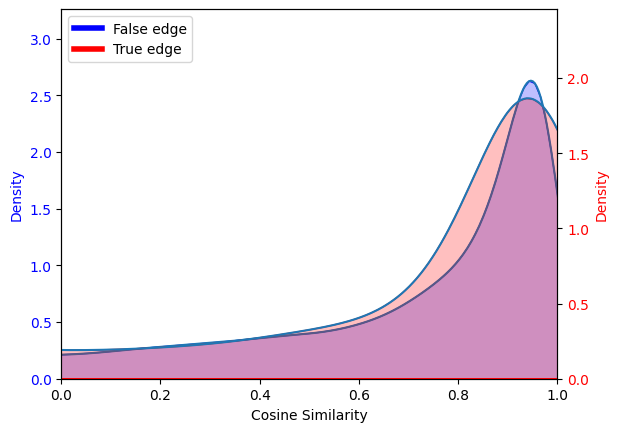

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

df_true['value'] = pd.to_numeric(df_true['value'], errors='coerce')
df_false['value'] = pd.to_numeric(df_false['value'], errors='coerce')

# Create a figure and an axis
fig, ax1 = plt.subplots()

# Plot 'False edge' density on the primary y-axis (left)
sns.kdeplot(df_false['value'], fill=True, color="b", ax=ax1)
ax1.set_ylabel('Density (False Edge)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, df_false['value'].plot(kind='kde').get_ylim()[1] + 0.5)

# Disable grid for ax1
ax1.grid(False)

# Create a secondary y-axis (right)
ax2 = ax1.twinx()

# Plot 'True edge' density on the secondary y-axis (right)
sns.kdeplot(df_true['value'], fill=True, color="r", ax=ax2)
ax2.set_ylabel('Density (True Edge)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, df_true['value'].plot(kind='kde').get_ylim()[1] + 0.5)

# Disable grid for ax2
ax2.grid(False)

# x-axis label and limits
ax1.set_xlabel('Cosine Similarity')
ax1.set_xlim(0, 1)

# Create custom legend handles
legend_handles = [Line2D([0], [0], color='b', lw=4, label='False edge'),
                  Line2D([0], [0], color='r', lw=4, label='True edge')]

# Add the legend with the custom handles
ax1.legend(handles=legend_handles, loc='upper left')

plt.show()

## Area Under Distribution

In [31]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\dlsxjs\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [32]:
from scipy.stats import gaussian_kde

# 각 데이터셋에 대한 KDE 계산
kde_true = gaussian_kde(df_true['value'].dropna())
kde_false = gaussian_kde(df_false['value'].dropna())

# 특정 범위를 정의 (예: 전체 데이터 범위)
min_val = min(df_true['value'].min(), df_false['value'].min())
max_val = max(df_true['value'].max(), df_false['value'].max())

# 적분을 사용하여 해당 범위에 대한 면적 계산
area_true = kde_true.integrate_box_1d(min_val, max_val)
area_false = kde_false.integrate_box_1d(min_val, max_val)

print("True edge area under KDE:", area_true)
print("False edge area under KDE:", area_false)

True edge area under KDE: 0.8229016645489646
False edge area under KDE: 0.9442421912002111
